## Phylogenetics in R

In [ ]:
#@title ### Run to set up notebook (Takes ~ 15 minutes).
# Clone github repository, install spatial dependencies for linux, install R packages
dir.create("My Git Repo")
git2r::clone("https://github.com/Syrph/BCB_Practicals", "My Git Repo")
setwd("My Git Repo")
system("sudo apt-get update")
system("sudo apt-get install libgdal-dev libproj-dev libgeos-dev libudunits2-dev libv8-dev libprotobuf-dev libjq-dev")
source("install.R")

# Load in all the accip maps and combine them into one big sp datafame
library(rgdal)
library(raster)
library(dplyr)

# Get the file names that are Rdata objects
file_names <- list.files()
indices <- grep("*Rdata", file_names)
file_names <- file_names[indices]

# load in the first map and create a vector ready
load("Accipiter_albogularis_maps.Rdata")
assign("Accipiter_albogularis_maps", species_map)
Accip_maps <- Accipiter_albogularis_maps

# Load in the rest of the maps and combine them
for (file in file_names[2:248]){
  name <- gsub(".Rdata", "", file)
  load(file)
  assign(name, species_map)
  Accip_maps <- rbind(Accip_maps, get(name))
}

# Save it back as an R.data object
save(Accip_maps, file = "Accipitridae_maps.Rdata")
rm(list=ls())

# Remove the packages for students to load back in later
detach("package:raster", unload = TRUE)
detach("package:rgdal", unload = TRUE)
detach("package:dplyr", unload= TRUE)



### 1. Introduction and resources

This practical introduces you to basic phylogenetic computing in `R`. We will review importing phylogenetic trees as data files, displaying phylogenetic trees visually, and some basic evolutionary computations that can be conducted with phylogenetic trees. This practical will deliver some of the important background for Coursework 1. Below you will find some of the relevant resources required for this practical.

Parts (sections 2,3,4) of this practical are written by [Natalie Cooper](http://nhcooper123.github.io/).
The original can be found [here](https://github.com/nhcooper123/TeachingMaterials/blob/master/PhD_Museum/VisualisingPhylo.Rmd). Whereas, parts (section 5 & 6) of this practical are written by Adam Devenish & Rob Barber (a.devenish@imperial.ac.uk) (r.barber19@imperial.ac.uk).

#### Installing and loading extra packages in R
To plot phylogenies (or use any specialized analysis) in R, you need to download one or more additional packages from the basic R installation. For this practical you will need to load the following packages:

• ape

• phytools

We've installed these packages in the last practical by using the code `source("install.R")`, but they don't automatically get loaded into your `R` session. 
Instead you need to tell `R` to load them **every time** you start a new `R` session and want to use functions from these packages. 
To load the package `ape` into your current `R` session:

In [2]:
library(ape)

You can think of `install.packages` like installing an app from the App Store on your smart phone - you only do this once - and `library` as being like pushing the app button on your phone - you do this every time you want to use the app.

Don't forget to load `phytools` too!

In [3]:
library(phytools)

Loading required package: maps



### 2. A refresher of phylogenetic trees

This section will review some basic aspects of phylogenetic trees and introduce how trees are handled at the level of software. Because you are now interacting with phylogenetic trees at a ‘lower level’ (i.e. at the bioinformatics level), it is also helpful to know some of the names for parts of phylogenetic trees used in computer science.

#### A. Tree parameters
 
A phylogenetic tree is an ordered, multifurcating graph with labeled **tips** (or **leaves**) (and sometimes labeled histories). It represents the relative degrees of relationships of species (i.e. tips or OTUs). The graph consists of a series of **branches** (or **edges**) with join successively towards **nodes** (or **vertices**, *sing.* **vertex**). Each node is subtended by a single branch, representing the lineage of ancestors leading to a node. The node is thus the common ancestor of two or more descendant branches. All the descendant branches of a given node (and all of the their respective descendants) are said to form a **clade** (or **monophyletic group**).

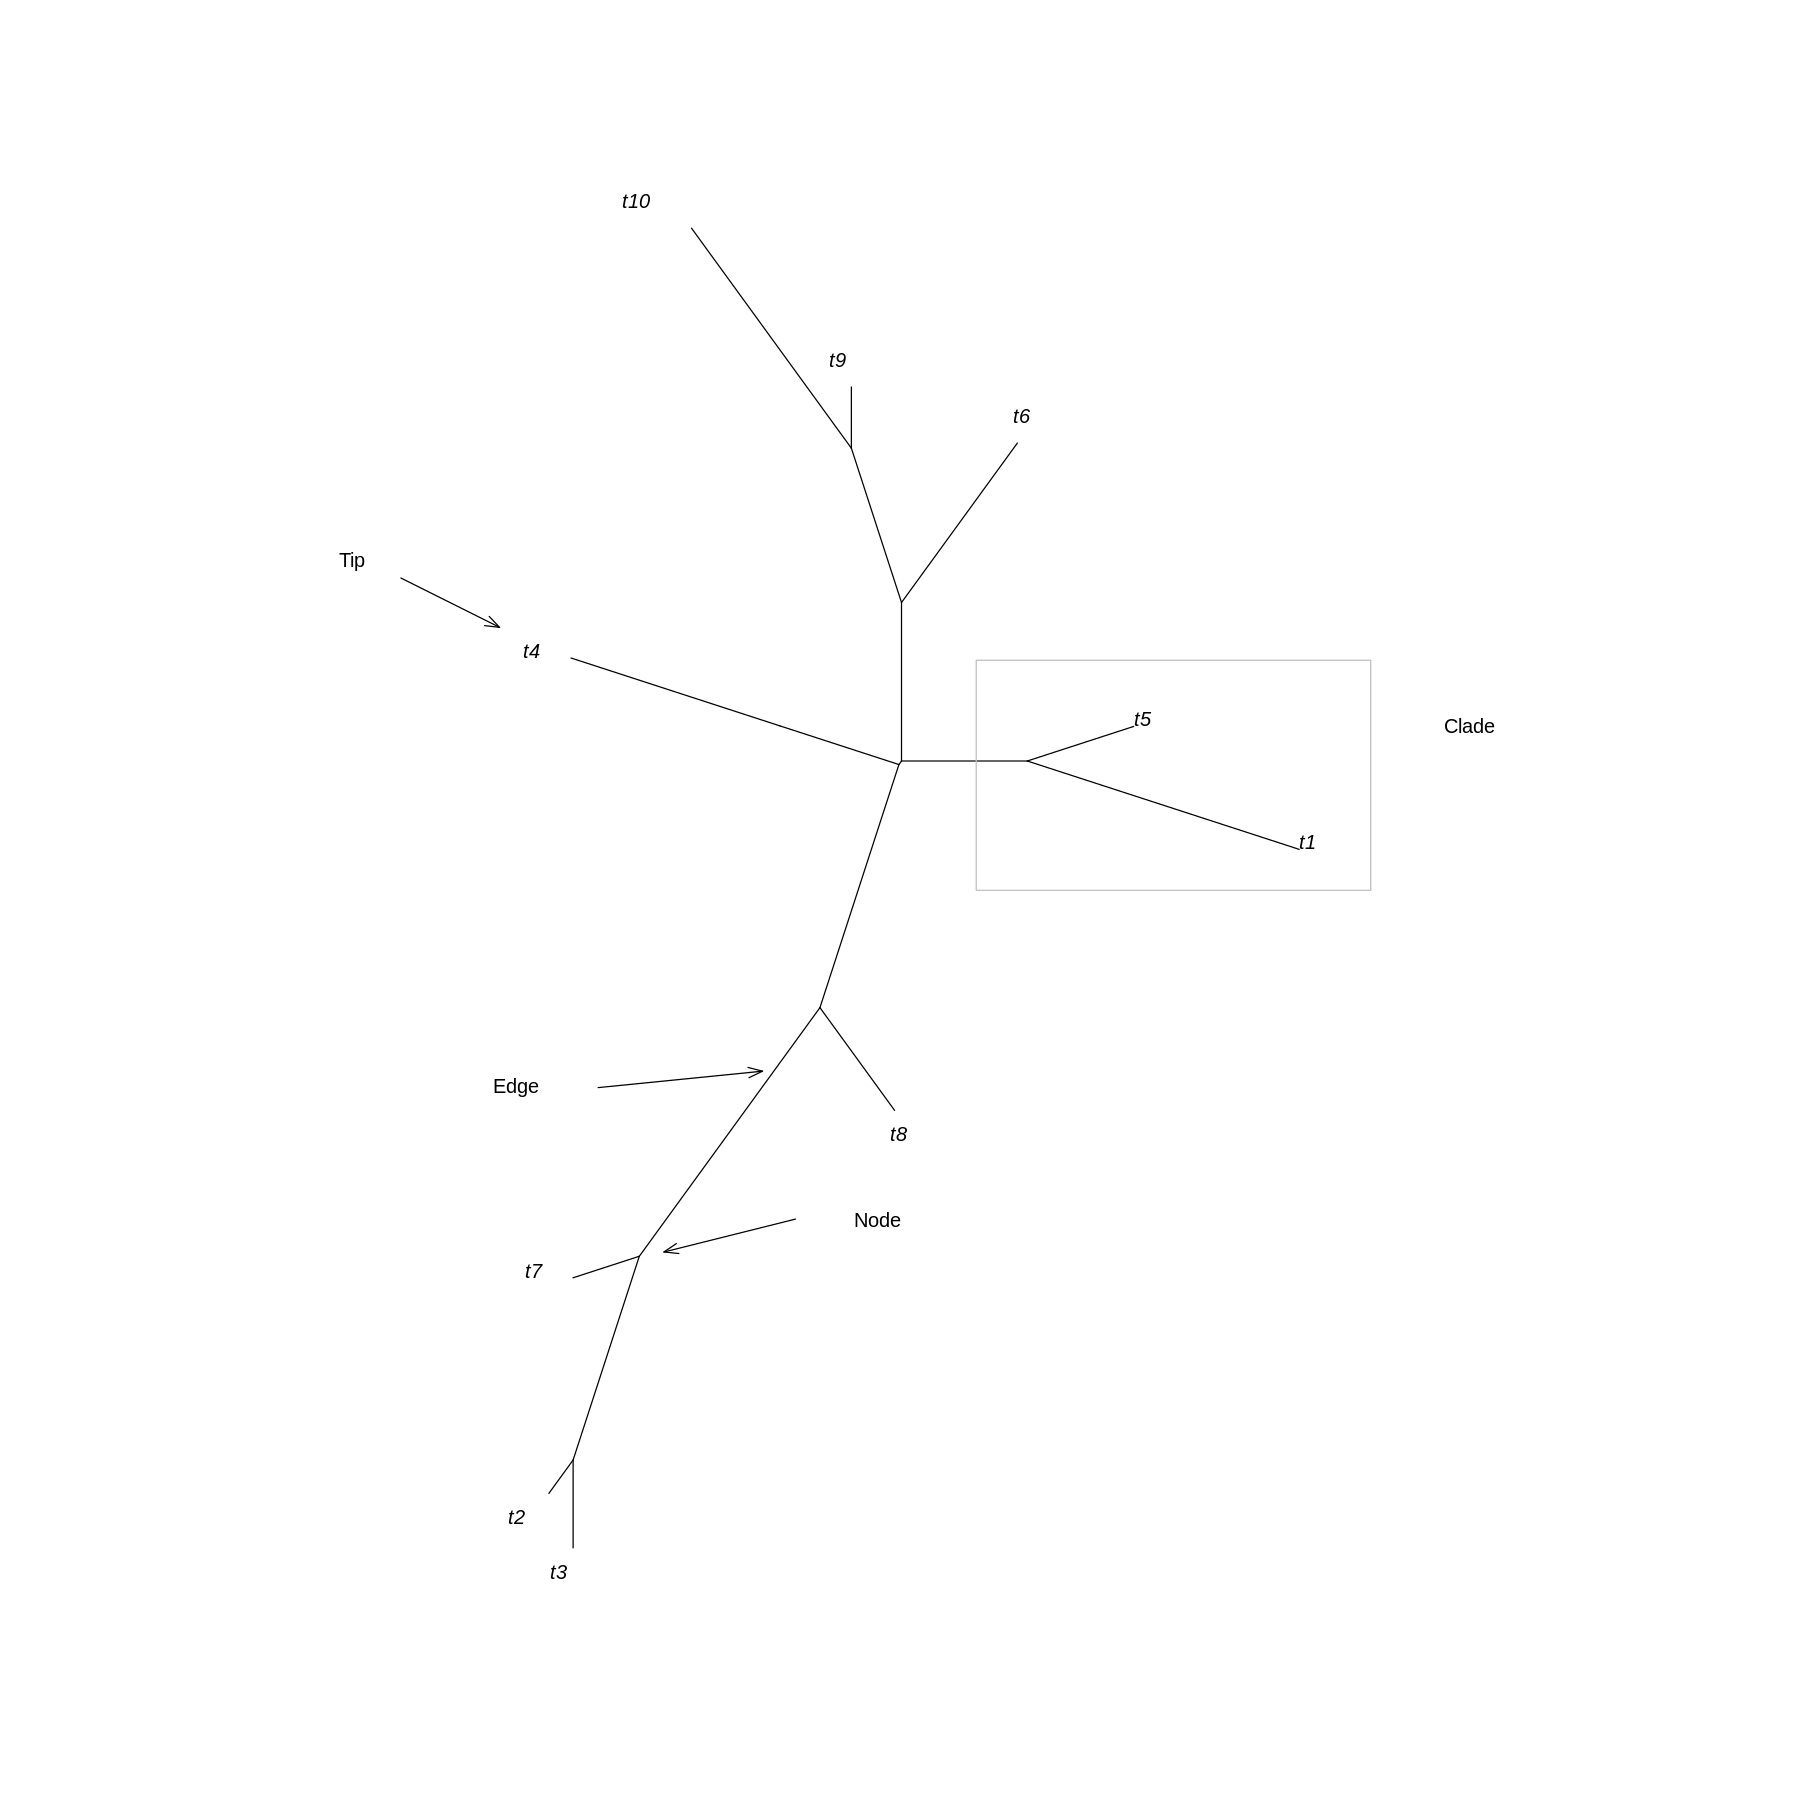

In [49]:
# rtree creates a random tree. Setting the seed means that the same 'random' tree will plotted each time. This is because random
# numbers from your computer are generated using the internal clock. Google it for more info!
set.seed(0); plot(rtree(10), "unrooted")

# Plot clade label
rect(1.3,2.0,2.5,2.7, border = "grey")
text(2.8, 2.5, "Clade")

# Plot node label
arrows(0.35,0.9,0.75,1, length = 0.125, angle = 20, code = 1)
text(1.0, 1, "Node")

# Plot edge label
arrows(0.65,1.45,0.15,1.4, length = 0.125, angle = 20, code = 1)
text(-0.1, 1.4, "Edge")

# Plot tip label
arrows(-0.15,2.8,-0.45,2.95, length = 0.125, angle = 20, code = 1)
text(-0.6, 3, "Tip")

When we select a node to act as the base of a tree, the tree is said to be **rooted**. At the bottom of a tree, is the **root node** (or simply the **root**).

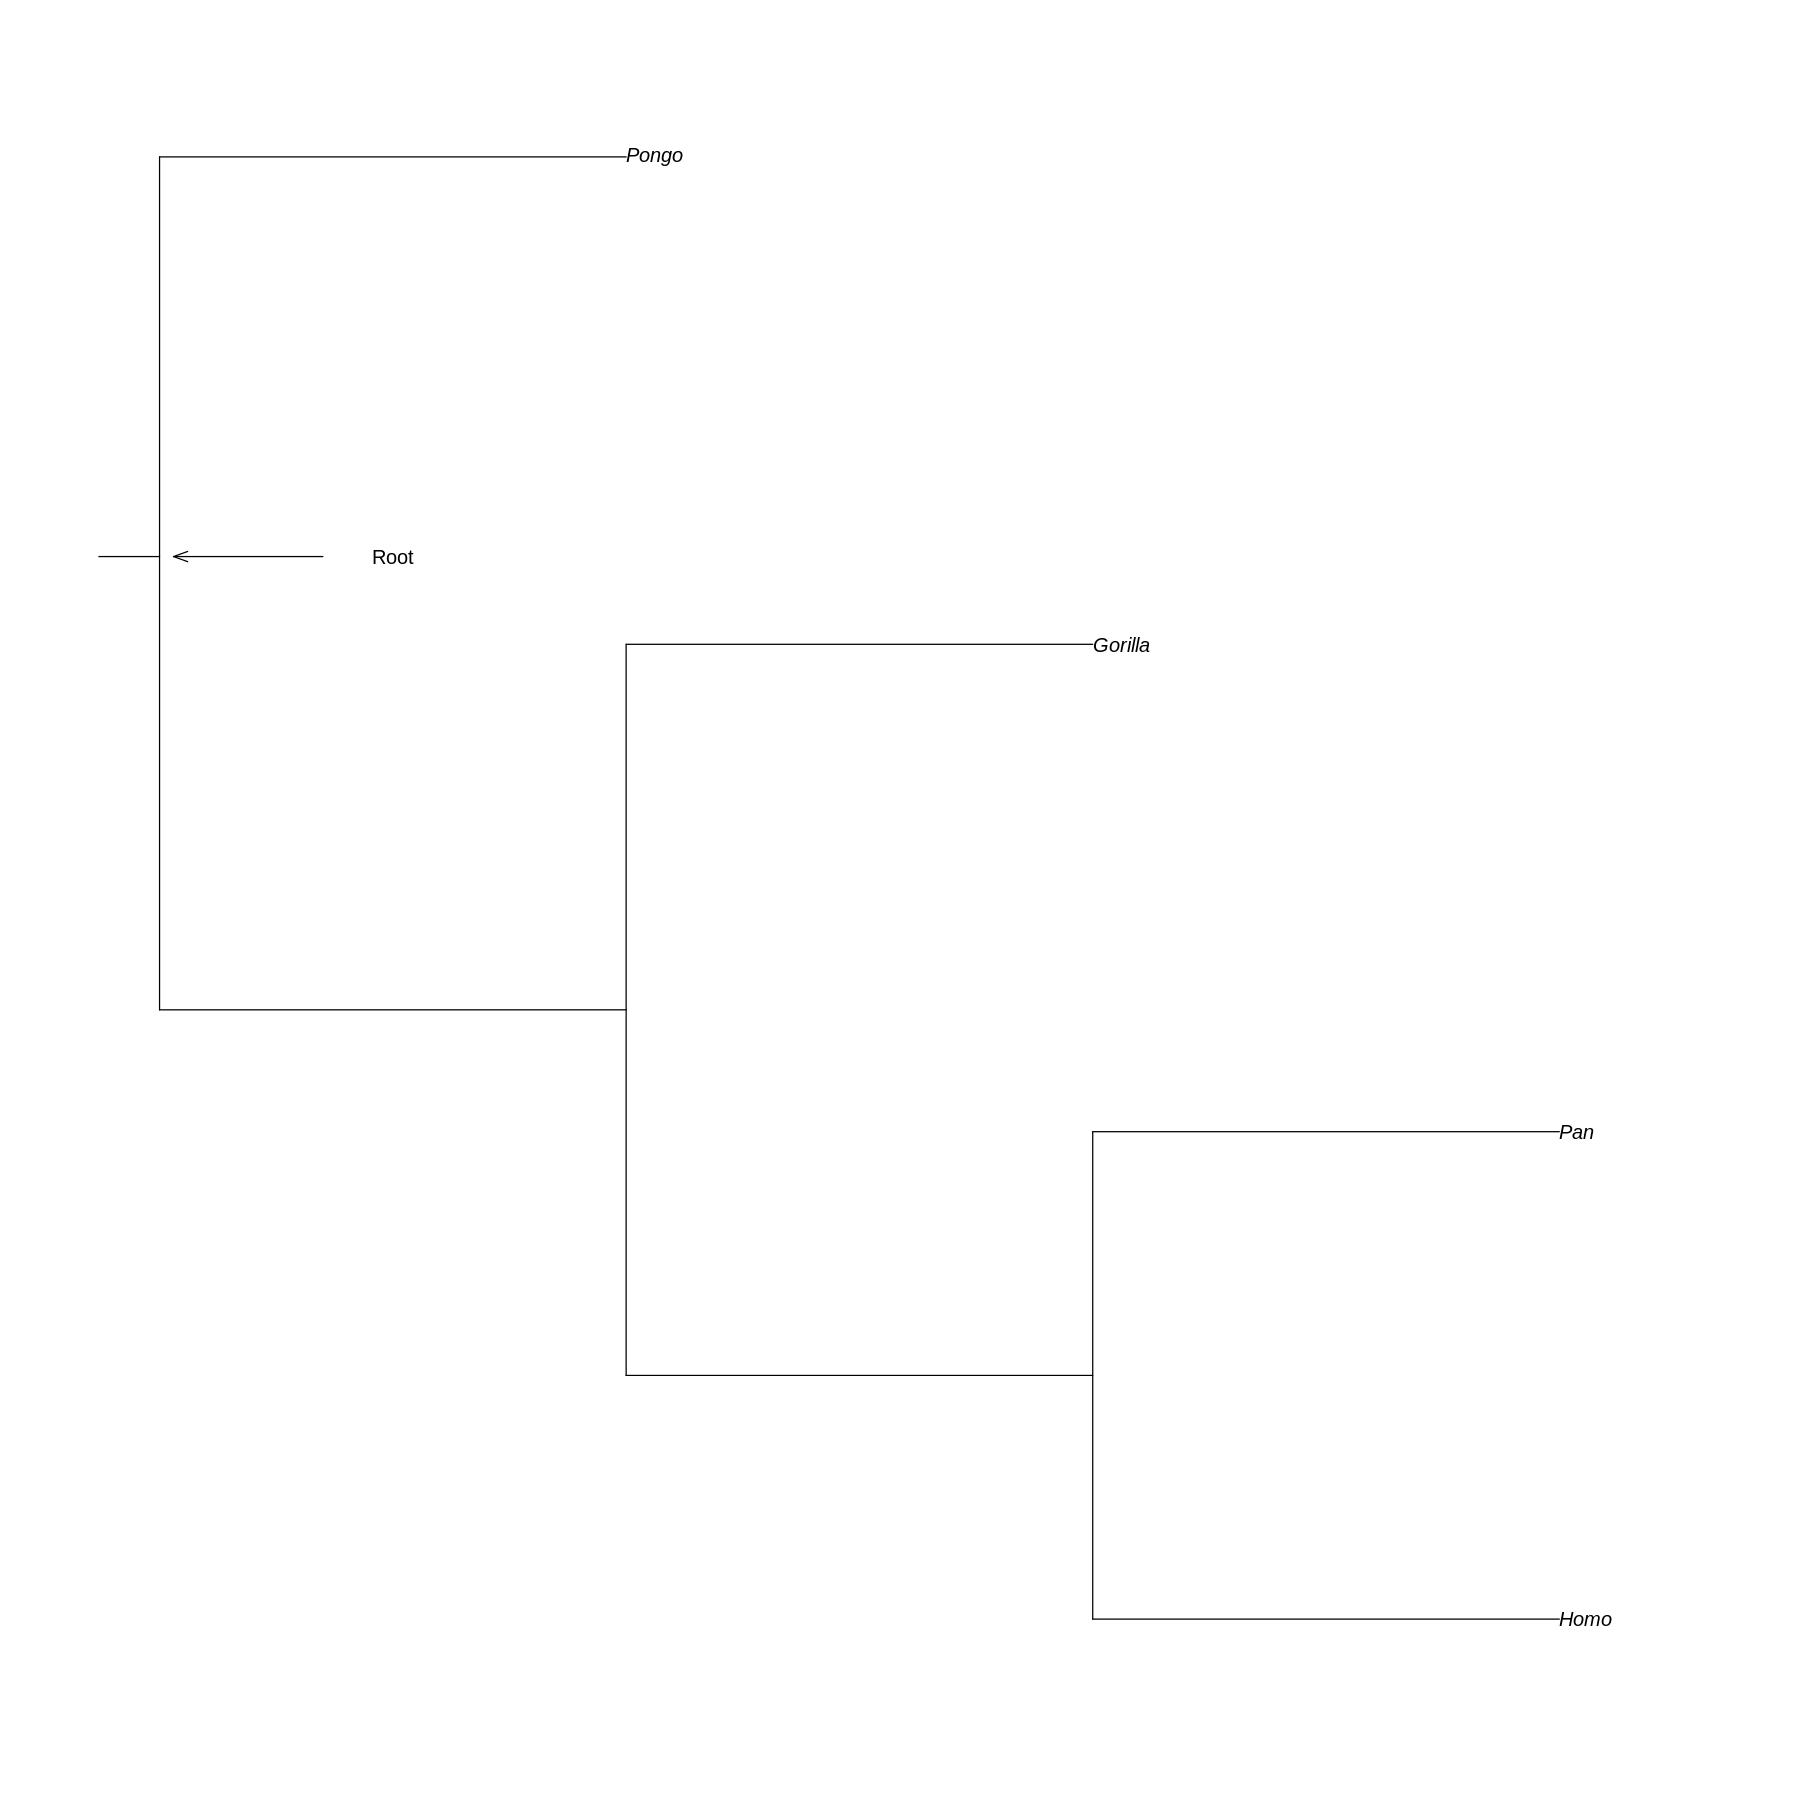

In [50]:
# You can also read in trees directly from text by specifying the branch lengths after each node/tip. More info below!
tree <- read.tree(text = "(((Homo:1, Pan:1):1, Gorilla:1):1, Pongo:1);")
plot(tree)

# Plot root label
lines(c(-0.5,0), c(3.18,3.18))
arrows(0.03,3.18,0.35,3.18, length = 0.125, angle = 20, code = 1)
text(0.5, 3.18, "Root")

Phylogenetic trees of the kind shown above are fairly simple and lack information about time or character changes occurring along a branch. We can assign branch length in the form of either time or the amount of change/substitution along a branch. A tree with **branch lengths** depicted can be called a **phylogram**.

When (an implied) dimension of time is being considered, all the tips of the tree must be at the level representing the time in which they are observed. For trees where all the species are extant, the tips are flush at the top. This representation is called an **ultrametric** tree.

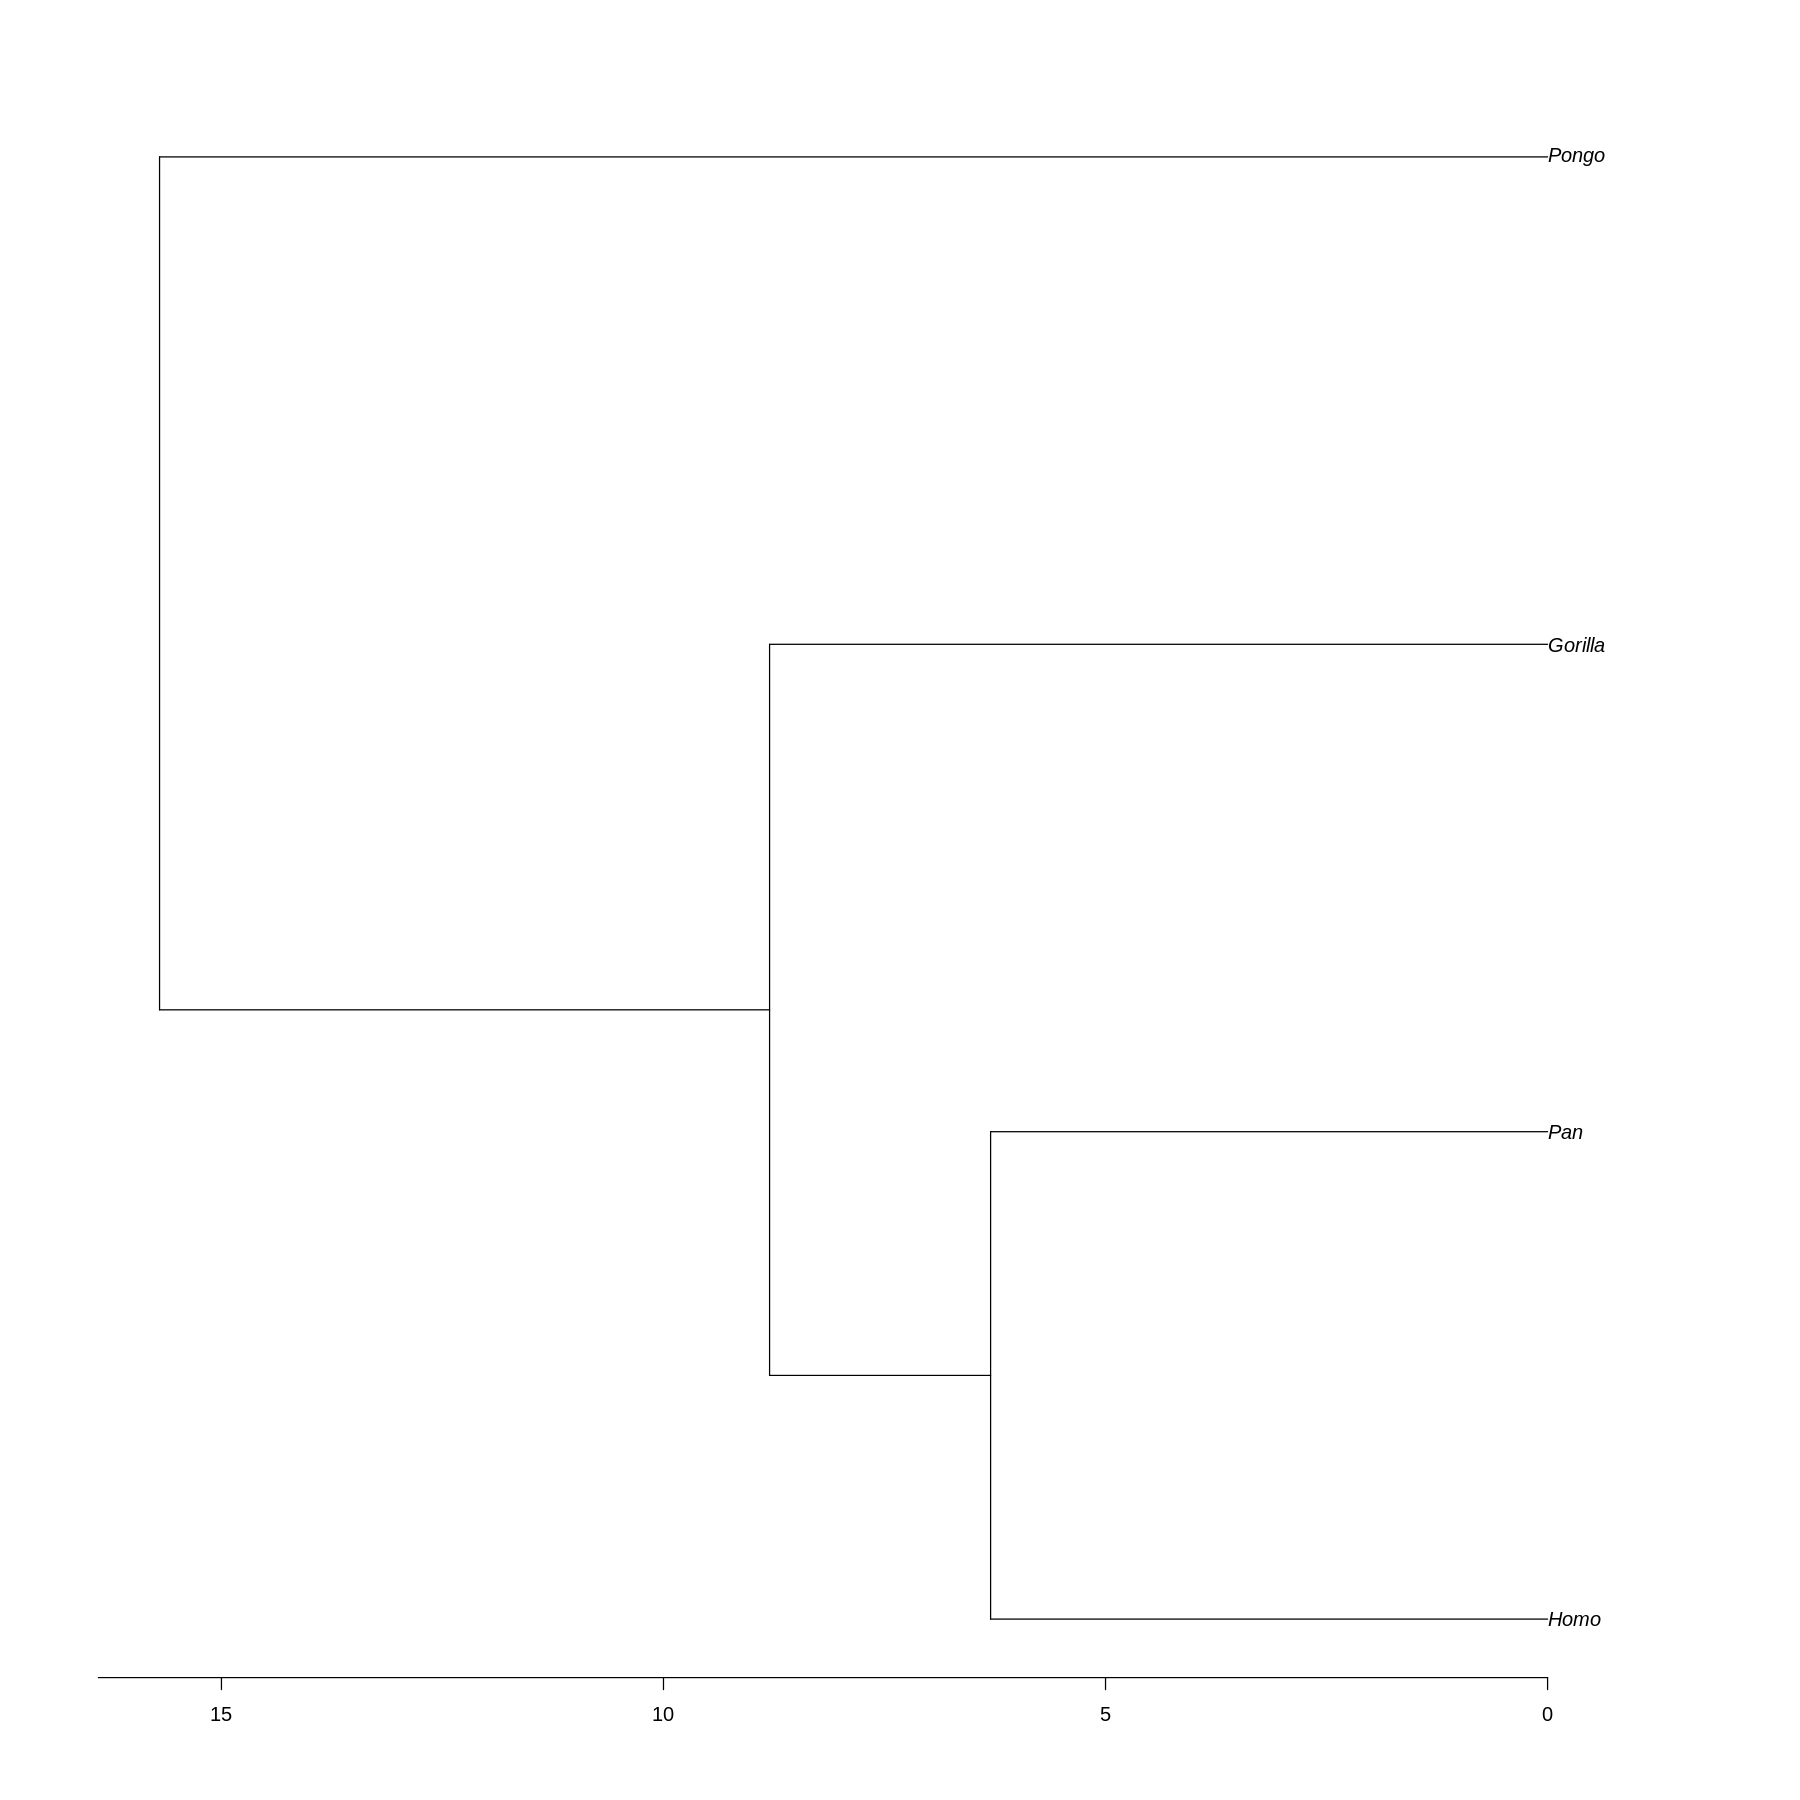

In [51]:
tree <- read.tree(text = "(((Homo:6.3, Pan:6.3):2.5, Gorilla:8.8):6.9, Pongo:15.7);")
plot(tree)
axisPhylo()

#### B. Informatic representations of tree

To perform any useful calculations on a tree, we need both a computer-readable tree format and (in part) to understand how trees are constructed in computer memory.
 
#### Text based formats

Storage of trees for transfer between different software is essential. This is most commonly achieved with a text-based format stored in a file. The most common file format for representing phylogenetic trees is **Newick format**. This consists of clades represented within parentheses. Commas separate each clade. Either tip names or symbols representing the tips are nested within the lowest orders of parentheses. Each tip or branch can be associated with a branch length scalar that follows a colon.

For example:

`"(((Homo, Pan), Gorilla), Pongo);"`

Or with branch length:

`"(((Homo:6.3, Pan:6.3):2.5, Gorilla:8.8):6.9, Pongo:15.7);"`

Trees are also increasing use of XML formats such as PhyloXML and NeXML.

In this practical we are going to use the `elopomorph.tre` newick tree.
You can open it with a simple text editor to see the newick tree structure.

#### Edge table

It is also possible to represent a phylogenetic tree as a matrix of edges and vertices called an edge table. This is an even less intuitive representation, but it is implemented in `R` and worth reviewing here.

There are a number of conventions that can be used to create an edge table. The general concept consists of numbering the tips *1 - n*, and all internal nodes labeled *n+1 ... n+n-1*. The numbers for the internal nodes can be assigned arbitrarily or according to an algorithm.

In `R` packages like `ape`, edge tables are constructed as follows:

| node | connects to |
|---|---|
| 5 | 6 |
| 6 | 7 |
| 7 | 1 |
| 7 | 2 |
| 6 | 3 |
| 5 | 4 |

You read the table as follows: node `5` (root) connects to node `6`. The node `6` connects to node `7`. Node `7` connects to node `1` that happen to be the first tip (`Homo`) and to node `2` (`Pan`) etc... Note that in a binary tree (i.e. a tree where each node has only two descendants) each node always connects to two elements (nodes or tips).

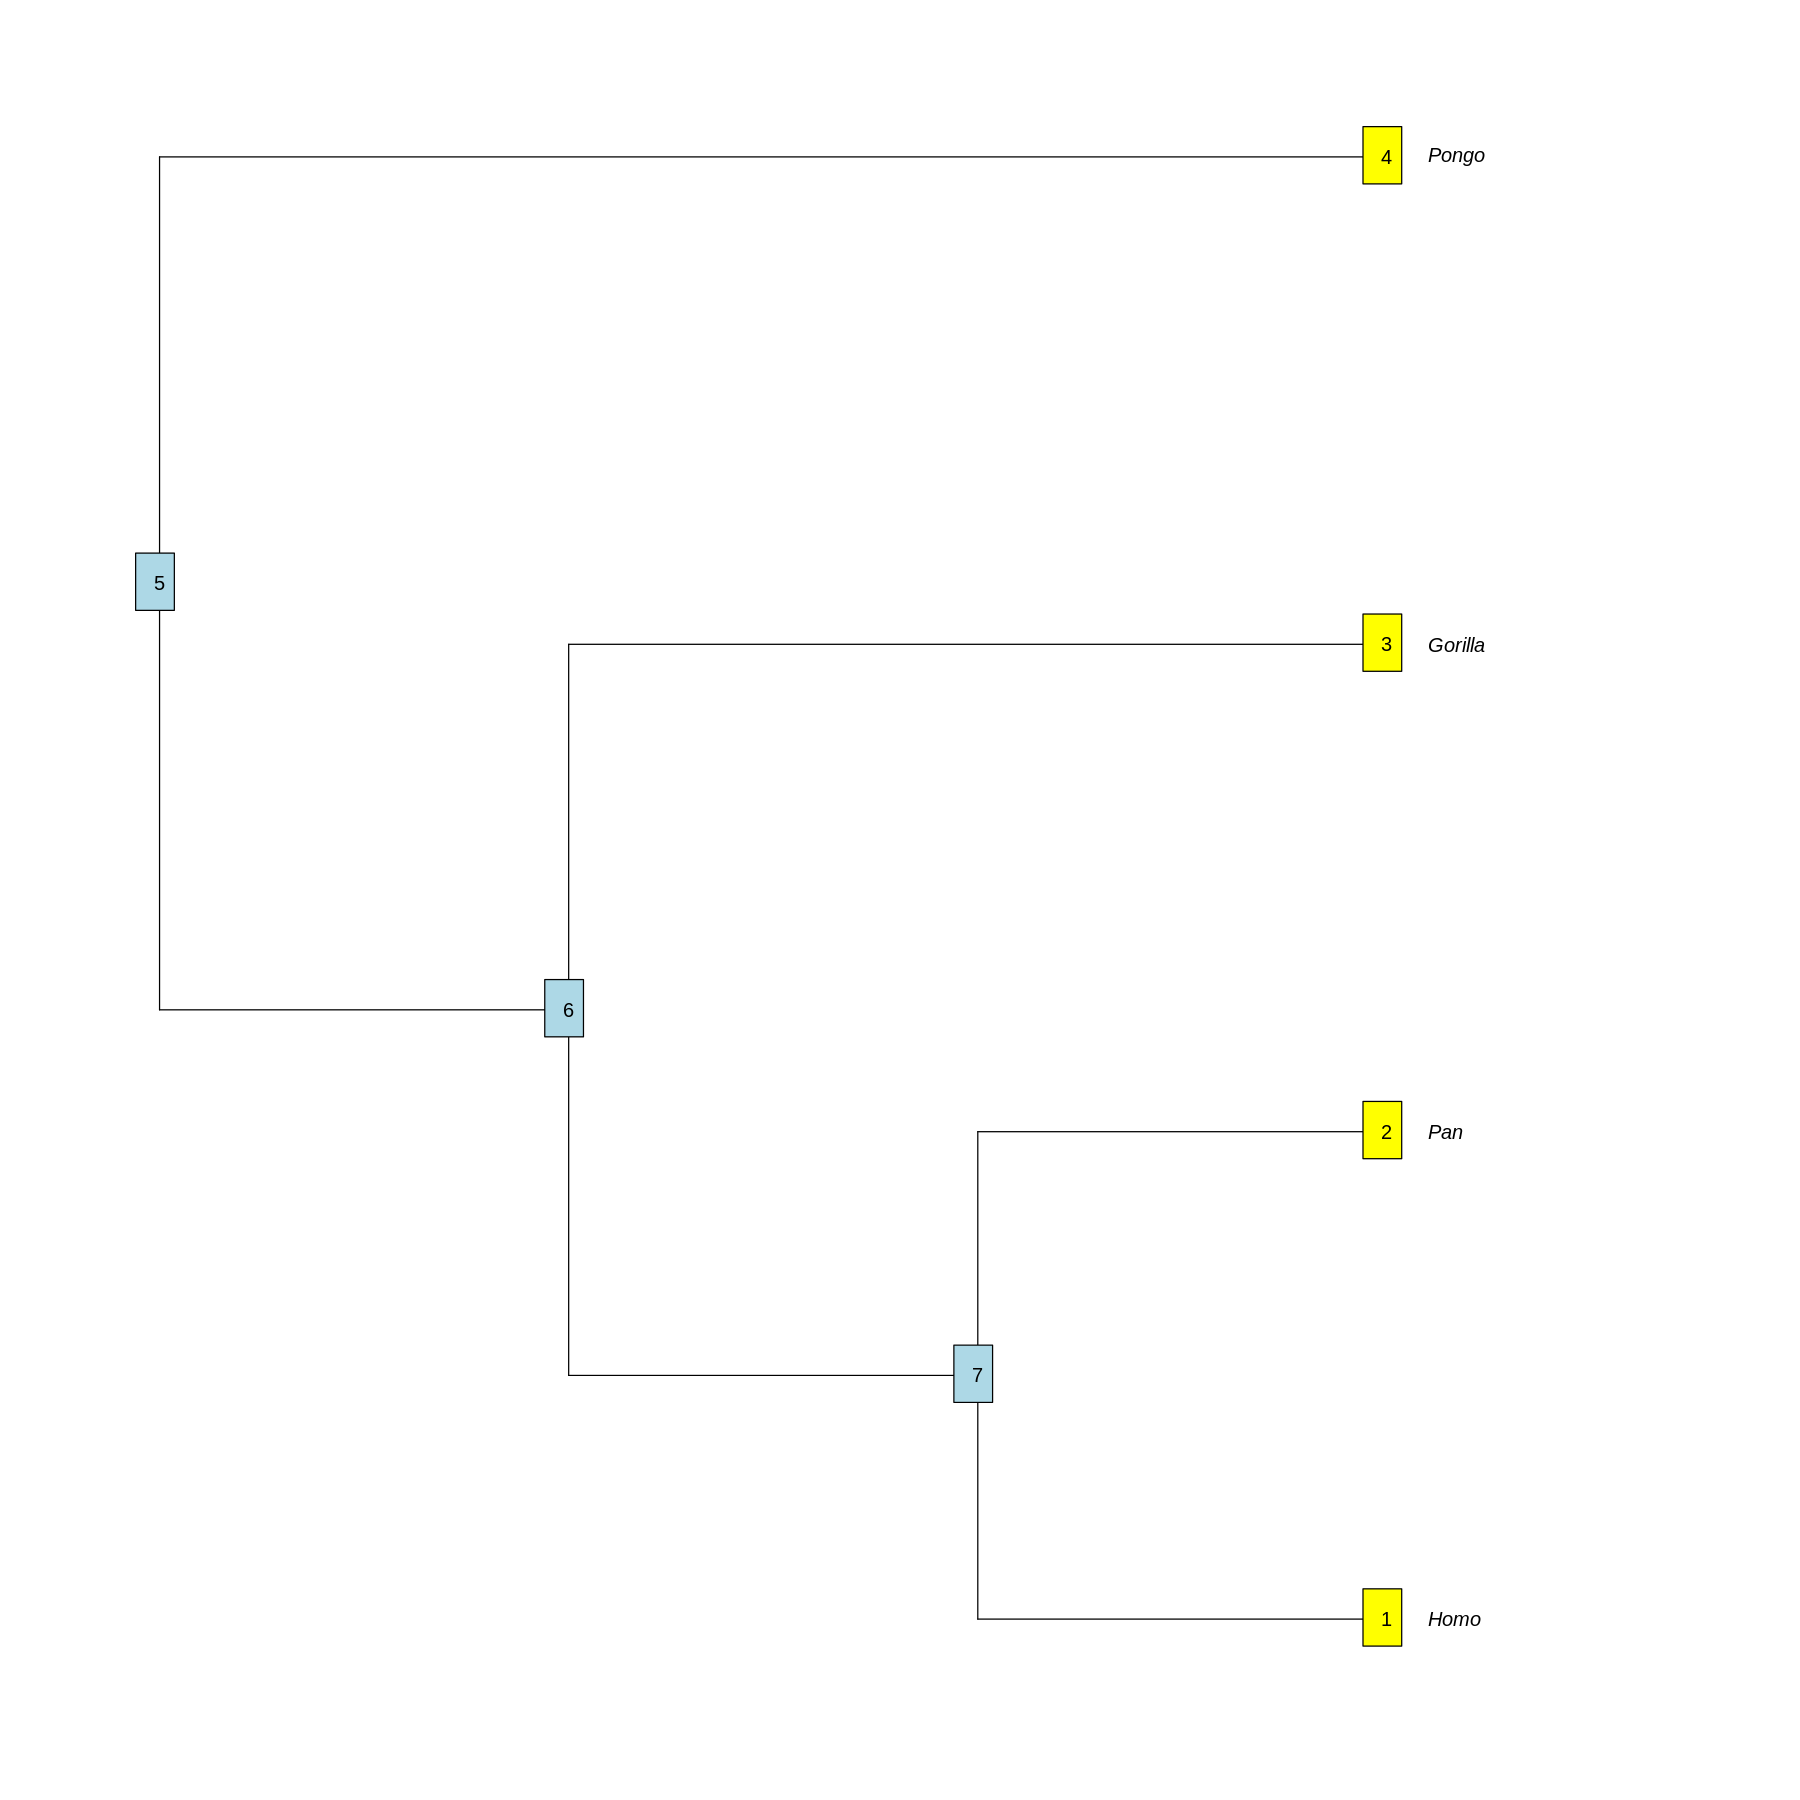

In [52]:
tree <- read.tree(text = "(((Homo, Pan), Gorilla), Pongo);")
plot(tree, label.offset = 0.1)
nodelabels() ; tiplabels()

#### Records & pointers

At a lower level, phylogenetic trees can be represented in computer memory as more complex data objects. We don’t need to go into detail here, but if you consider nodes and tips as data objects (i.e. a dataframe), a tree could be stored as an array of dataframes which store information about which store information about which members of that same array are descendants and which are ancestors.

### 3. Loading your phylogeny and data into `R`
#### Reading in a phylogeny from a file
To load a tree you need the function `read.tree`.
`read.tree` can read any newick format trees (see above) like the `elopomorph.tre` file.

In [53]:
fishtree <- read.tree("elopomorph.tre")

**Be sure you are always in the right directory. Remember you can navigate in `R` using `setwd()`, `getwd()` and `list.files()` (to see what's in the current directory). While using this notebook all the files are stored in the main binder, so you shouldn't need to change the directory.**

#### Reading in a phylogeny that is already built into `R`
The bird and anole phylogenies are already built into `R` so we don't need to read them in using `read.tree`.
Instead we just use:


In [54]:
data(bird.orders)
data(anoletree)

#### Reading and viewing your data in `R`
Later we will use some Greater Antillean *Anolis* lizard data to add data to a phylogeny.
Before we can add data to our tree, we need to load the data we are going to use. 
`R` can read files in lots of formats, including comma-delimited and tab-delimited files.
Excel (and many other applications) can output files in this format (it's an option in the `Save As` dialogue box under the `File` menu). 
To save time I have given you a comma-delimited text file called `anole.data.csv` which we are going to use. 
Load these data as follows. 
I am assuming you have set your working directory, if not don't forget the path.

In [55]:
anoledata <- read.csv("anole.data.csv", header = TRUE)

You can use `read.delim` for tab delimited files or `read.csv` for comma delimited files (**c**omma **s**eparated **v**alues).
`header = TRUE`, indicates that the first line of the data contains column headings.

This is a good point to note that unless you **tell** `R` you want to do something, it won't do it automatically. 
So here if you successfully entered the data, `R` won't give you any indication that it worked.
Instead you need to specifically ask `R` to look at the data.

We can look at the data by typing:

In [56]:
str(anoledata)

'data.frame':	100 obs. of  23 variables:
 $ species               : chr  "ahli" "alayoni" "alfaroi" "aliniger" ...
 $ AVG.SVL               : num  4.04 3.82 3.53 4.04 4.38 ...
 $ AVG.hl                : num  2.88 2.7 2.38 2.9 3.36 ...
 $ AVG.hw                : num  2.36 1.99 1.56 2.37 2.69 ...
 $ AVG.hh                : num  2.13 1.75 1.39 2.05 2.32 ...
 $ AVG.ljl               : num  2.85 2.71 2.32 2.9 3.38 ...
 $ AVG.outlever          : num  2.75 2.62 2.26 2.83 3.29 ...
 $ AVG.jugal.to.symphysis: num  2.54 2.37 2.08 2.6 3.07 ...
 $ AVG.femur             : num  2.74 2.07 2.17 2.48 2.8 ...
 $ AVG.tibia             : num  2.69 2.02 2.09 2.34 2.69 ...
 $ AVG.met               : num  2.25 1.54 1.55 1.87 2.18 ...
 $ AVG.ltoe.IV           : num  2.55 1.88 1.73 2.26 2.53 ...
 $ AVG.toe.IV.lam.width  : num  0.1795 0.0488 -0.5361 0.4904 0.8441 ...
 $ AVG.humerus           : num  2.46 1.95 1.63 2.3 2.62 ...
 $ AVG.radius            : num  2.27 1.69 1.4 2.09 2.34 ...
 $ AVG.lfing.IV          : 

**Always** look at your data before beginning any analysis to check it read in correctly.

`str` shows the structure of the data frame (this can be a really useful command when you have a big data file). 
It also tells you what kind of variables `R` thinks you have (characters, integers, numeric, factors etc.). 
Some `R` functions need the data to be certain kinds of variables so it's useful to check this.

In [57]:
head(anoledata)

,species,AVG.SVL,AVG.hl,AVG.hw,AVG.hh,AVG.ljl,AVG.outlever,AVG.jugal.to.symphysis,AVG.femur,AVG.tibia,⋯,AVG.humerus,AVG.radius,AVG.lfing.IV,AVG.fing.IV.lam.width,AVG.pelv.ht,AVG.pelv.wd,Foot.Lam.num,Hand.Lam.num,Avg.lnSVL2,Avg.ln.t1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ahli,4.039125,2.882657,2.356126,2.131599,2.854745,2.754934,2.538052,2.741378,2.686032,⋯,2.460728,2.268511,1.943288,0.07541664,1.987646,1.7095849,3.279600,2.866197,3.939015,4.406652
2,alayoni,3.815705,2.702116,1.990610,1.751588,2.708966,2.617852,2.371995,2.065121,2.016402,⋯,1.947873,1.687093,1.403029,-0.07391568,1.507128,1.4194873,3.432372,3.075269,3.743863,4.002788
3,alfaroi,3.526655,2.378156,1.556037,1.390037,2.323857,2.263844,2.077565,2.172476,2.094946,⋯,1.628260,1.401183,1.040277,-0.75502258,1.189367,0.9458495,3.198016,2.733866,3.478776,4.369448
4,aliniger,4.036557,2.898836,2.366592,2.046660,2.903946,2.828555,2.596821,2.475445,2.344015,⋯,2.298878,2.091864,1.702199,0.31554040,1.867949,1.7521520,3.582875,3.156774,3.933181,4.441203
5,allisoni,4.375390,3.358957,2.690339,2.317309,3.381306,3.288402,3.071149,2.795145,2.687734,⋯,2.618551,2.341565,1.983412,0.65838319,2.097302,2.0142361,3.721185,3.239211,4.355582,5.039851
6,allogus,4.040138,2.861027,2.351275,2.142107,2.848331,2.750404,2.539320,2.739175,2.684476,⋯,2.459994,2.267176,1.919010,0.05329130,2.008426,1.6875679,3.335990,2.808270,4.028863,4.510920


This gives you the first few rows of data along with the column headings.

In [58]:
names(anoledata)

[1] "species"                "AVG.SVL"                "AVG.hl"                
 [4] "AVG.hw"                 "AVG.hh"                 "AVG.ljl"               
 [7] "AVG.outlever"           "AVG.jugal.to.symphysis" "AVG.femur"             
[10] "AVG.tibia"              "AVG.met"                "AVG.ltoe.IV"           
[13] "AVG.toe.IV.lam.width"   "AVG.humerus"            "AVG.radius"            
[16] "AVG.lfing.IV"           "AVG.fing.IV.lam.width"  "AVG.pelv.ht"           
[19] "AVG.pelv.wd"            "Foot.Lam.num"           "Hand.Lam.num"          
[22] "Avg.lnSVL2"             "Avg.ln.t1"

This gives you the names of the columns.

In [59]:
anoledata

species,AVG.SVL,AVG.hl,AVG.hw,AVG.hh,AVG.ljl,AVG.outlever,AVG.jugal.to.symphysis,AVG.femur,AVG.tibia,⋯,AVG.humerus,AVG.radius,AVG.lfing.IV,AVG.fing.IV.lam.width,AVG.pelv.ht,AVG.pelv.wd,Foot.Lam.num,Hand.Lam.num,Avg.lnSVL2,Avg.ln.t1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ahli,4.039125,2.882657,2.356126,2.131599,2.854745,2.754934,2.538052,2.741378,2.686032,⋯,2.460728,2.268511,1.943288,0.07541664,1.987646,1.7095849,3.279600,2.866197,3.939015,4.406652
alayoni,3.815705,2.702116,1.990610,1.751588,2.708966,2.617852,2.371995,2.065121,2.016402,⋯,1.947873,1.687093,1.403029,-0.07391568,1.507128,1.4194873,3.432372,3.075269,3.743863,4.002788
alfaroi,3.526655,2.378156,1.556037,1.390037,2.323857,2.263844,2.077565,2.172476,2.094946,⋯,1.628260,1.401183,1.040277,-0.75502258,1.189367,0.9458495,3.198016,2.733866,3.478776,4.369448
aliniger,4.036557,2.898836,2.366592,2.046660,2.903946,2.828555,2.596821,2.475445,2.344015,⋯,2.298878,2.091864,1.702199,0.31554040,1.867949,1.7521520,3.582875,3.156774,3.933181,4.441203
allisoni,4.375390,3.358957,2.690339,2.317309,3.381306,3.288402,3.071149,2.795145,2.687734,⋯,2.618551,2.341565,1.983412,0.65838319,2.097302,2.0142361,3.721185,3.239211,4.355582,5.039851
allogus,4.040138,2.861027,2.351275,2.142107,2.848331,2.750404,2.539320,2.739175,2.684476,⋯,2.459994,2.267176,1.919010,0.05329130,2.008426,1.6875679,3.335990,2.808270,4.028863,4.510920
altitudinalis,3.842994,2.852728,2.192770,1.949119,2.833213,2.753820,2.561482,2.109000,2.002493,⋯,2.055085,1.830179,1.349371,-0.00250313,1.735189,1.5454326,3.511434,3.198465,3.868386,4.192315
alumina,3.588941,2.417825,1.610295,1.455621,2.392034,2.304441,2.104483,2.230629,2.182836,⋯,1.772771,1.568021,1.179973,-0.64299740,1.232144,1.0336927,3.364413,2.694252,3.589352,4.667160
alutaceus,3.554891,2.434052,1.657275,1.512486,2.400528,2.316291,2.132271,2.151530,2.118061,⋯,1.690834,1.511825,1.133336,-0.45570633,1.216099,0.9738046,3.331201,2.782455,3.549917,4.549890


This will print out all of the data!

### 4. Basic tree viewing in `R`
Now let's visualise some phylogenies! We'll use the Elopomorpha (eels and similar fishes) tree to start as it is simple.

In [60]:
fishtree <- read.tree("elopomorph.tre")

Let's examine the tree by typing:

In [61]:
fishtree
str(fishtree)


Phylogenetic tree with 62 tips and 61 internal nodes.

Tip labels:
  Moringua_edwardsi, Kaupichthys_nuchalis, Gorgasia_taiwanensis, Heteroconger_hassi, Venefica_proboscidea, Anguilla_rostrata, ...

Rooted; includes branch lengths.

List of 4
 $ edge       : int [1:122, 1:2] 63 64 64 65 66 67 68 68 69 70 ...
 $ edge.length: num [1:122] 0.0105 0.0672 0.00537 0.00789 0.00157 ...
 $ Nnode      : int 61
 $ tip.label  : chr [1:62] "Moringua_edwardsi" "Kaupichthys_nuchalis" "Gorgasia_taiwanensis" "Heteroconger_hassi" ...
 - attr(*, "class")= chr "phylo"
 - attr(*, "order")= chr "cladewise"


`fishtree` is a fully resolved tree with branch lengths. 
There are 62 species and 61 internal nodes. 
We can plot the tree by using the `plot.phylo` function of `ape`. 
Note that we can just use the function `plot` to do this as `R` knows if we ask it to plot a phylogeny to use `plot.phylo` instead!

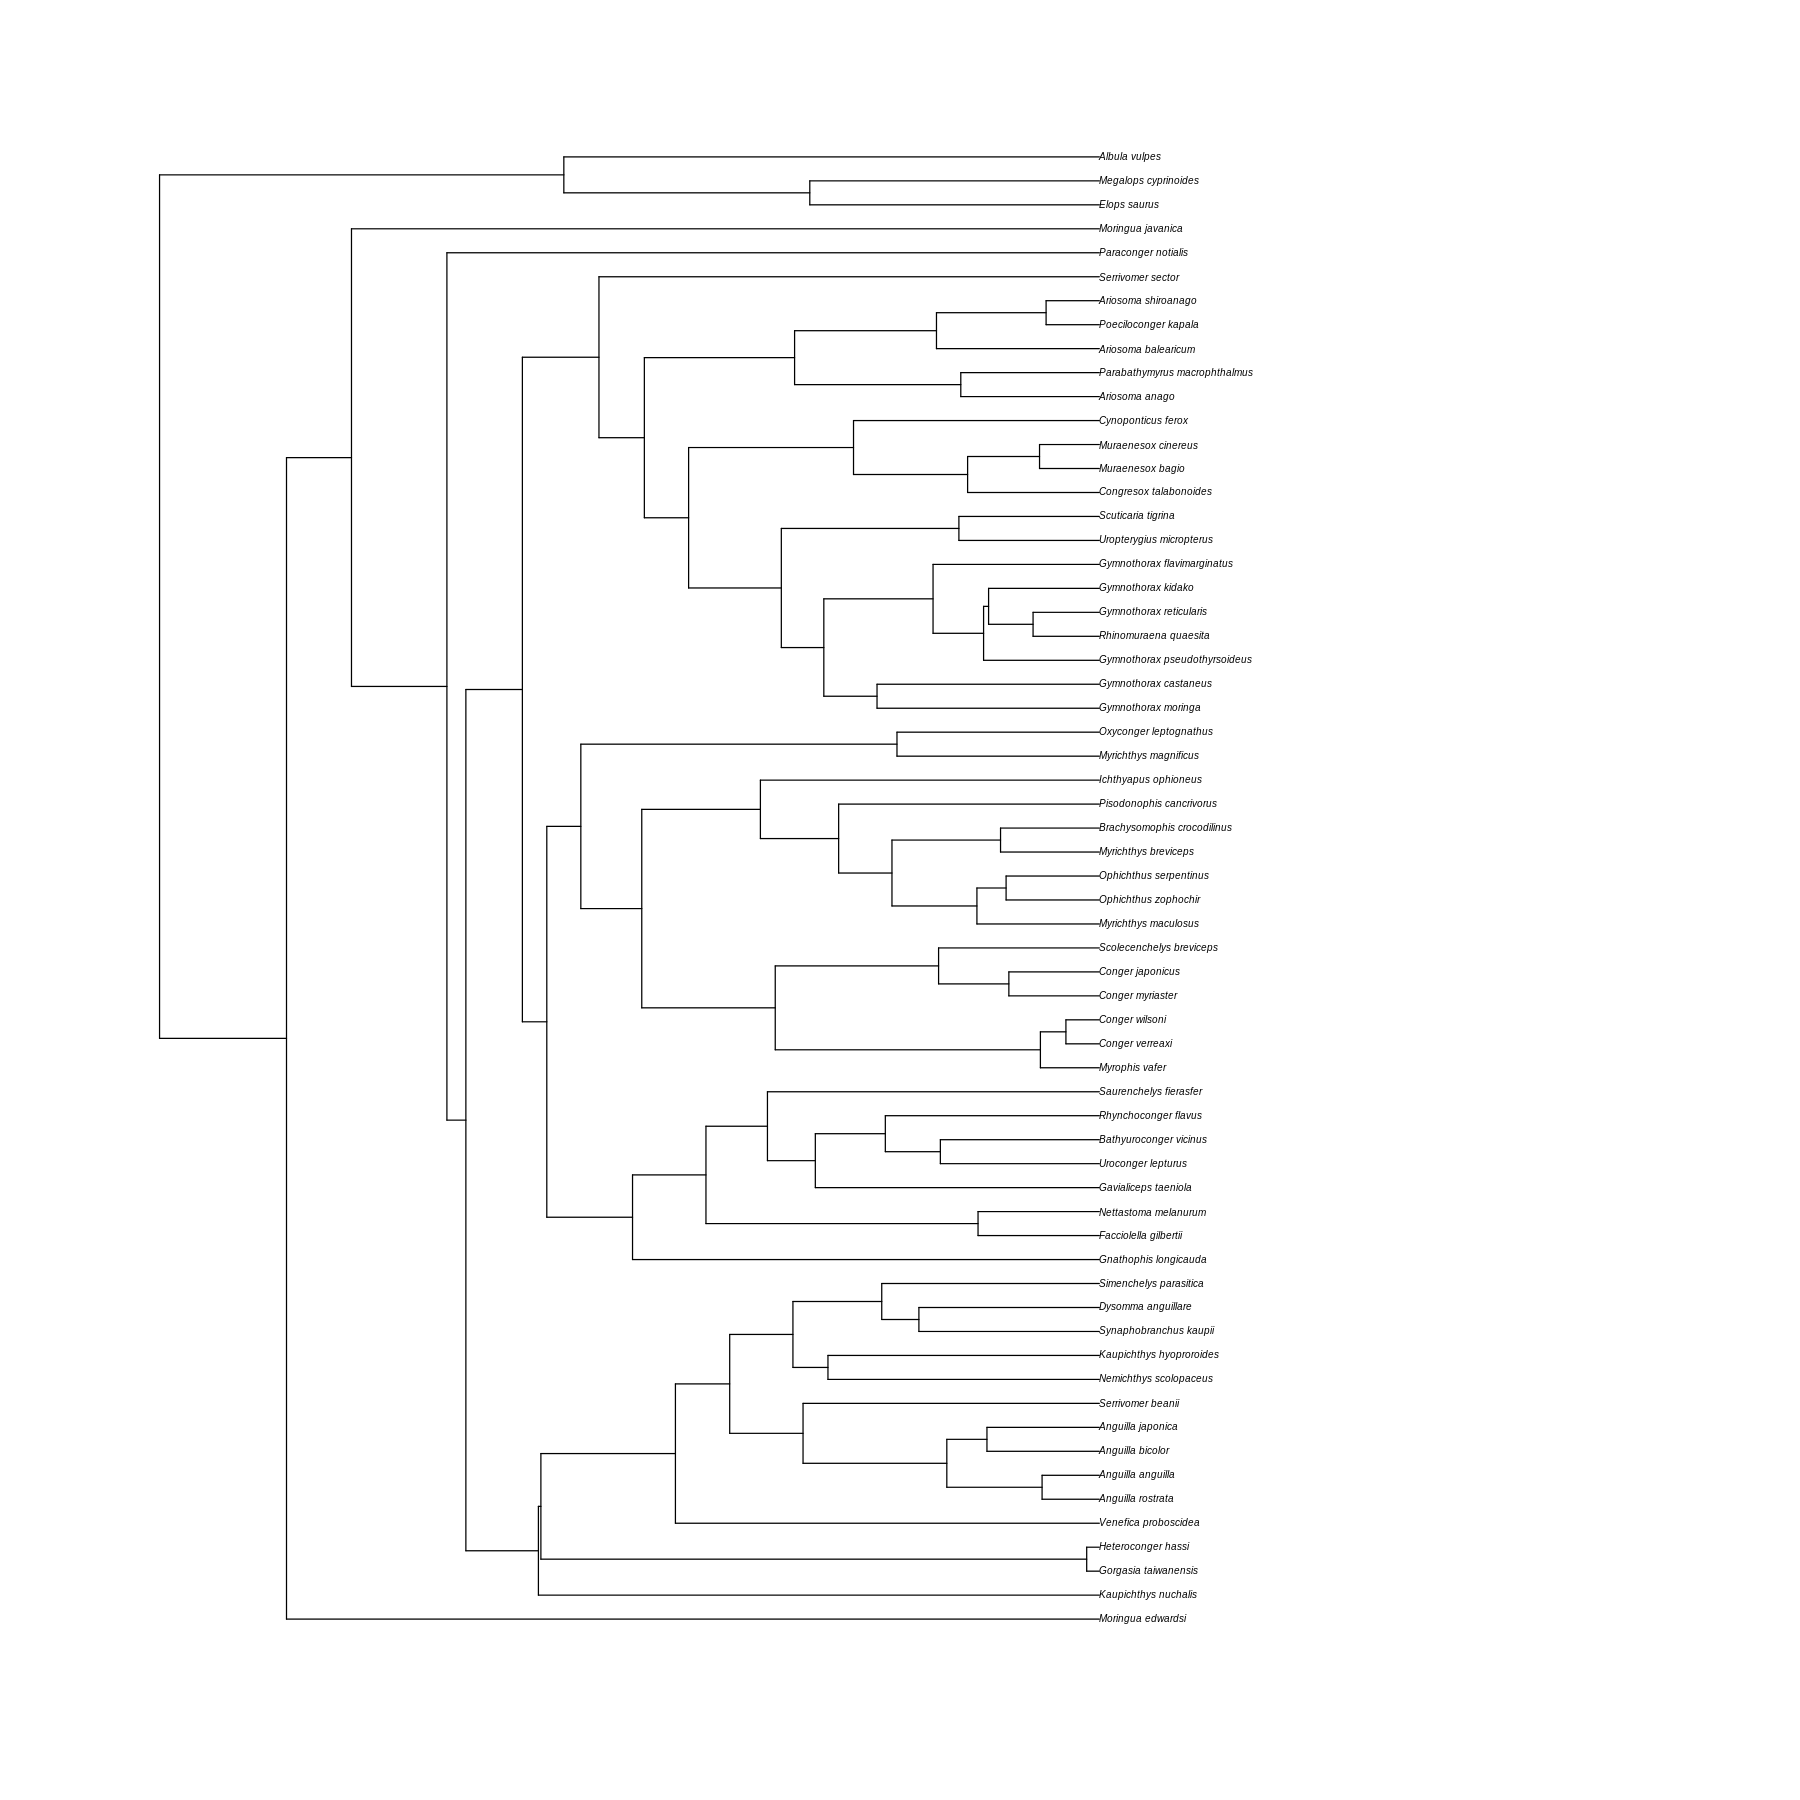

In [62]:
plot(fishtree, cex = 0.5)

`cex = 0.5` reduces the size of the tip labels so we can read them. 

We can also zoom into different sections of the tree that you're interested in:

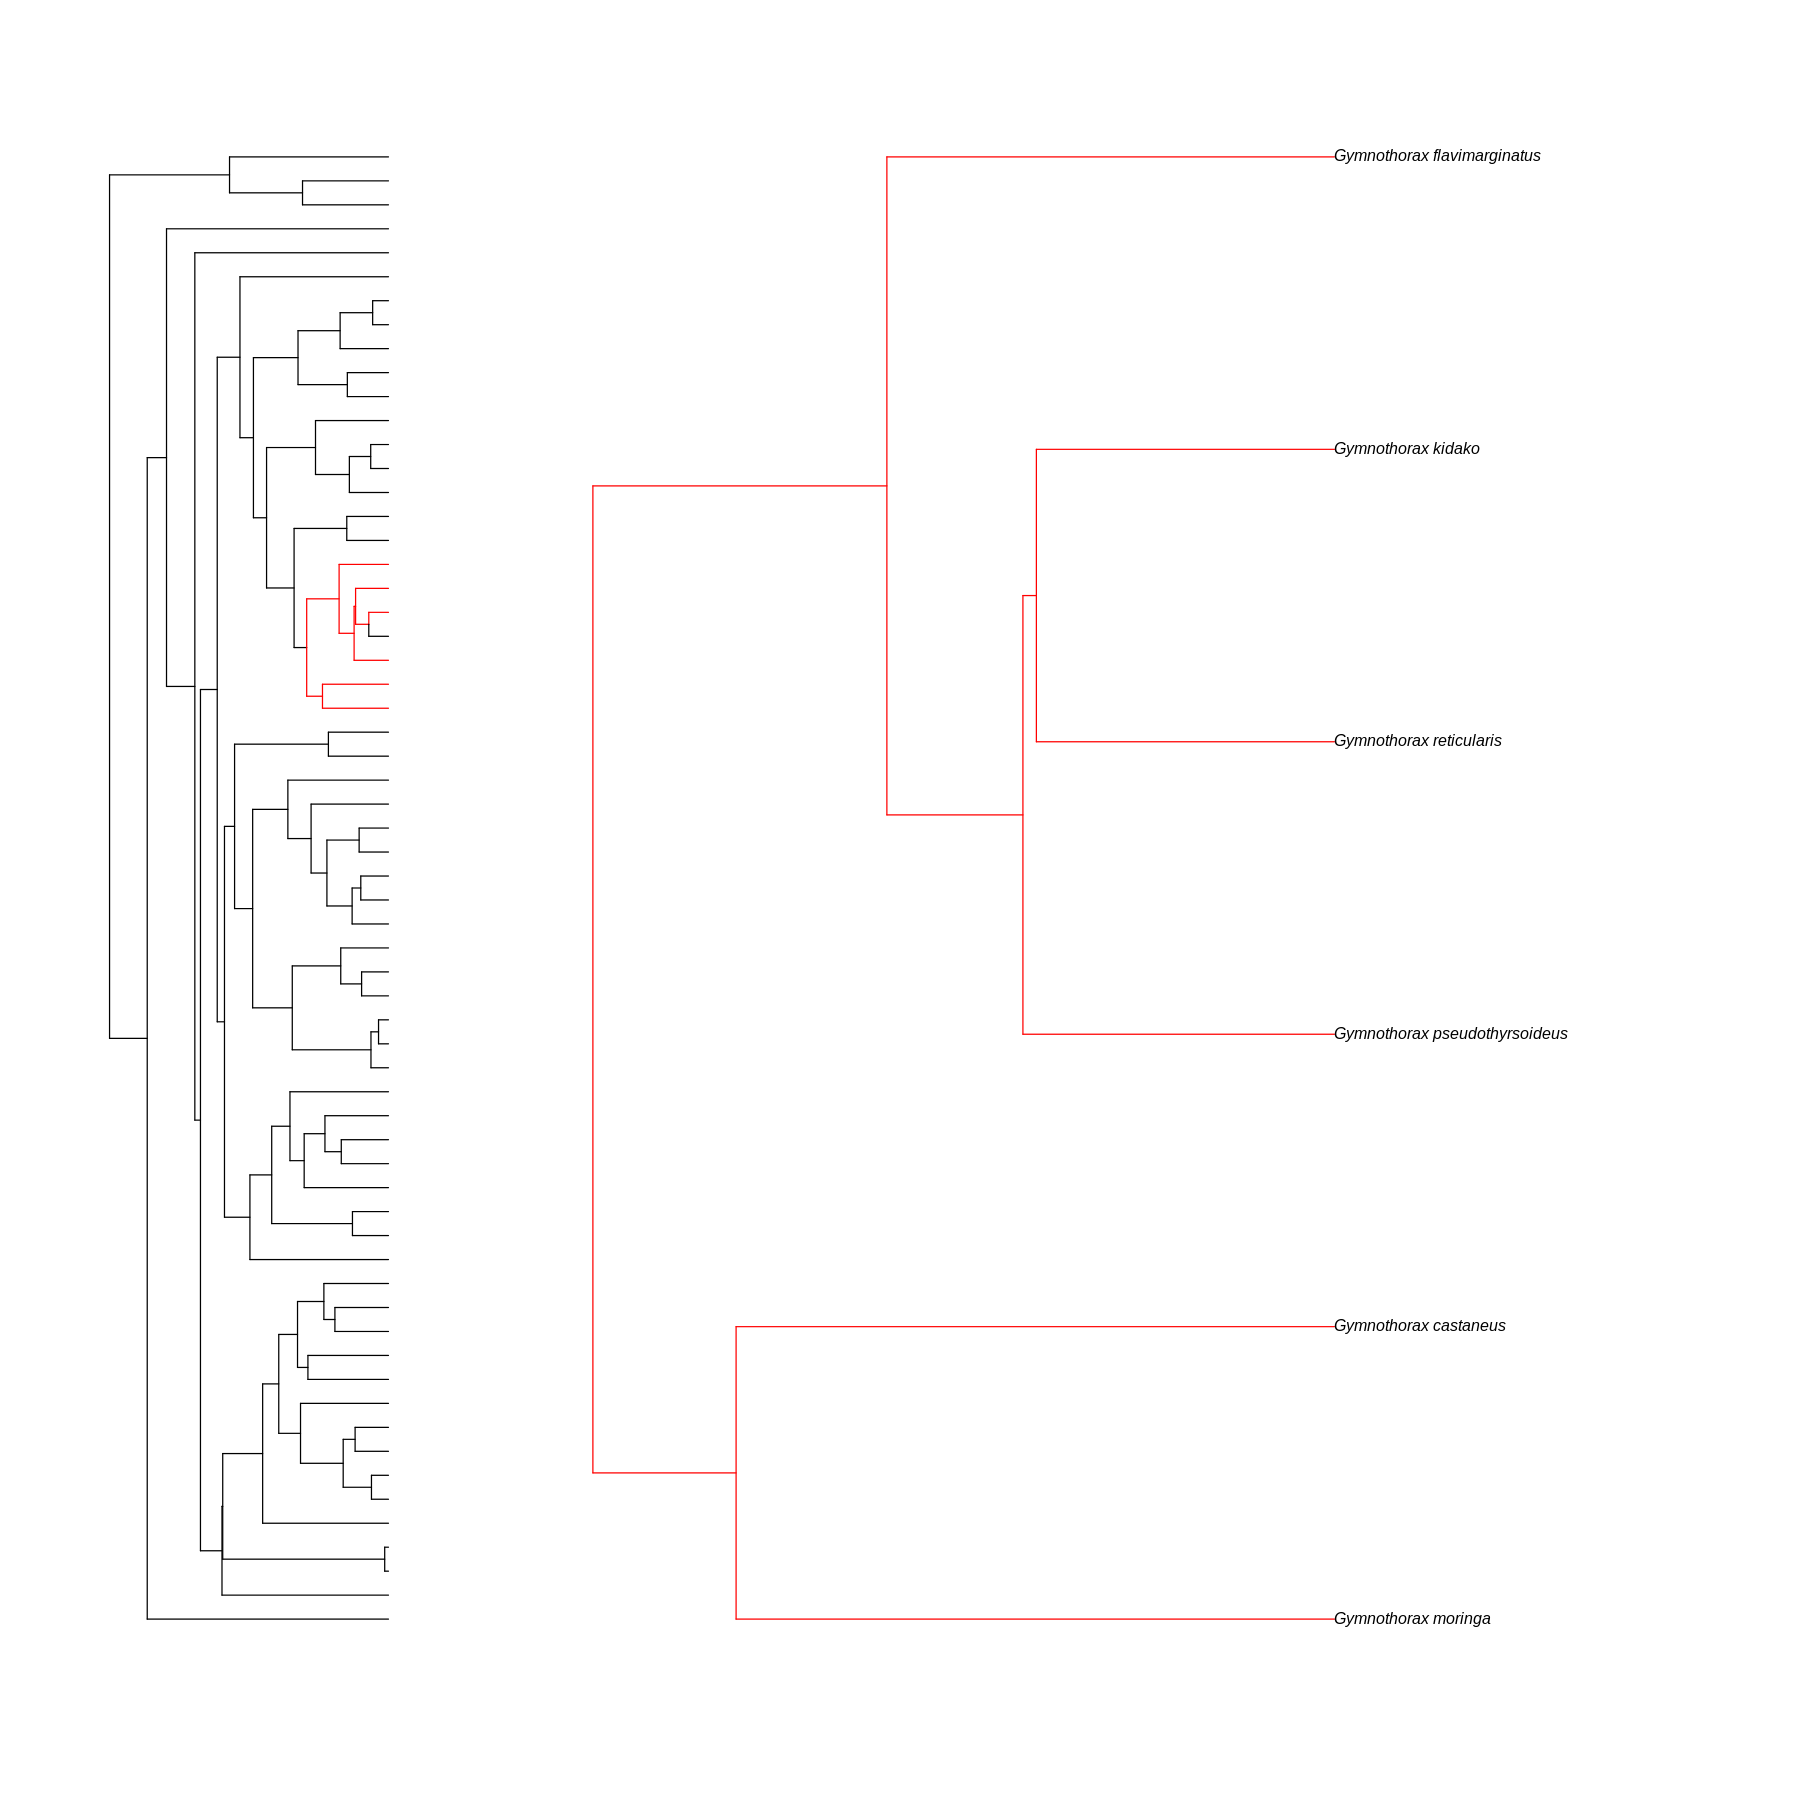

In [63]:
zoom(fishtree, grep("Gymnothorax", fishtree$tip.label), subtree = FALSE, cex = 0.8)

The `grep` function is a generic function in `R` that allows to *grab* any element in an object containing the desired characters.
In this example, `grep` is going to search for all the elements in `fishtree$tip.label` that contains `Gymnothorax` (e.g. `Gymnothorax_kidako`, `Gymnothorax_reticularis`).
Try using only `grep("thorax", fishtree$tip.label)` to see if it also only selects the members of the *Gymnothorax* genus.

In this example, we just display the tree for the *Gymnothorax* genus but you can also see how the species fit into the rest of the tree using:


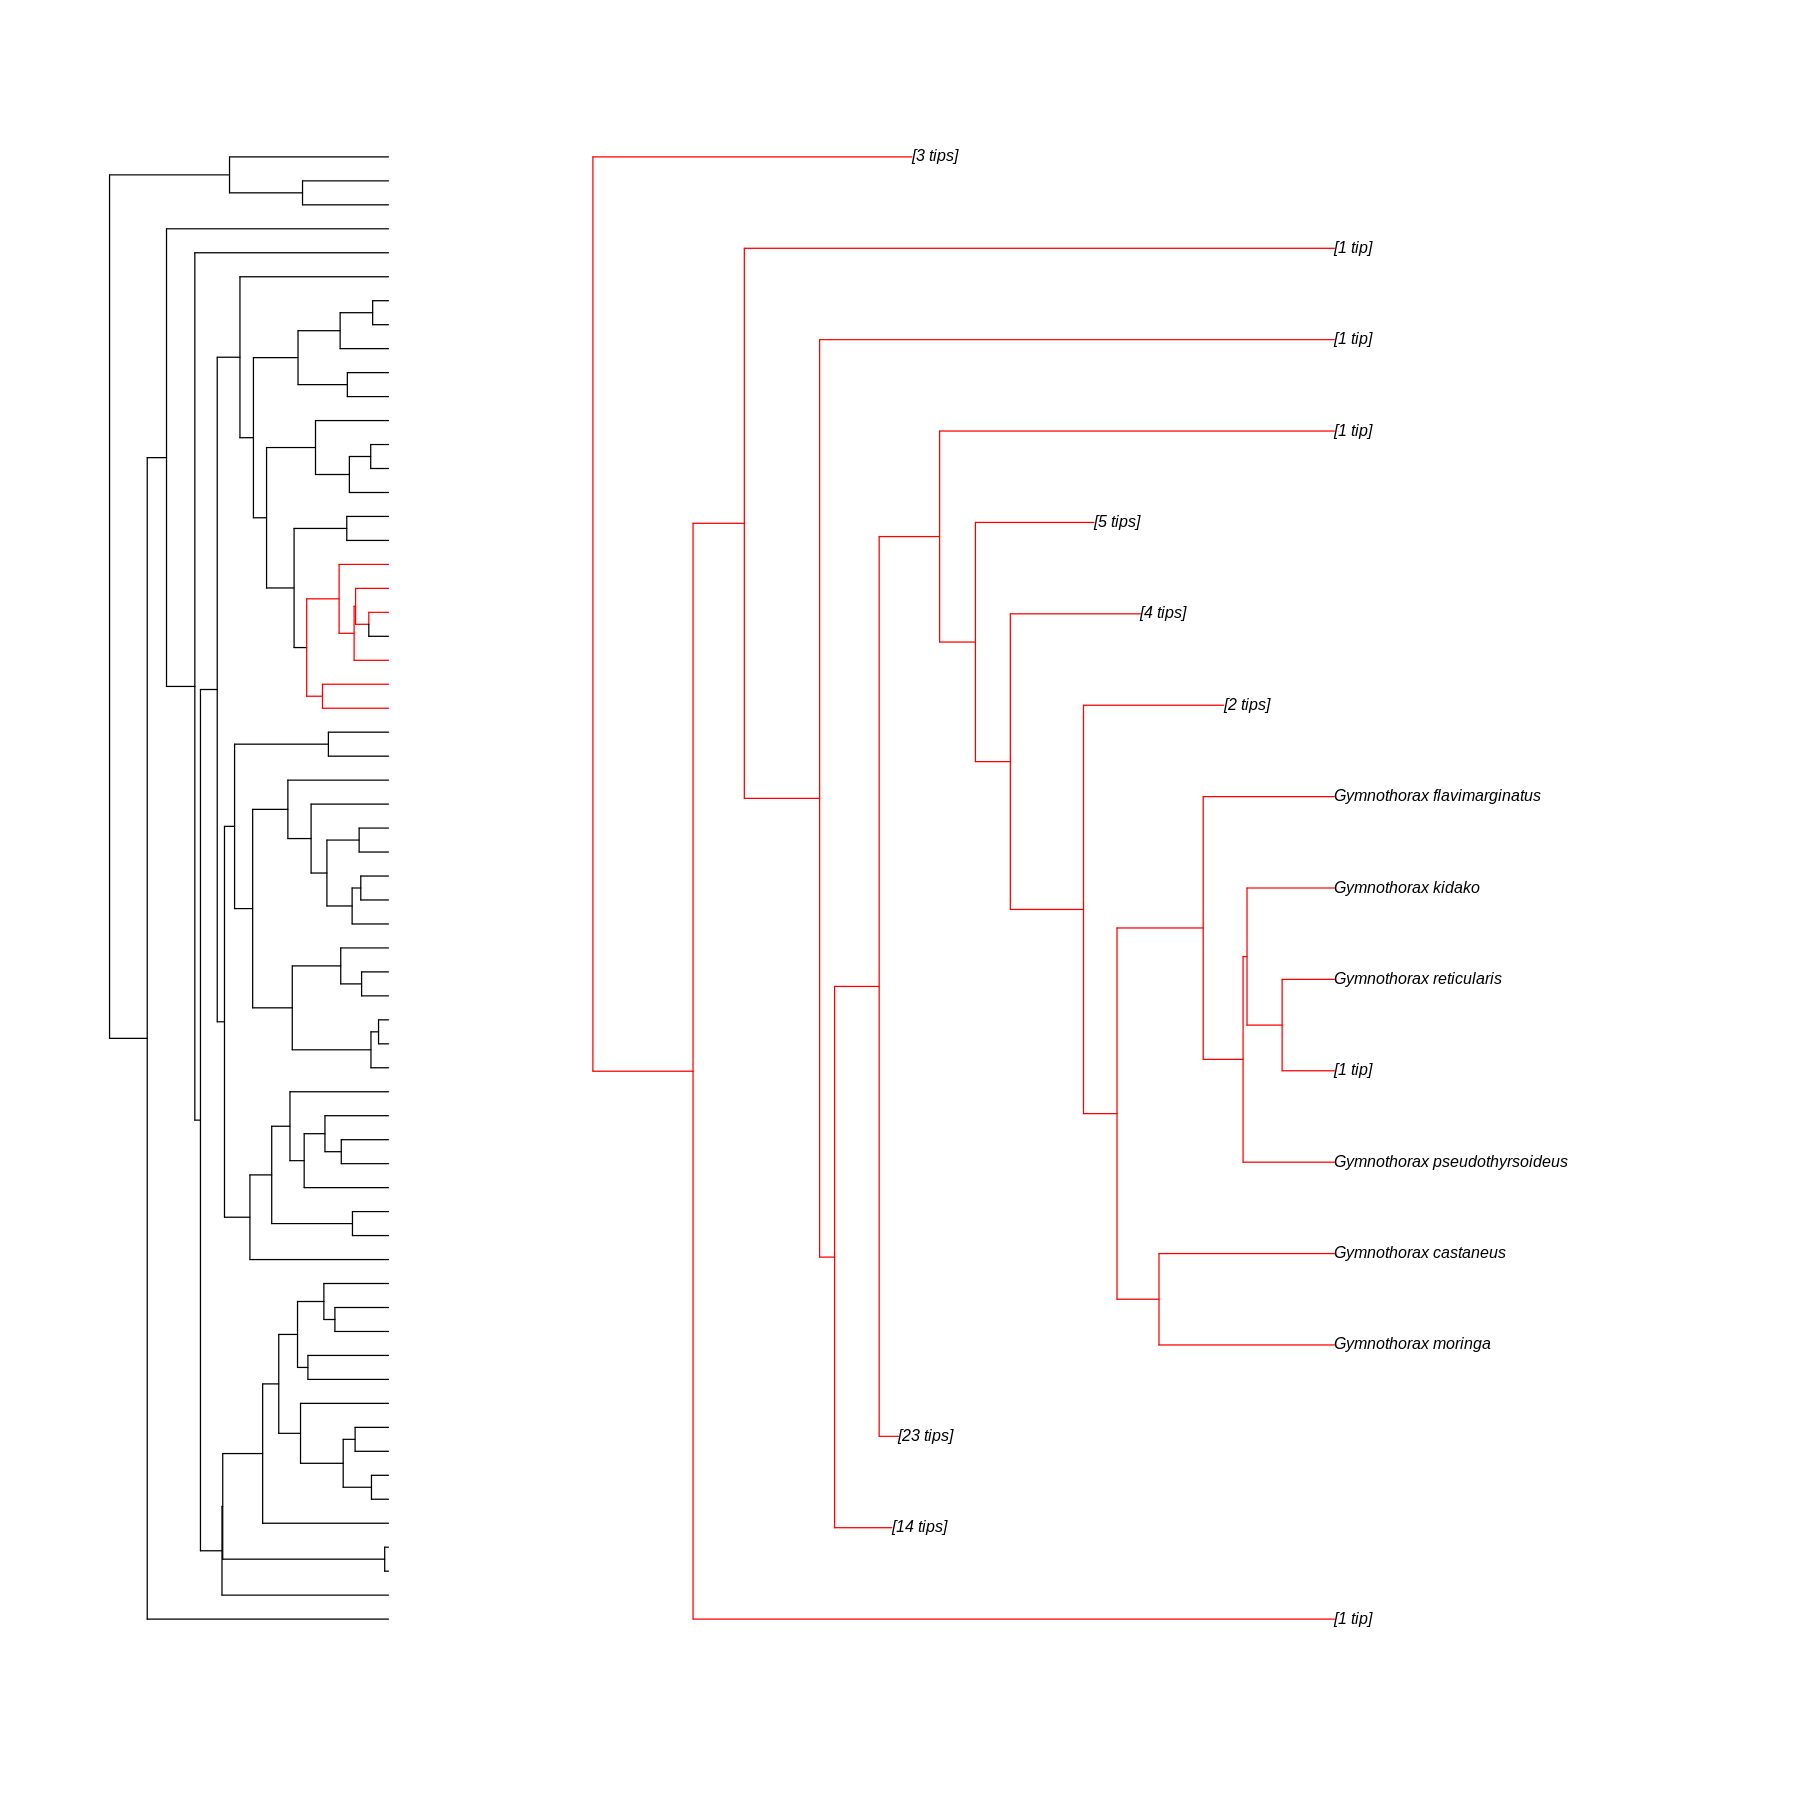

In [64]:
zoom(fishtree, grep("Gymnothorax", fishtree$tip.label), subtree = TRUE, cex = 0.8)

Note that `zoom` is a specific plotting function that will automatically set the plotting window to display two plots at once. This might create some conflicts if you're using RStudio. The bug can be easily solved though by typing `dev.off()` to reinitialise the plotting window and then proceed to the normal `zoom(...)` function as written above.

You can also reset this to one plot only per window by using:


In [65]:
par(mfrow = c(1, 1))

To get further options for the plotting of phylogenies:

In [66]:
?plot.phylo

Using the question mark (`?`) can also be done for every function if you want more details!

Note that although you can use `plot` to plot the phylogeny, you need to specify `plot.phylo` to find out the options for plotting trees. You can change the style of the tree (`type`), the color of the branches and tips (`edge.color`, `tip.color`), and the size of the tip labels (`cex`). 
Here's an fun/hideous example! 


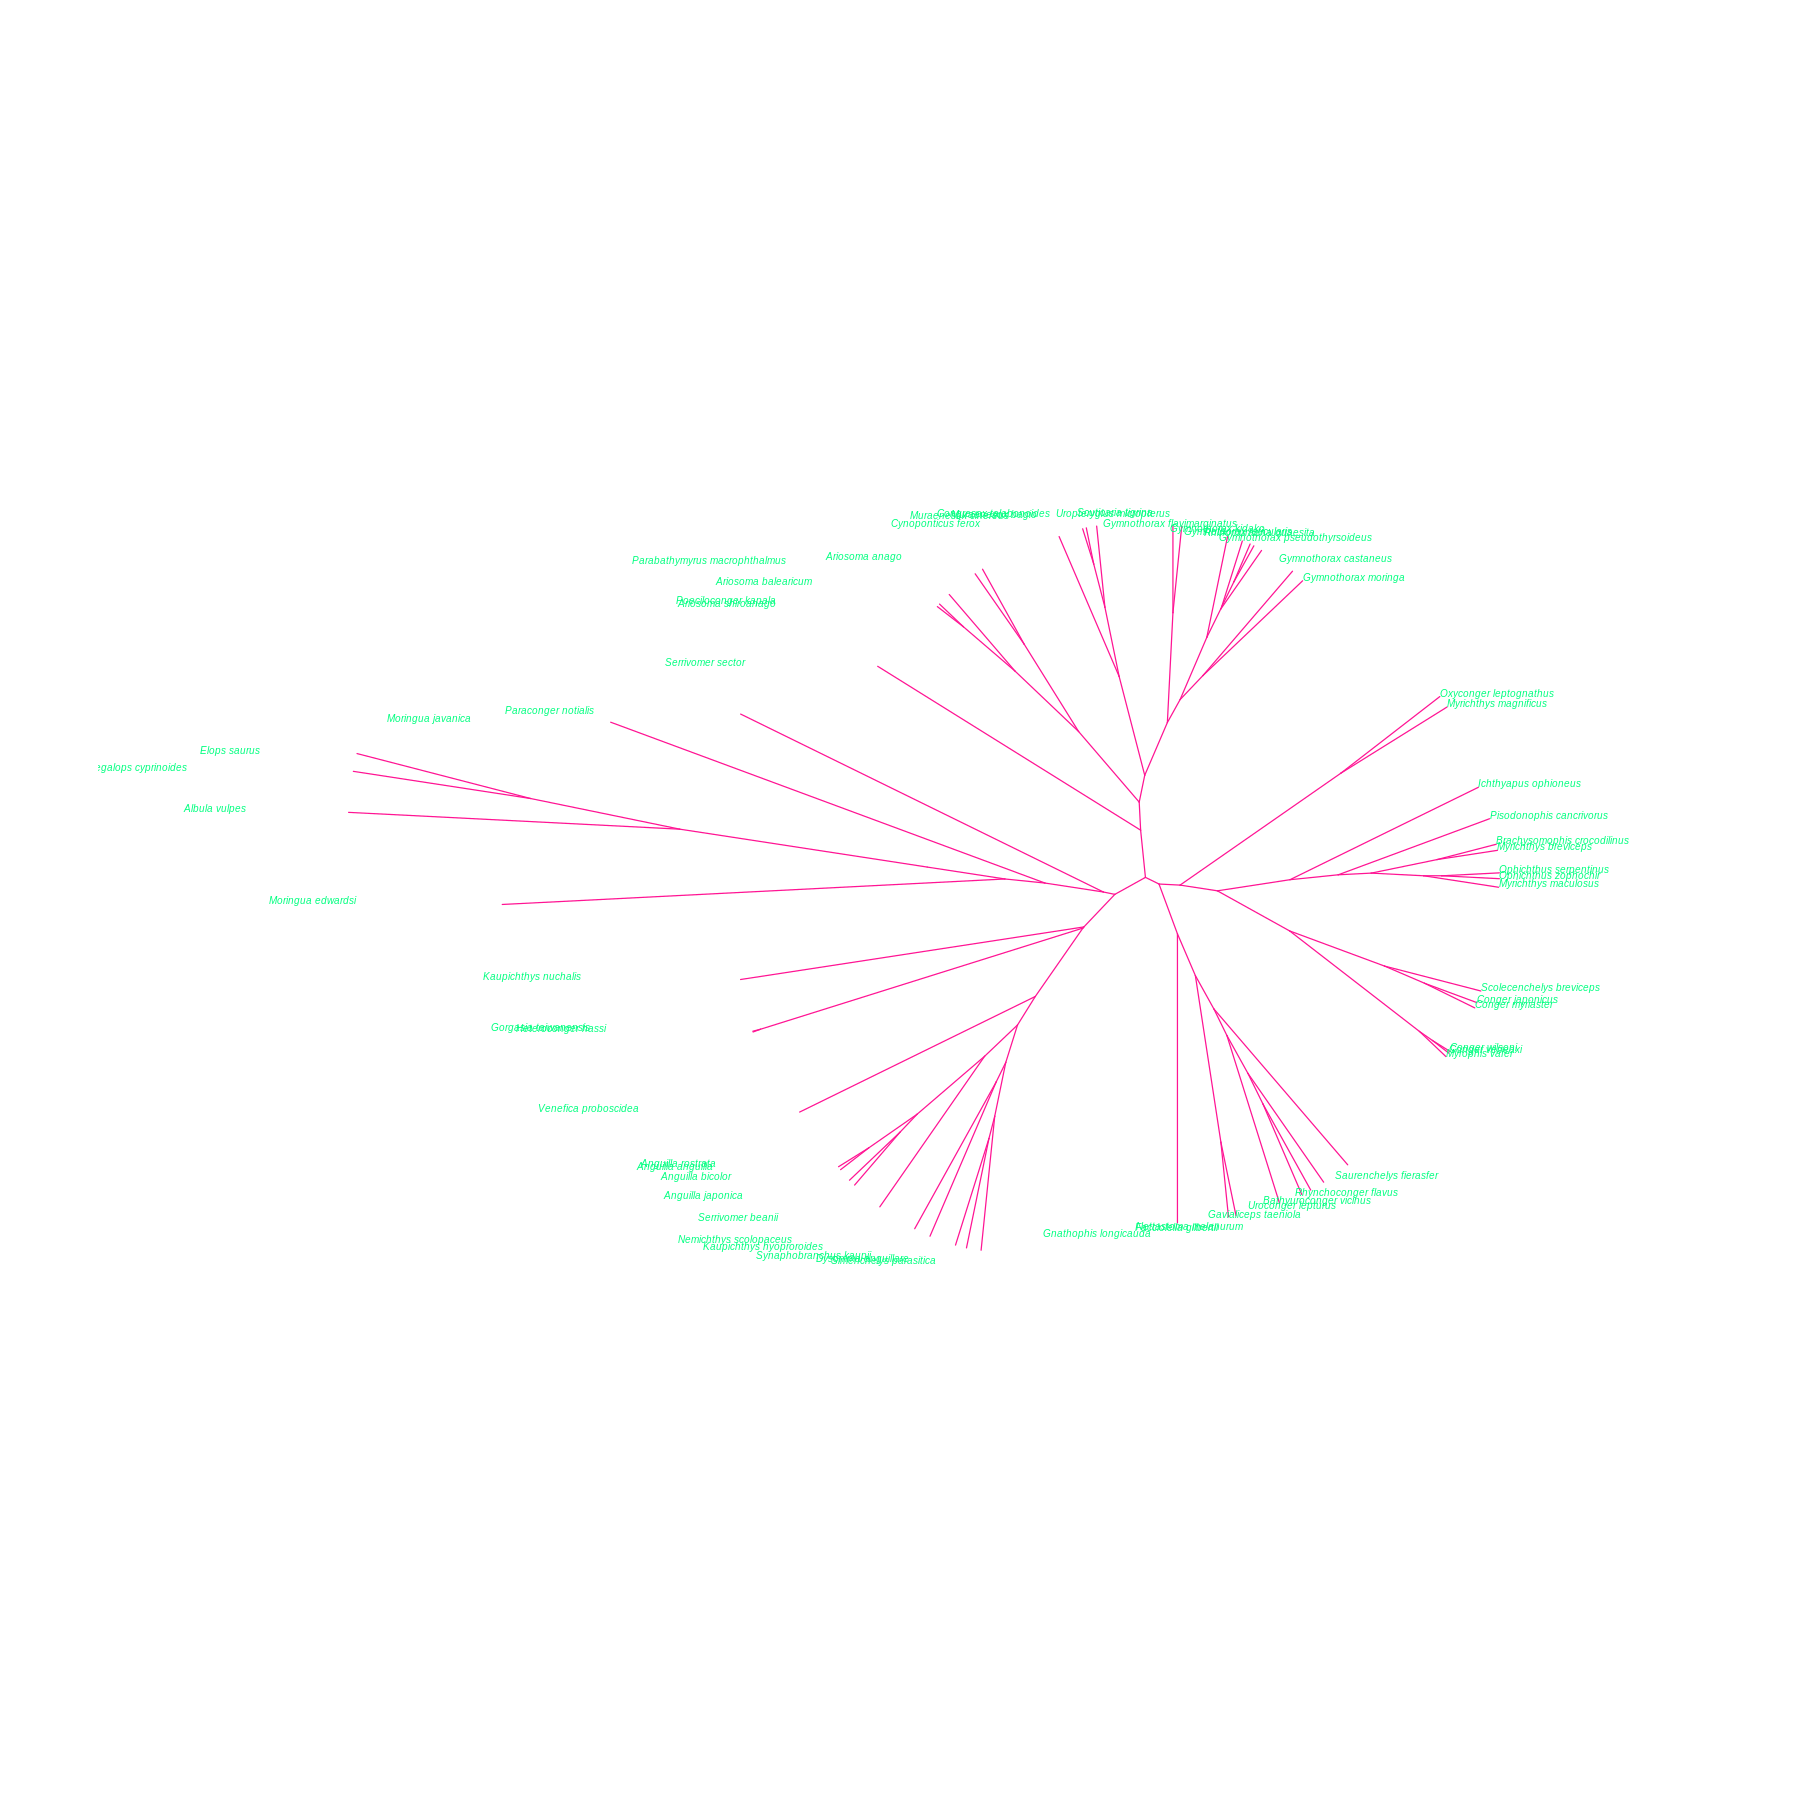

In [67]:
plot(fishtree, type = "unrooted", edge.color = "deeppink", tip.color = "springgreen",  cex = 0.5)

Or try

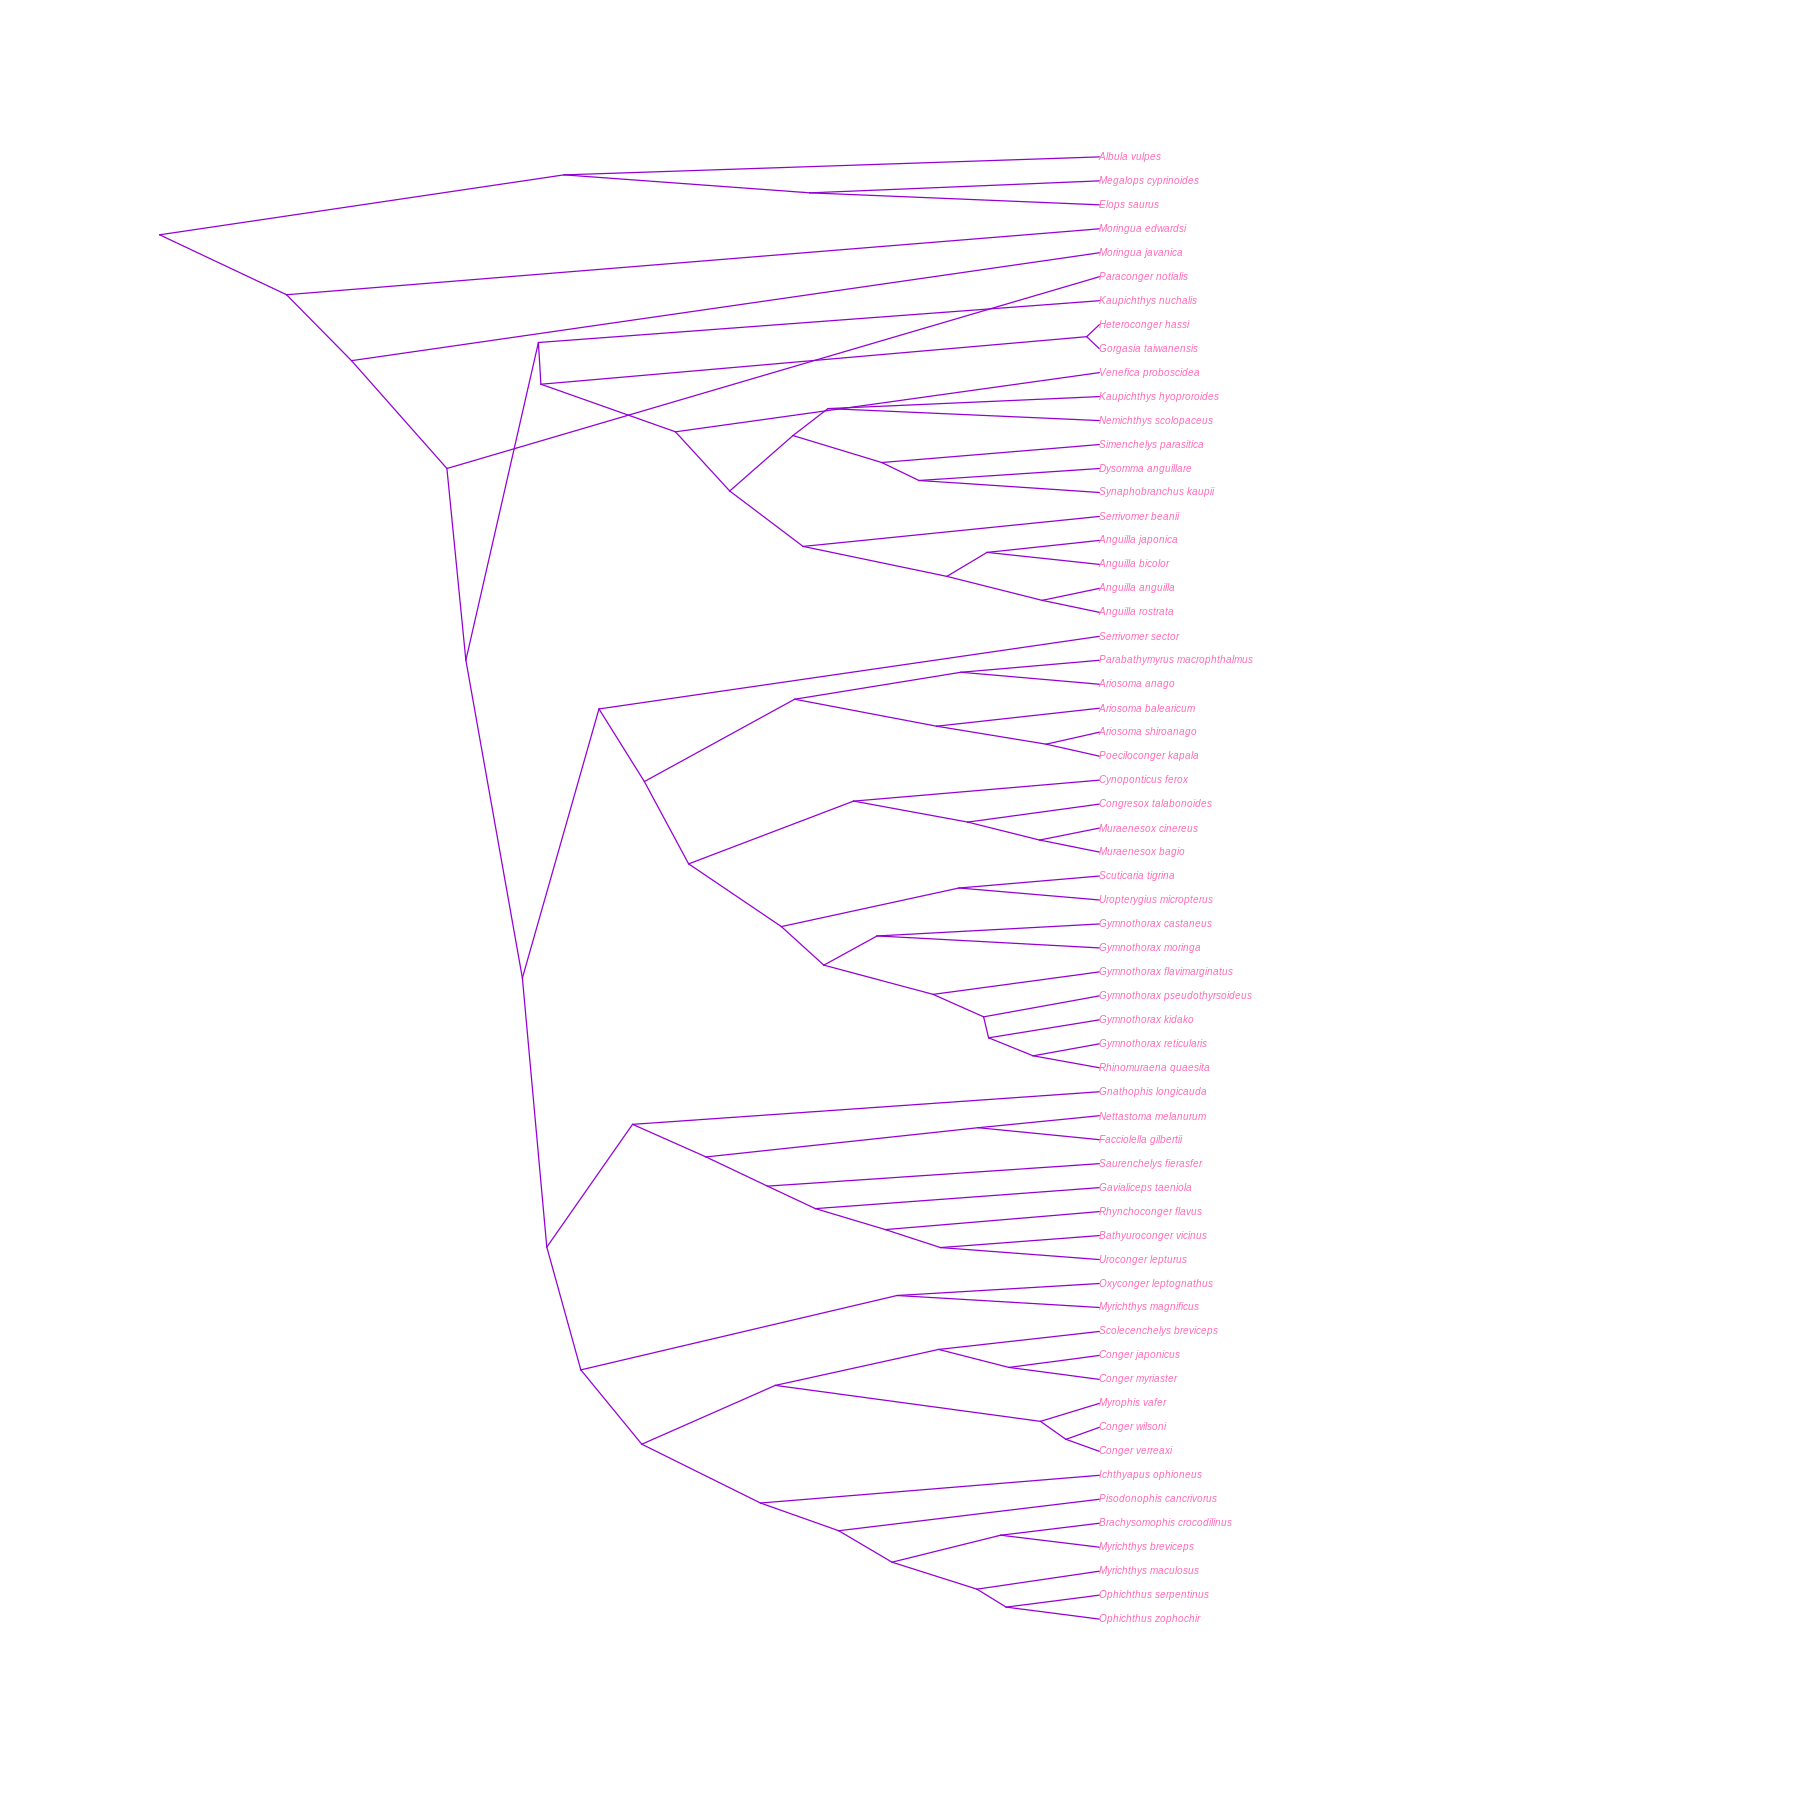

In [68]:
plot(ladderize(fishtree), type = "c", edge.color = "darkviolet", tip.color = "hotpink",  cex = 0.5)

The `ladderize` function allows to display the branches from shortest to longest.

> Try to modify the graphical options (colors, display, size, ordering of the nodes, etc.) to obtain the most beautiful or ugliest Elopomorpha phylogeny!

### 5. Manipulating phylogenetic trees in `R`

There are a range of ways in which we can manipulate trees in R. To start lets take a look at the bird family Turdidae.

In [69]:
Turdidae_tree <- read.nexus("Turdidae_birdtree.nex")

As this multiphylo object (i.e. contains 100 different trees) we need to first choose one random tree before we start.

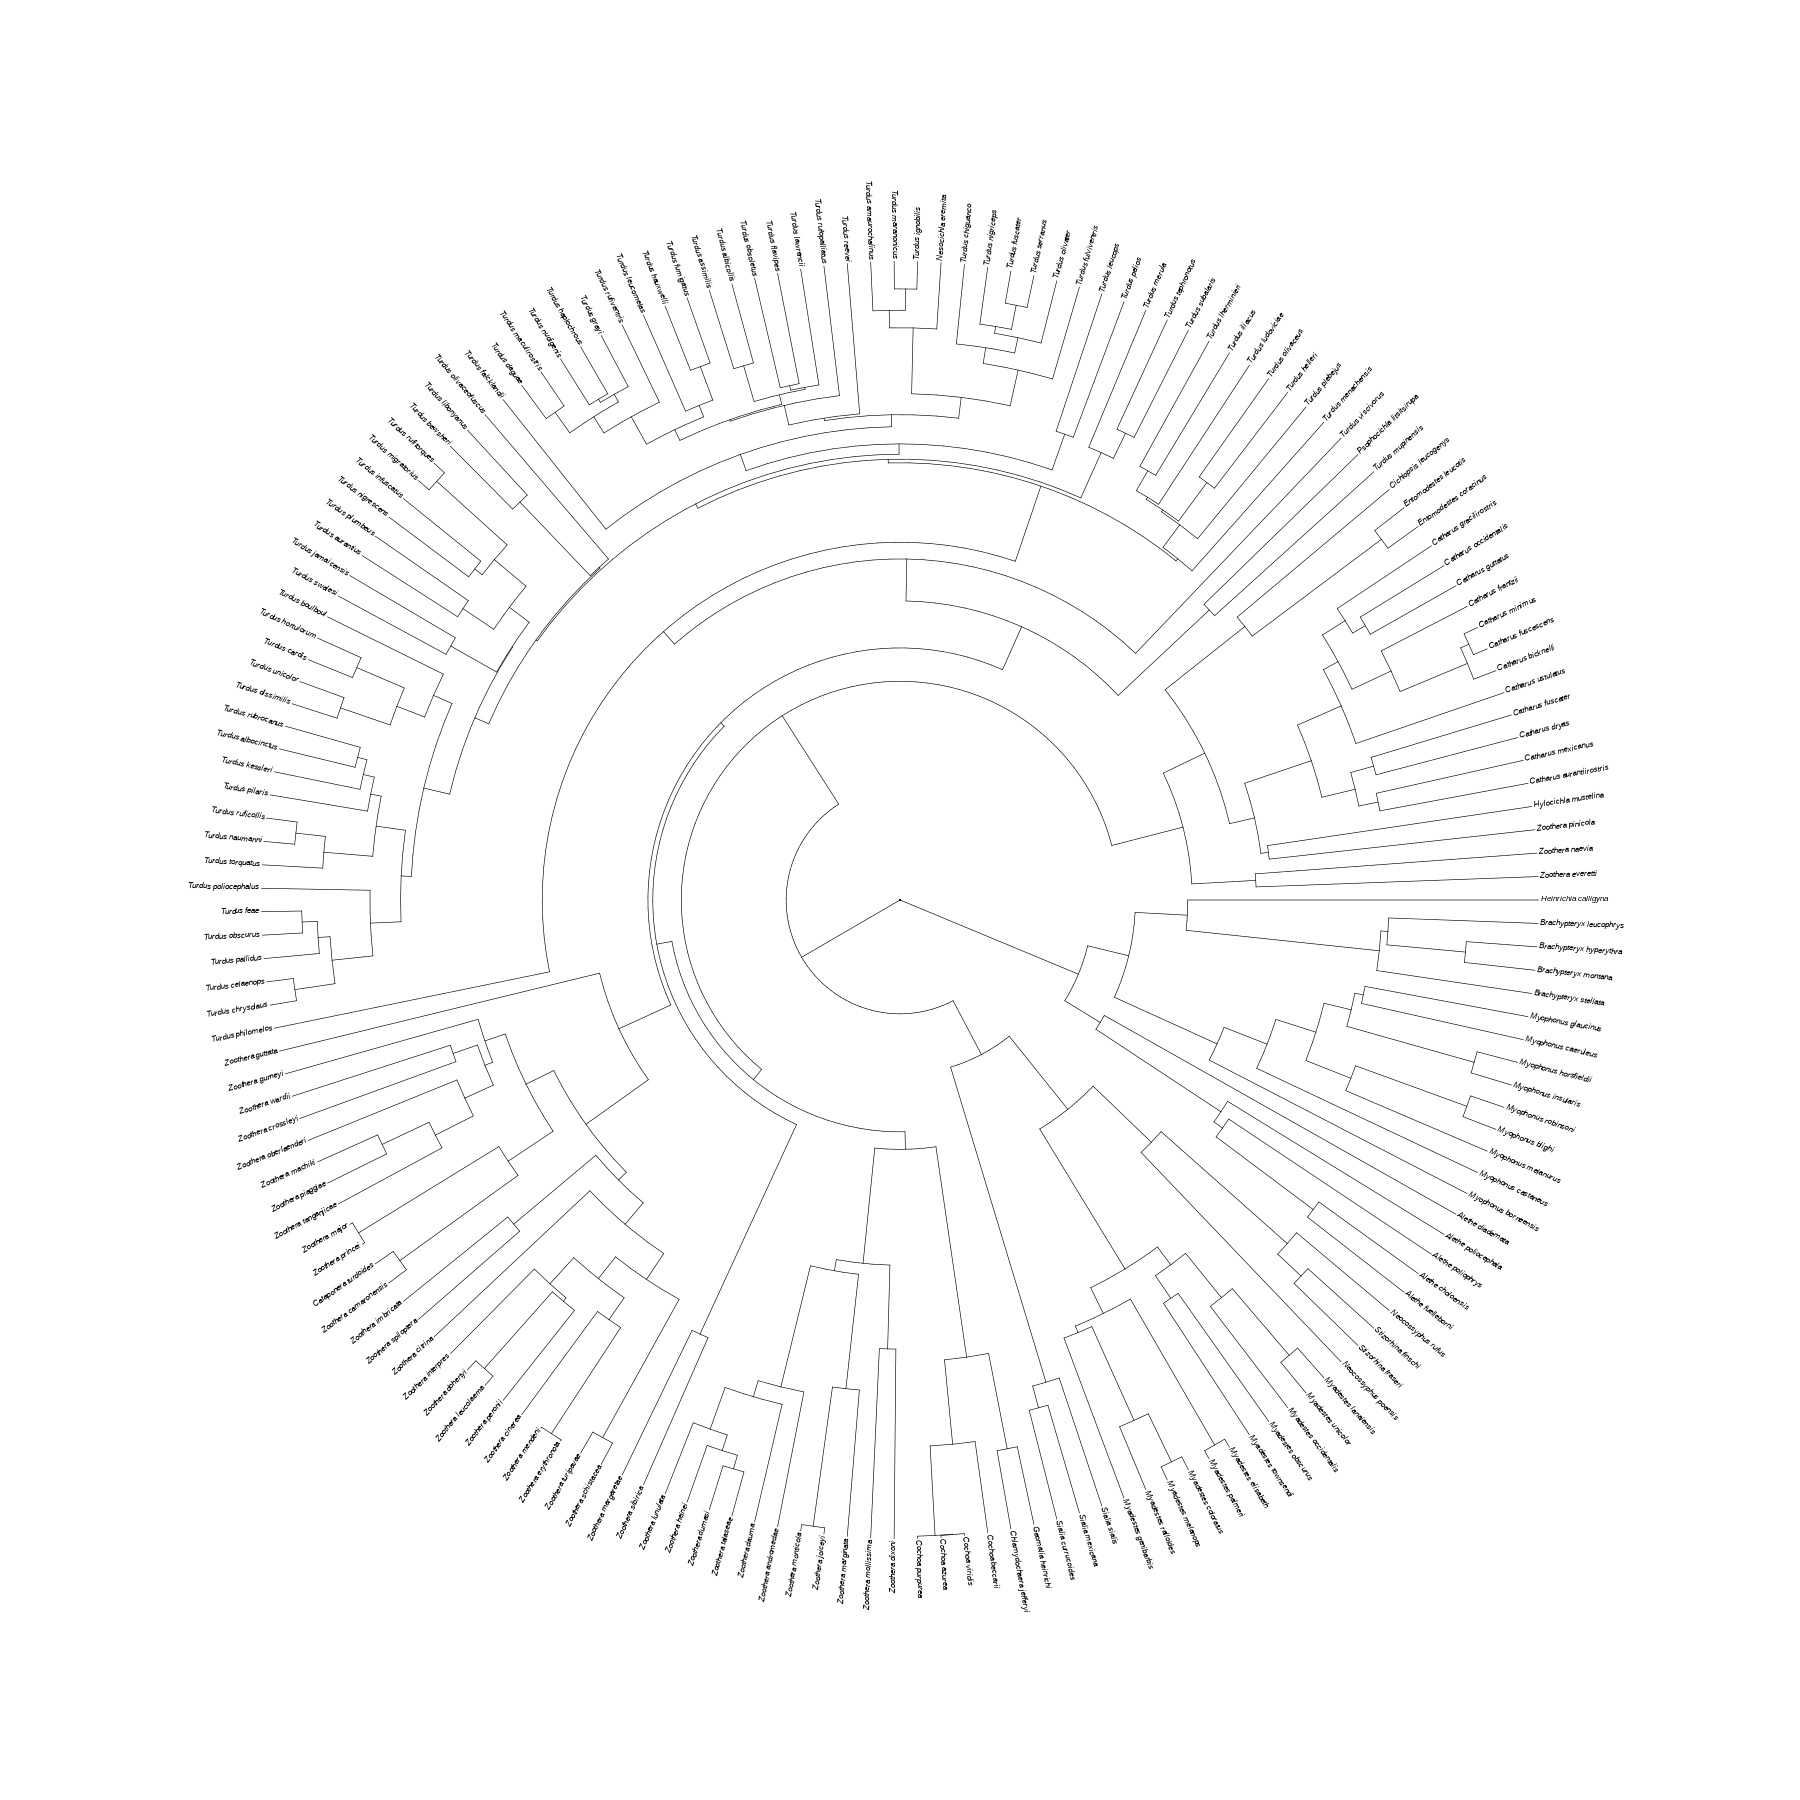

In [70]:
Ran_Turdidae_tree <- sample(Turdidae_tree,size=1)[[1]]
plotTree(Ran_Turdidae_tree,type="fan",fsize=0.4,lwd=0.5,ftype="i")

First, lets see what species are in the tree.

In [71]:
Ran_Turdidae_tree$tip.label

[1] "Zoothera_everetti"         "Zoothera_naevia"          
  [3] "Zoothera_pinicola"         "Hylocichla_mustelina"     
  [5] "Catharus_aurantiirostris"  "Catharus_mexicanus"       
  [7] "Catharus_dryas"            "Catharus_fuscater"        
  [9] "Catharus_ustulatus"        "Catharus_bicknelli"       
 [11] "Catharus_fuscescens"       "Catharus_minimus"         
 [13] "Catharus_frantzii"         "Catharus_guttatus"        
 [15] "Catharus_occidentalis"     "Catharus_gracilirostris"  
 [17] "Entomodestes_coracinus"    "Entomodestes_leucotis"    
 [19] "Cichlopsis_leucogenys"     "Turdus_mupinensis"        
 [21] "Psophocichla_litsitsirupa" "Turdus_viscivorus"        
 [23] "Turdus_menachensis"        "Turdus_plebejus"          
 [25] "Turdus_helleri"            "Turdus_olivaceus"         
 [27] "Turdus_ludoviciae"         "Turdus_iliacus"           
 [29] "Turdus_lherminieri"        "Turdus_subalaris"         
 [31] "Turdus_tephronotus"        "Turdus_merula"            
 [33] "Turdus_pelios"             "Turdus_leucops"           
 [35] "Turdus_fulviventris"       "Turdus_olivater"          
 [37] "Turdus_serranus"           "Turdus_fuscater"          
 [39] "Turdus_nigriceps"          "Turdus_chiguanco"         
 [41] "Nesocichla_eremita"        "Turdus_ignobilis"         
 [43] "Turdus_maranonicus"        "Turdus_amaurochalinus"    
 [45] "Turdus_reevei"             "Turdus_rufopalliatus"     
 [47] "Turdus_lawrencii"          "Turdus_flavipes"          
 [49] "Turdus_obsoletus"          "Turdus_albicollis"        
 [51] "Turdus_assimilis"          "Turdus_fumigatus"         
 [53] "Turdus_hauxwelli"          "Turdus_leucomelas"        
 [55] "Turdus_rufiventris"        "Turdus_grayi"             
 [57] "Turdus_haplochrous"        "Turdus_nudigenis"         
 [59] "Turdus_maculirostris"      "Turdus_daguae"            
 [61] "Turdus_falcklandii"        "Turdus_olivaceofuscus"    
 [63] "Turdus_libonyanus"         "Turdus_bewsheri"          
 [65] "Turdus_rufitorques"        "Turdus_migratorius"       
 [67] "Turdus_infuscatus"         "Turdus_nigrescens"        
 [69] "Turdus_plumbeus"           "Turdus_aurantius"         
 [71] "Turdus_jamaicensis"        "Turdus_swalesi"           
 [73] "Turdus_boulboul"           "Turdus_hortulorum"        
 [75] "Turdus_cardis"             "Turdus_unicolor"          
 [77] "Turdus_dissimilis"         "Turdus_rubrocanus"        
 [79] "Turdus_albocinctus"        "Turdus_kessleri"          
 [81] "Turdus_pilaris"            "Turdus_ruficollis"        
 [83] "Turdus_naumanni"           "Turdus_torquatus"         
 [85] "Turdus_poliocephalus"      "Turdus_feae"              
 [87] "Turdus_obscurus"           "Turdus_pallidus"          
 [89] "Turdus_celaenops"          "Turdus_chrysolaus"        
 [91] "Turdus_philomelos"         "Zoothera_guttata"         
 [93] "Zoothera_gurneyi"          "Zoothera_wardii"          
 [95] "Zoothera_crossleyi"        "Zoothera_oberlaenderi"    
 [97] "Zoothera_machiki"          "Zoothera_piaggiae"        
 [99] "Zoothera_tanganjicae"      "Zoothera_major"           
[101] "Zoothera_princei"          "Cataponera_turdoides"     
[103] "Zoothera_camaronensis"     "Zoothera_imbricata"       
[105] "Zoothera_spiloptera"       "Zoothera_citrina"         
[107] "Zoothera_interpres"        "Zoothera_dohertyi"        
[109] "Zoothera_leucolaema"       "Zoothera_peronii"         
[111] "Zoothera_cinerea"          "Zoothera_mendeni"         
[113] "Zoothera_erythronota"      "Zoothera_turipavae"       
[115] "Zoothera_schistacea"       "Zoothera_margaretae"      
[117] "Zoothera_sibirica"         "Zoothera_lunulata"        
[119] "Zoothera_heinei"           "Zoothera_dumasi"          
[121] "Zoothera_talaseae"         "Zoothera_dauma"           
[123] "Zoothera_andromedae"       "Zoothera_monticola"       
[125] "Zoothera_joiceyi"          "Zoothera_marginata"       
[127] "Zoothera_mollissima"       "Zoothera_dixoni"          
[129] "Cochoa_purpurea"           

Lets say we want to drop all species with the Myadestes genus. In this instance we first find all the associated tip.labels. 

In [72]:
drop.species <- ("Myadestes")

# sapply is a function that will iterate a given function over a vector (check out apply, lapply, mapply for more info)
# in this case, we're using the grep function to find the index of anything in tip.labels that matches drop.species
selected.tips <- sapply(drop.species,grep,Ran_Turdidae_tree$tip.label)

# We then use the indices to select only the tips we want from all the available tip labels
drop.species <- Ran_Turdidae_tree$tip.label[selected.tips]
drop.species

[1] "Myadestes_genibarbis"   "Myadestes_ralloides"    "Myadestes_melanops"    
 [4] "Myadestes_coloratus"    "Myadestes_palmeri"      "Myadestes_elisabeth"   
 [7] "Myadestes_townsendi"    "Myadestes_obscurus"     "Myadestes_occidentalis"
[10] "Myadestes_unicolor"     "Myadestes_lanaiensis"

Now, we create a new tree, with the Myadestes tips dropped from it.

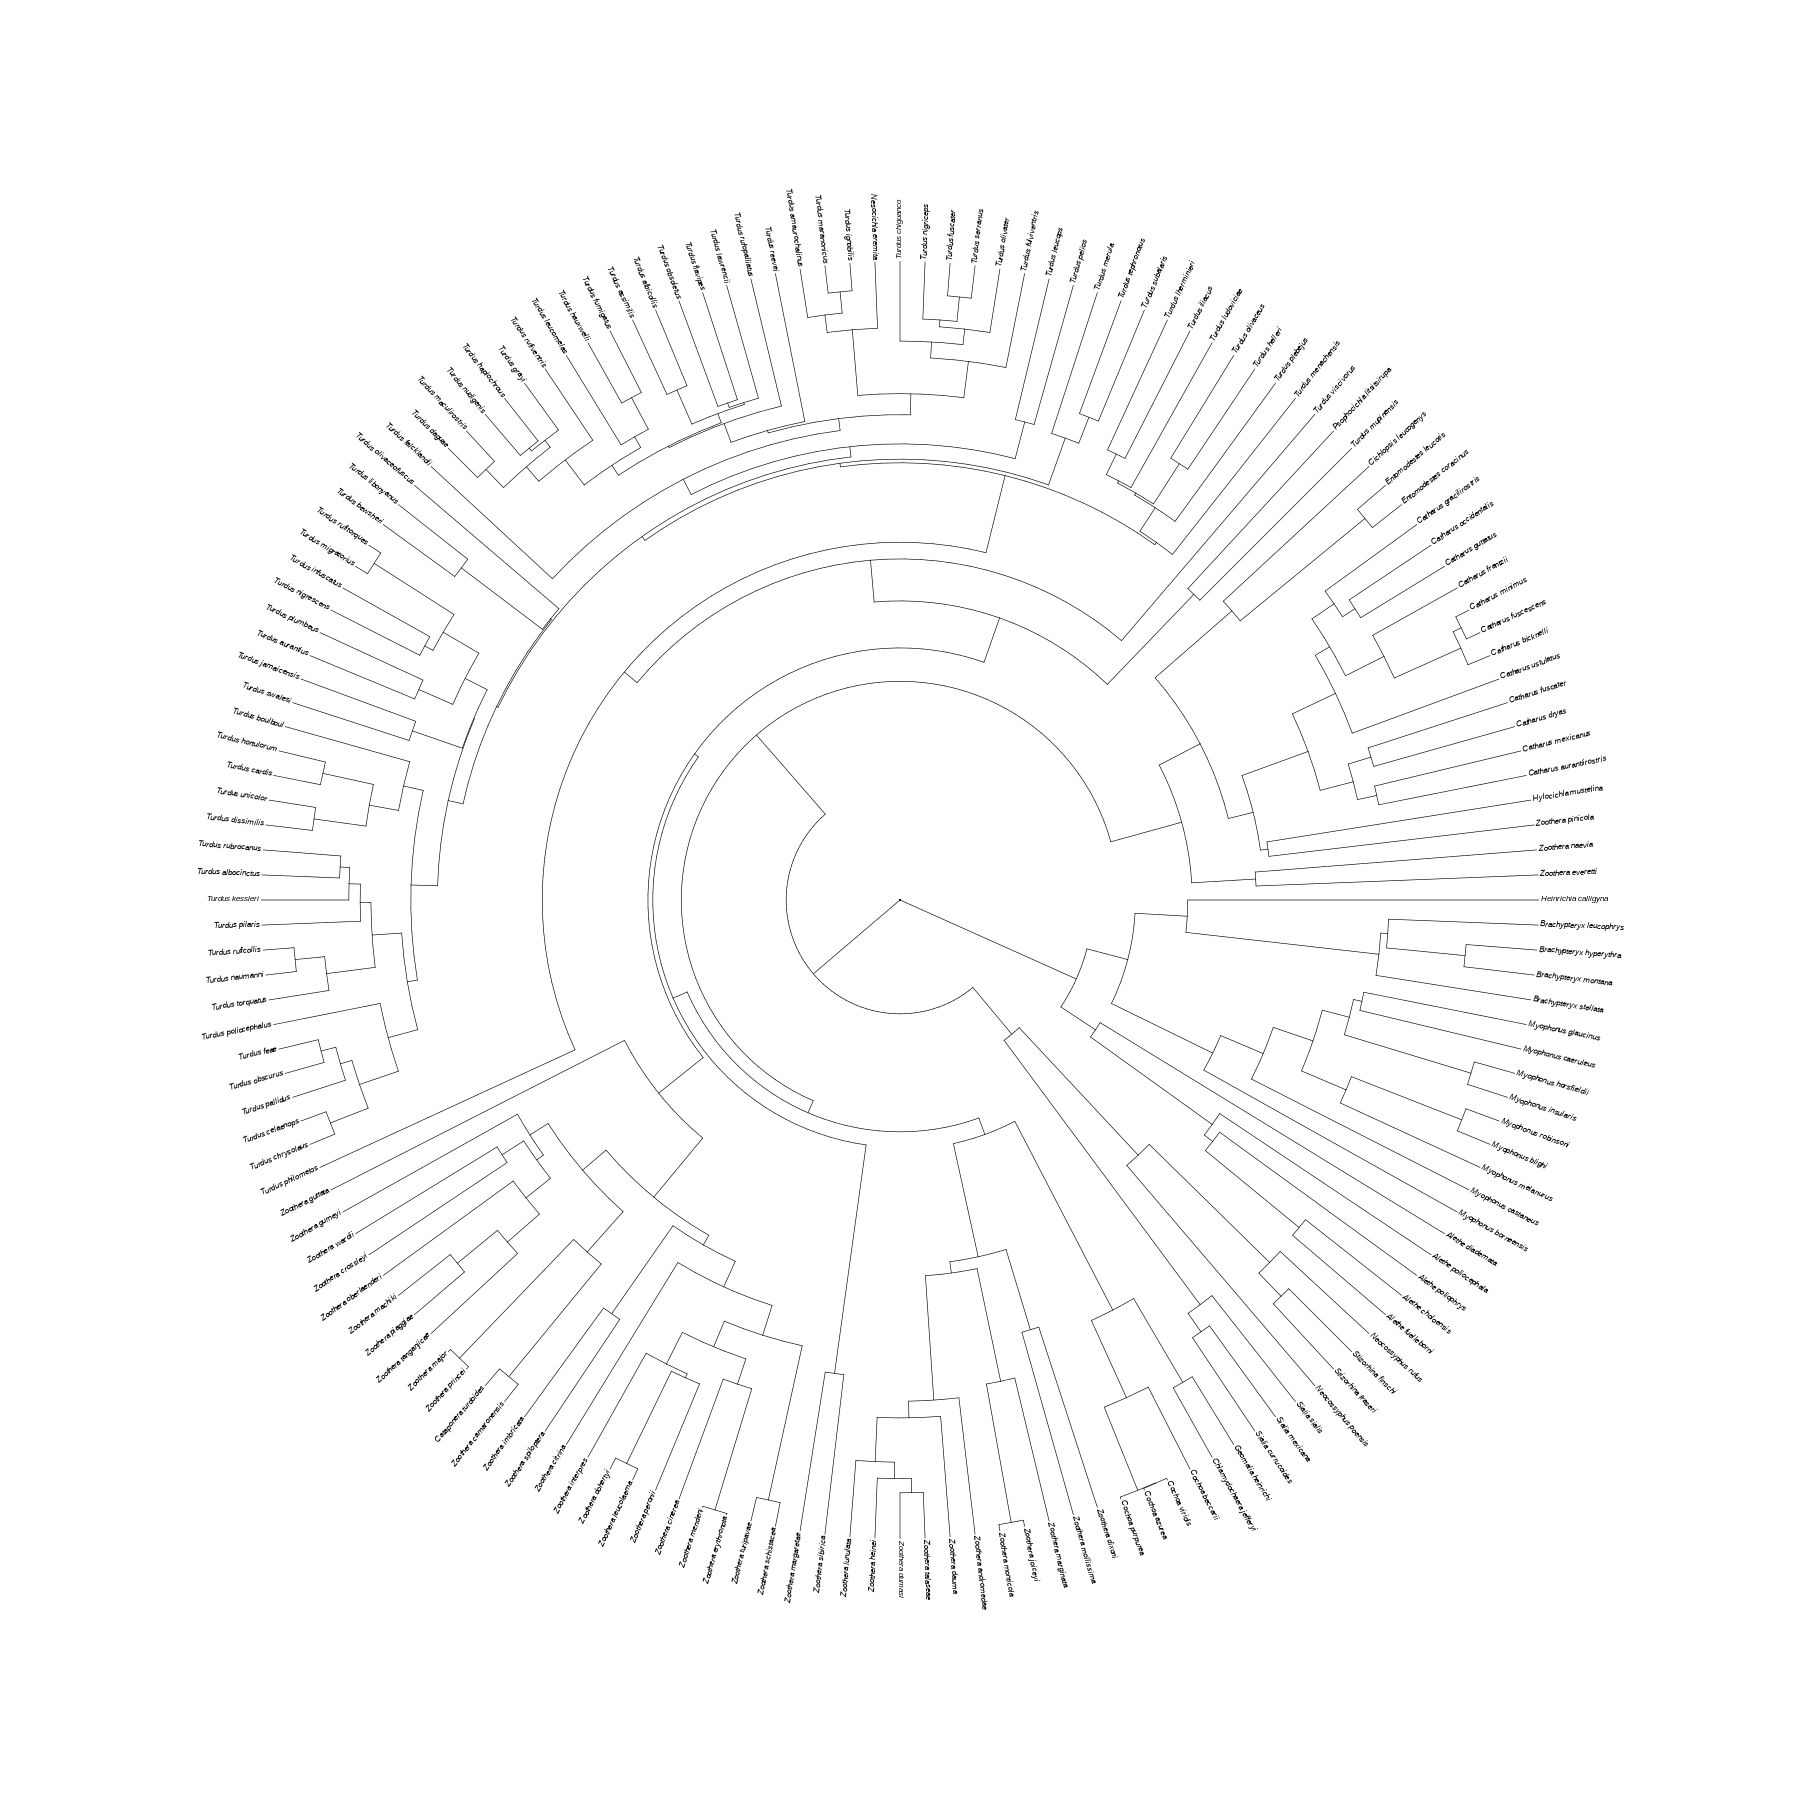

In [73]:
# drop.tip will remove any matching tips from the tree
Ran_Turdidae_tree_NM<-drop.tip(Ran_Turdidae_tree,drop.species)
plotTree(Ran_Turdidae_tree_NM,type="fan",fsize=0.4,lwd=0.5,ftype="i")

Alternatively, lets say we want to extract the clade within the tree that includes the pre identified selected range of species.

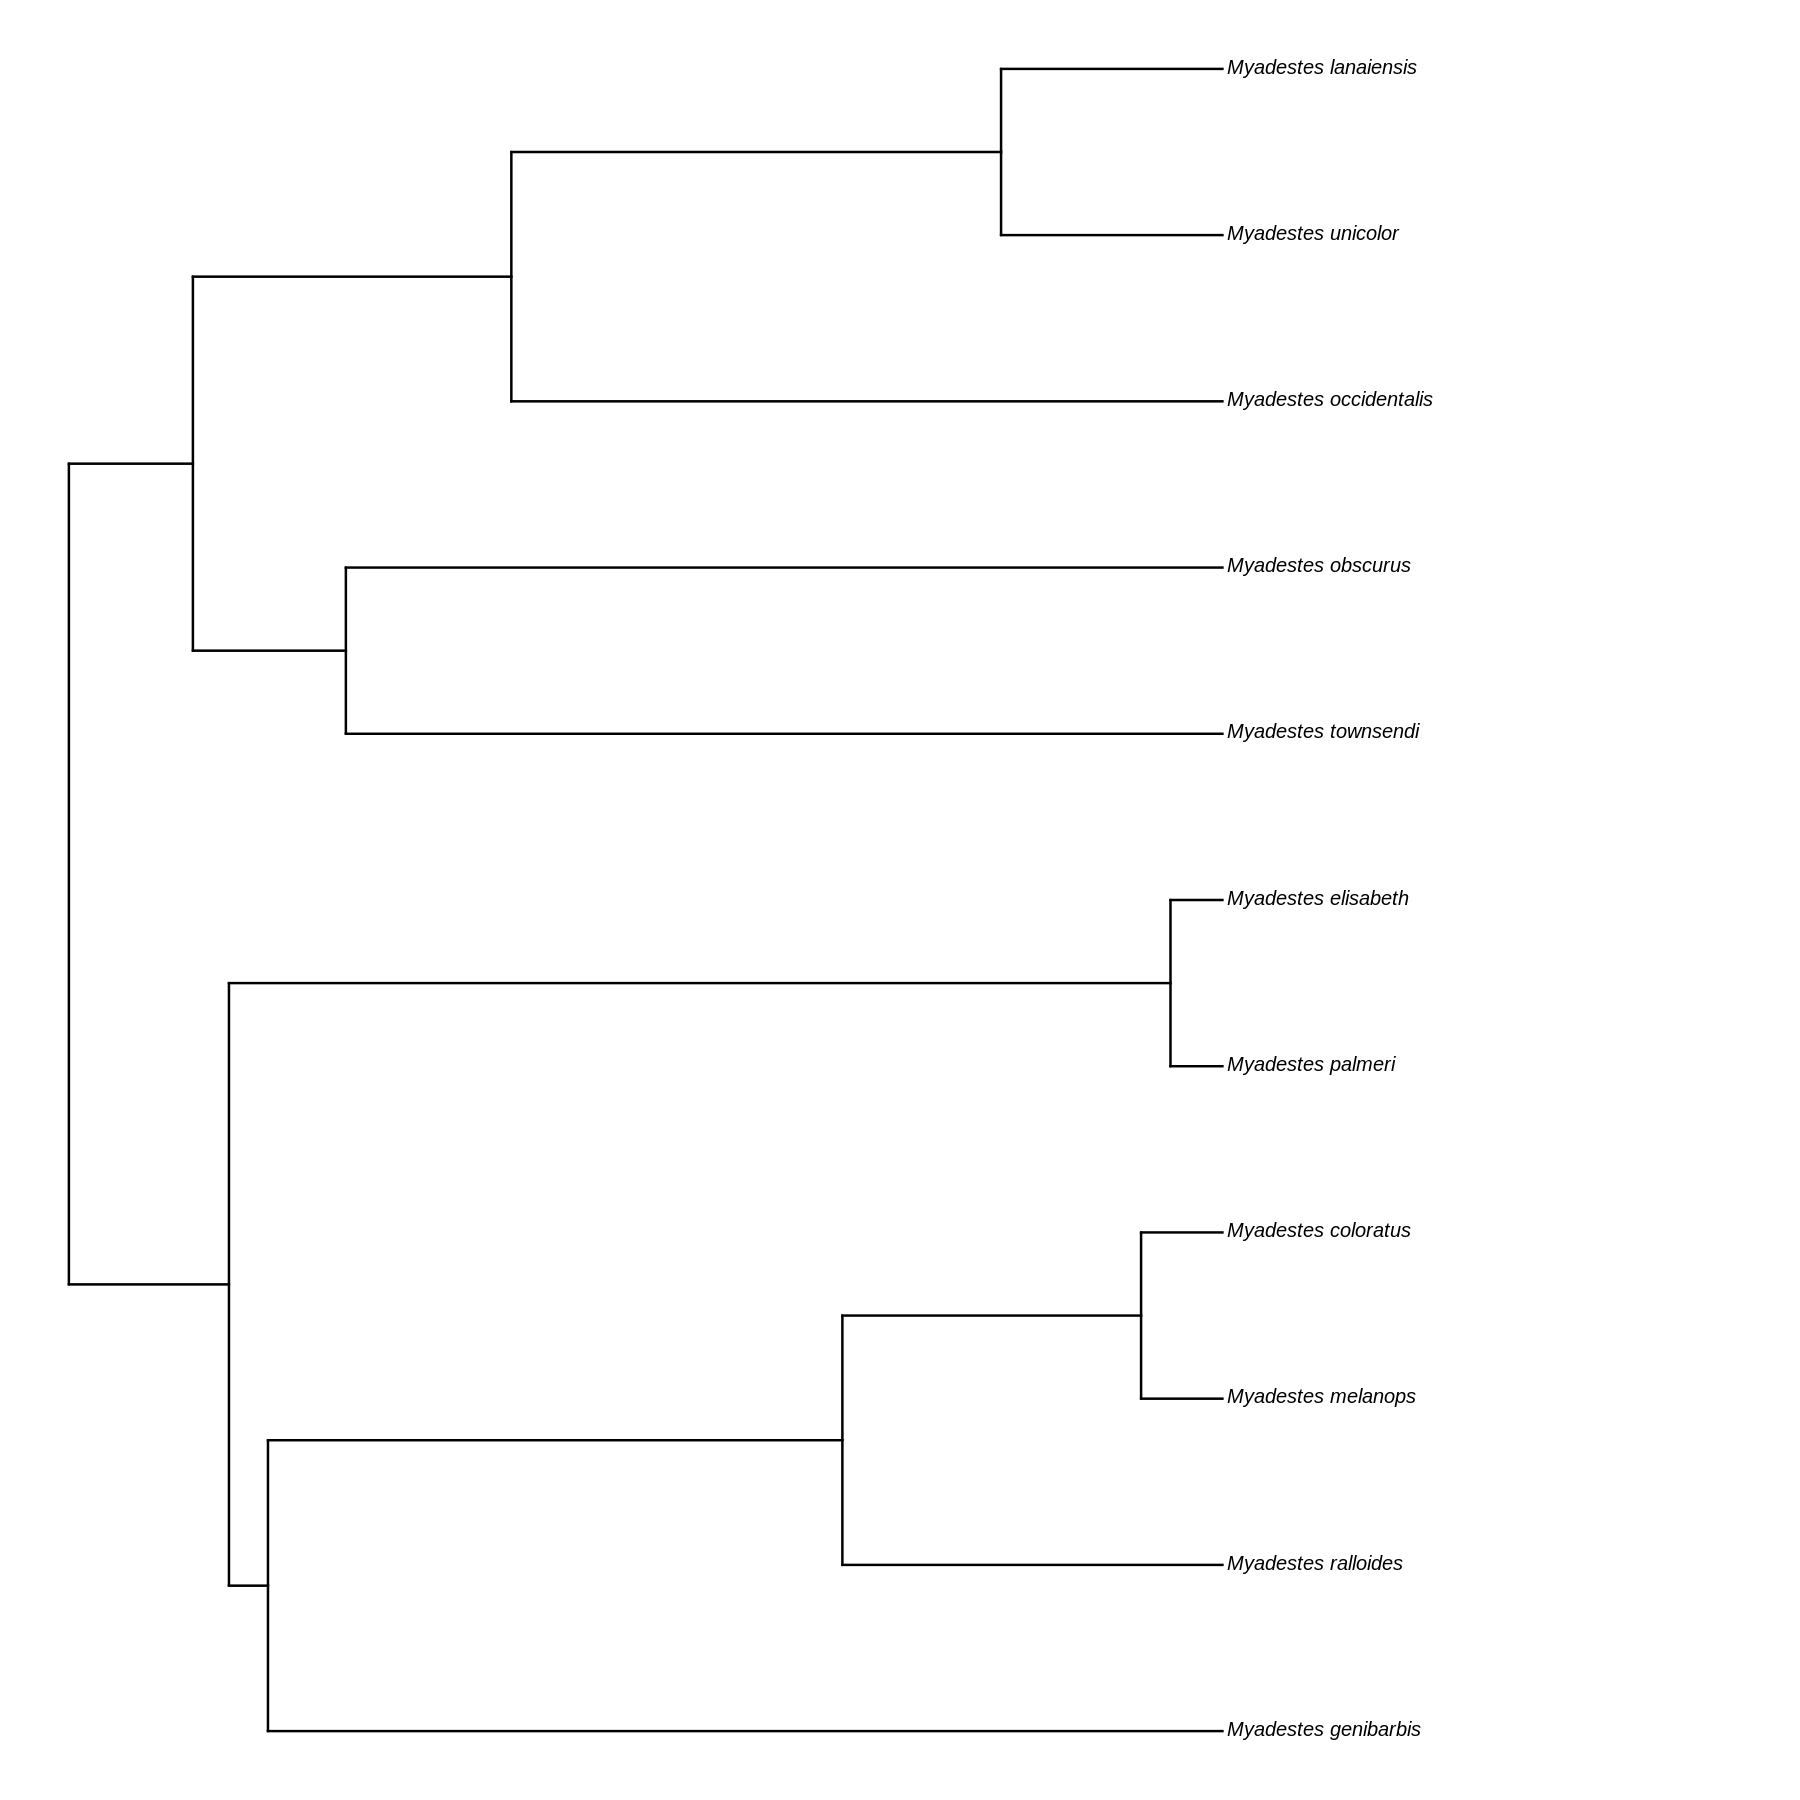

In [74]:
# Set diff will find all the tips that don't match drop.species, and then drop.tip will remove them
pruned_birdtree<-drop.tip(Ran_Turdidae_tree,
    setdiff(Ran_Turdidae_tree$tip.label,drop.species))
plotTree(pruned_birdtree,ftype="i")

**Remember, always to save your new revised tree. As this will save you time from having to prune it everytime. Use `write.tree` or `write.nexus` the same as you would to save a dataframe.**

For some analyses, you might want to work with on a genus level tree. This can easily be done by a few key steps. We can do this using base `R`, but we'll use some packages from the `tidyverse` that have some very useful functions. 
First load `stringr` (for manipulating strings) and `dplyr` (for manipulating dataframes). You'll see that it masks functions from other packages like stats. If you need those functions you can use code like this: `stats::filter()` to specify the package you want. 

In [75]:
library(stringr)
library(dplyr)

In [76]:
# Copy a list of all the tips from the tree
bird_tips <- Ran_Turdidae_tree$tip.label

# Split the labels into two strings where there's an underscore (simplfy returns the splits as separate columns in a dataframe)
bird_genera <- bird_tips %>% str_split(pattern = "_", simplify= TRUE)
colnames(bird_genera) <- c("Genus", "Species")

# Pull out the rows that have an distinct genus name. This will be the first instance in the dataframe for that genus.
bird_genera <- as.data.frame(bird_genera) %>% distinct(Genus, .keep_all = T)
bird_genera

Genus,Species
<chr>,<chr>
Zoothera,everetti
Hylocichla,mustelina
Catharus,aurantiirostris
Entomodestes,coracinus
Cichlopsis,leucogenys
Turdus,mupinensis
Psophocichla,litsitsirupa
Nesocichla,eremita
Cataponera,turdoides


We now have a dataframe of species, with one tip per each unique genus. 

A few things to note about the 'tidy' code we just ran:

`%>%` is an operator used to 'pipe' an object into a function. Piping is common in most computing languages so look it up for more information! It can make code less clutered by separating the data from the function you need to use. This isn't unique to `tidyverse` functions, but you'll see it used a lot more in their documentation.

For the `distinct` function, we specified a column name without using quotation marks. To make code easier to read, most tidy functions will process column names (or other labels) this way.

We can now use our unique species from each genera to drop all the other tips in the tree.

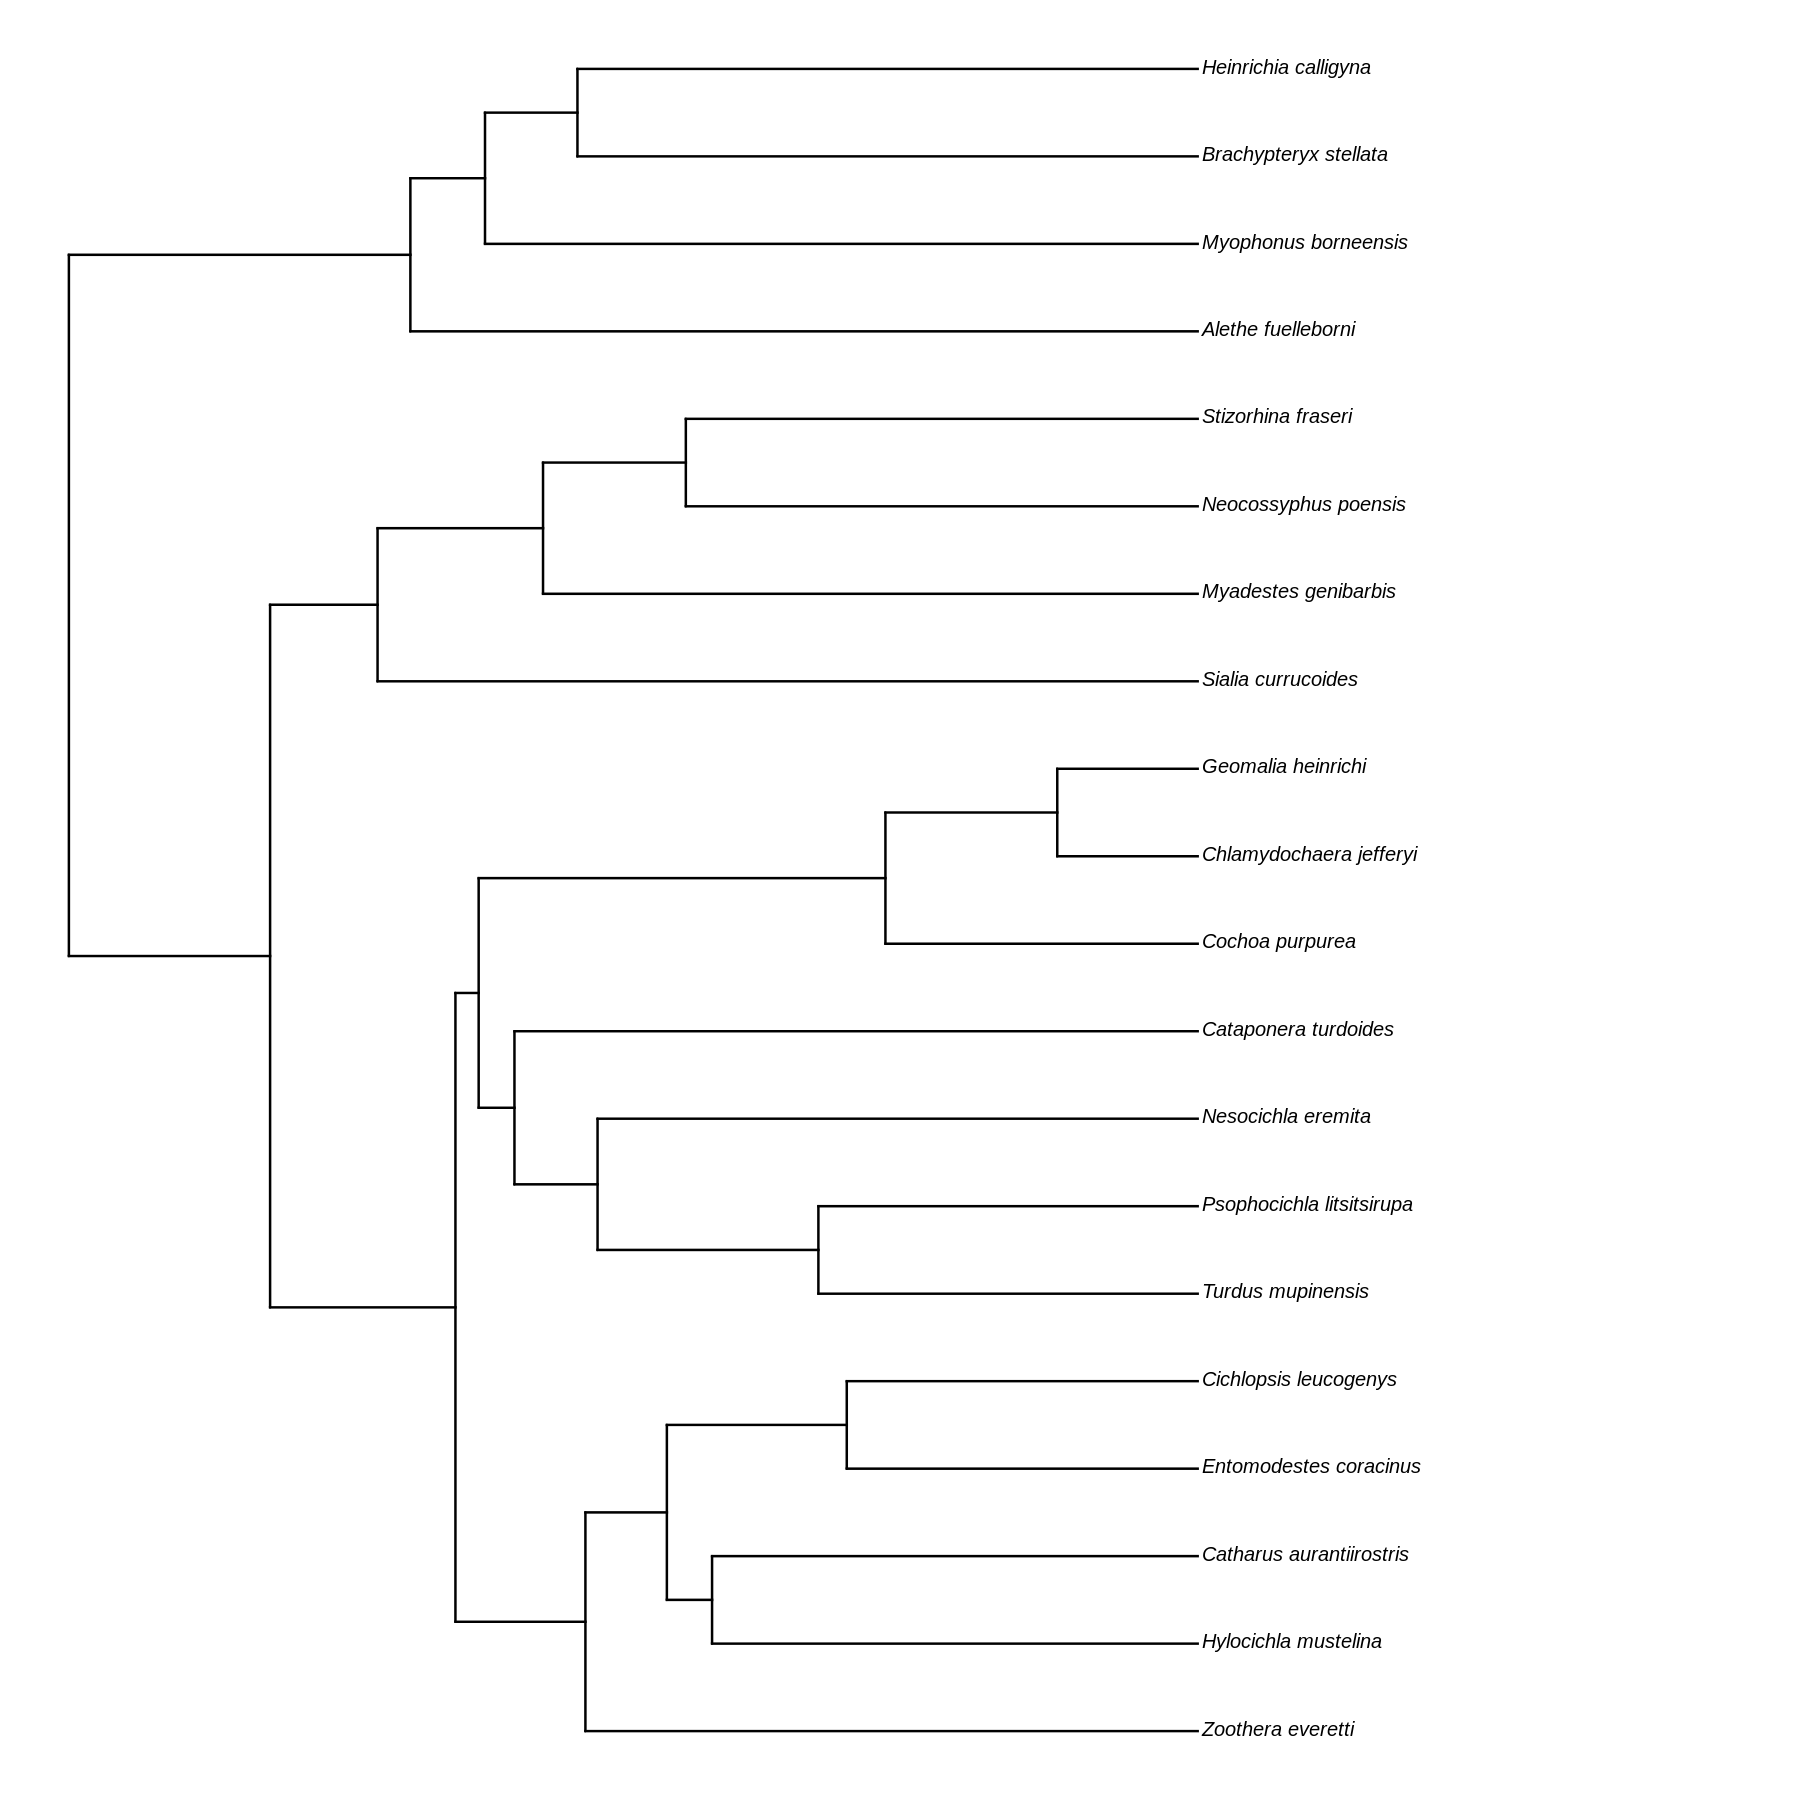

In [77]:
# Combine the columns and add back in the underscore so they match the labels in the tree
genera_tips <- paste(bird_genera$Genus, bird_genera$Species, sep="_")

# Pull out the tips we want to drop
drop.tips <- setdiff(Ran_Turdidae_tree$tip.label, genera_tips)

# Remove all the species except one per genus
genera_tree<-drop.tip(Ran_Turdidae_tree, drop.tips)
plotTree(genera_tree,ftype="i")

As the tree has dropped all but one species per genus, this means we will finally need to also rename the tip labels as well to reflect this change.


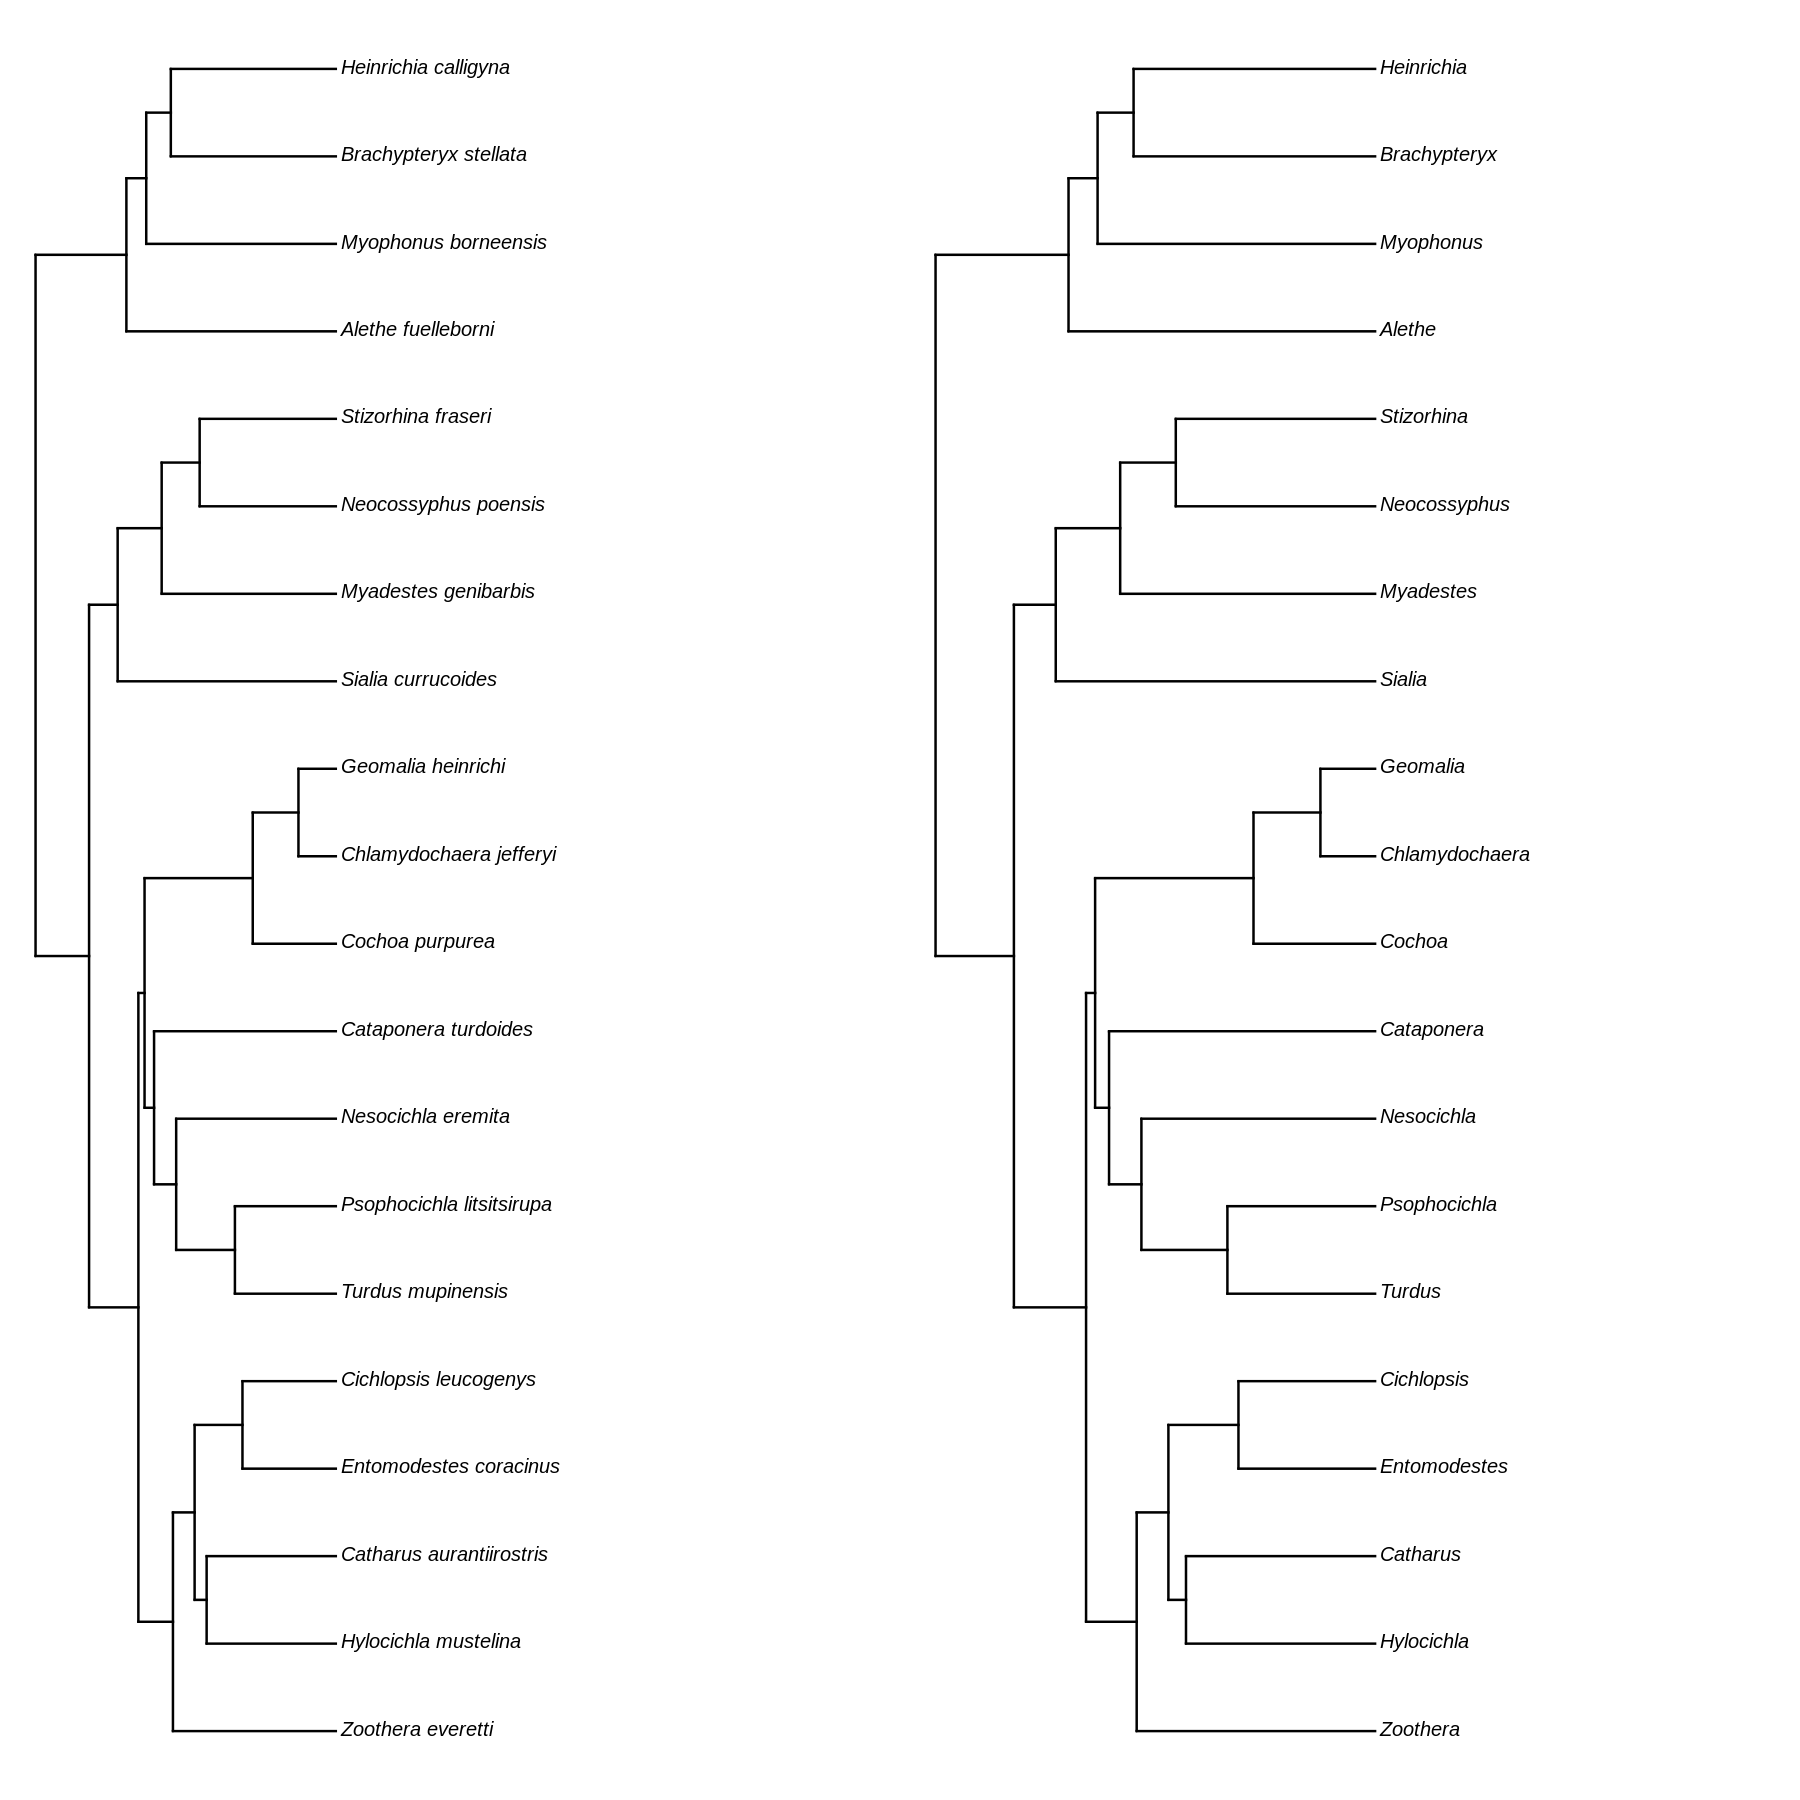

In [78]:
# It's definitely worth checking that the labels match up properly when you change tip labels
par(mfrow=c(1,2))
plotTree(genera_tree,ftype="i")

# Swap species names for genera
genera_tree$tip.label<- bird_genera$Genus
plotTree(genera_tree,ftype="i")

It is important to note, that a big limitation with this approach is that by selecting only one species per genus to keep, that you may run the risk of unintentially dropping tips of species that are paraphyletic. For example, Zoothera genus is spread throughout Turdidae tree.

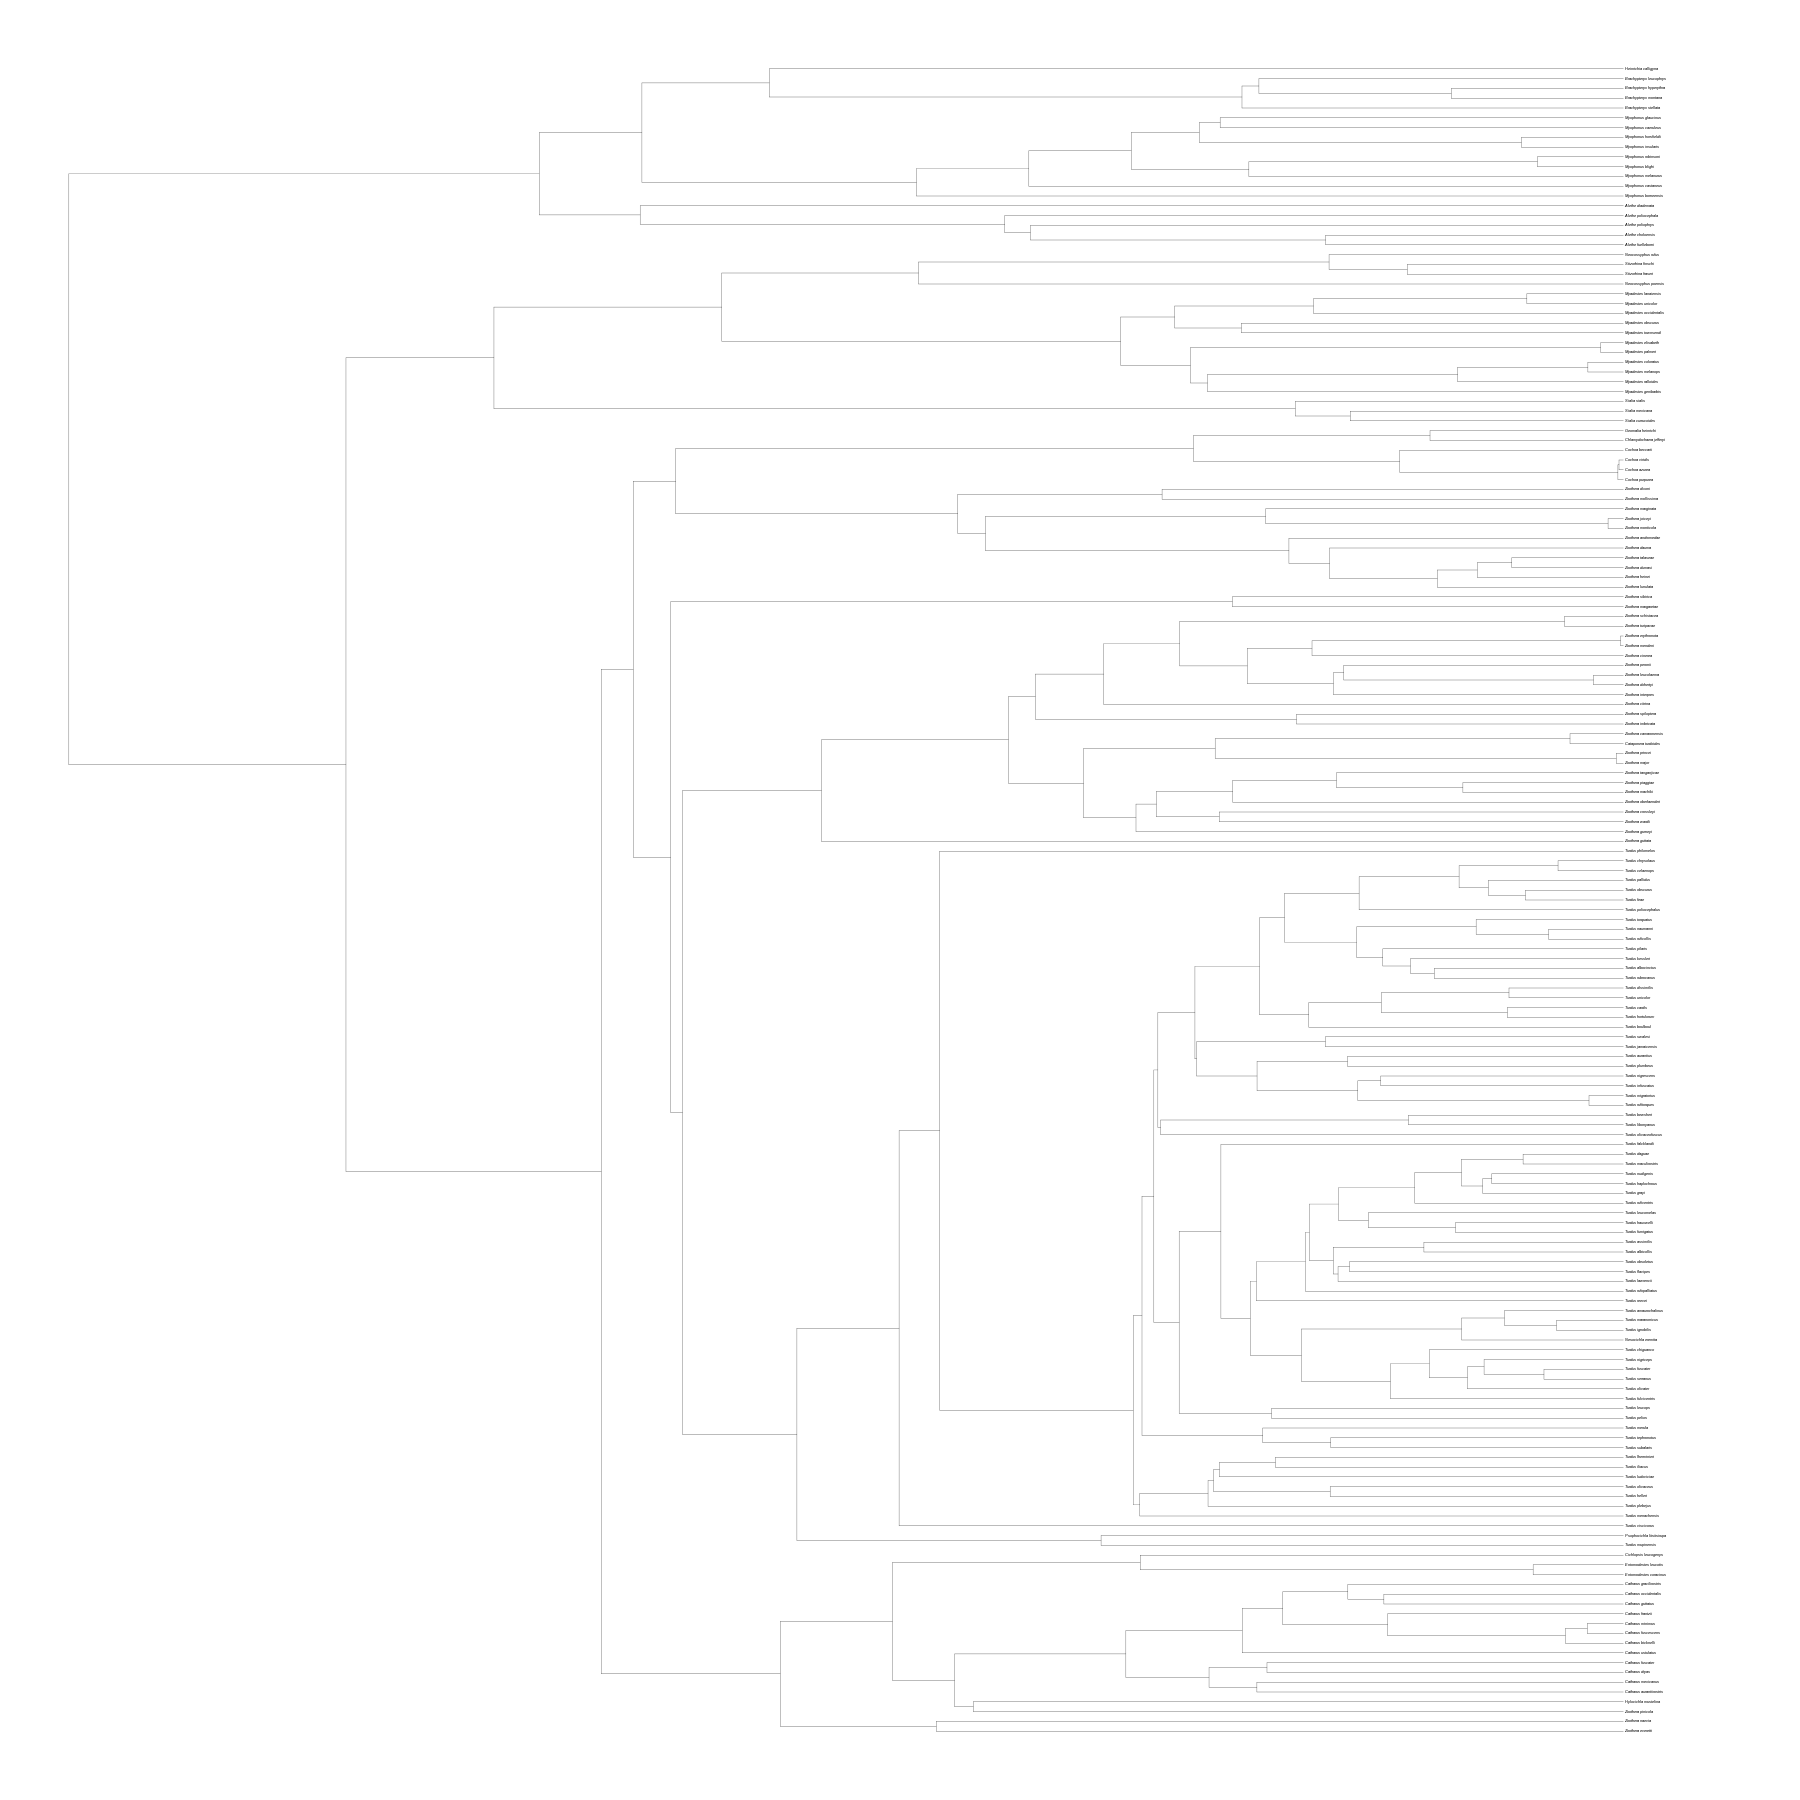

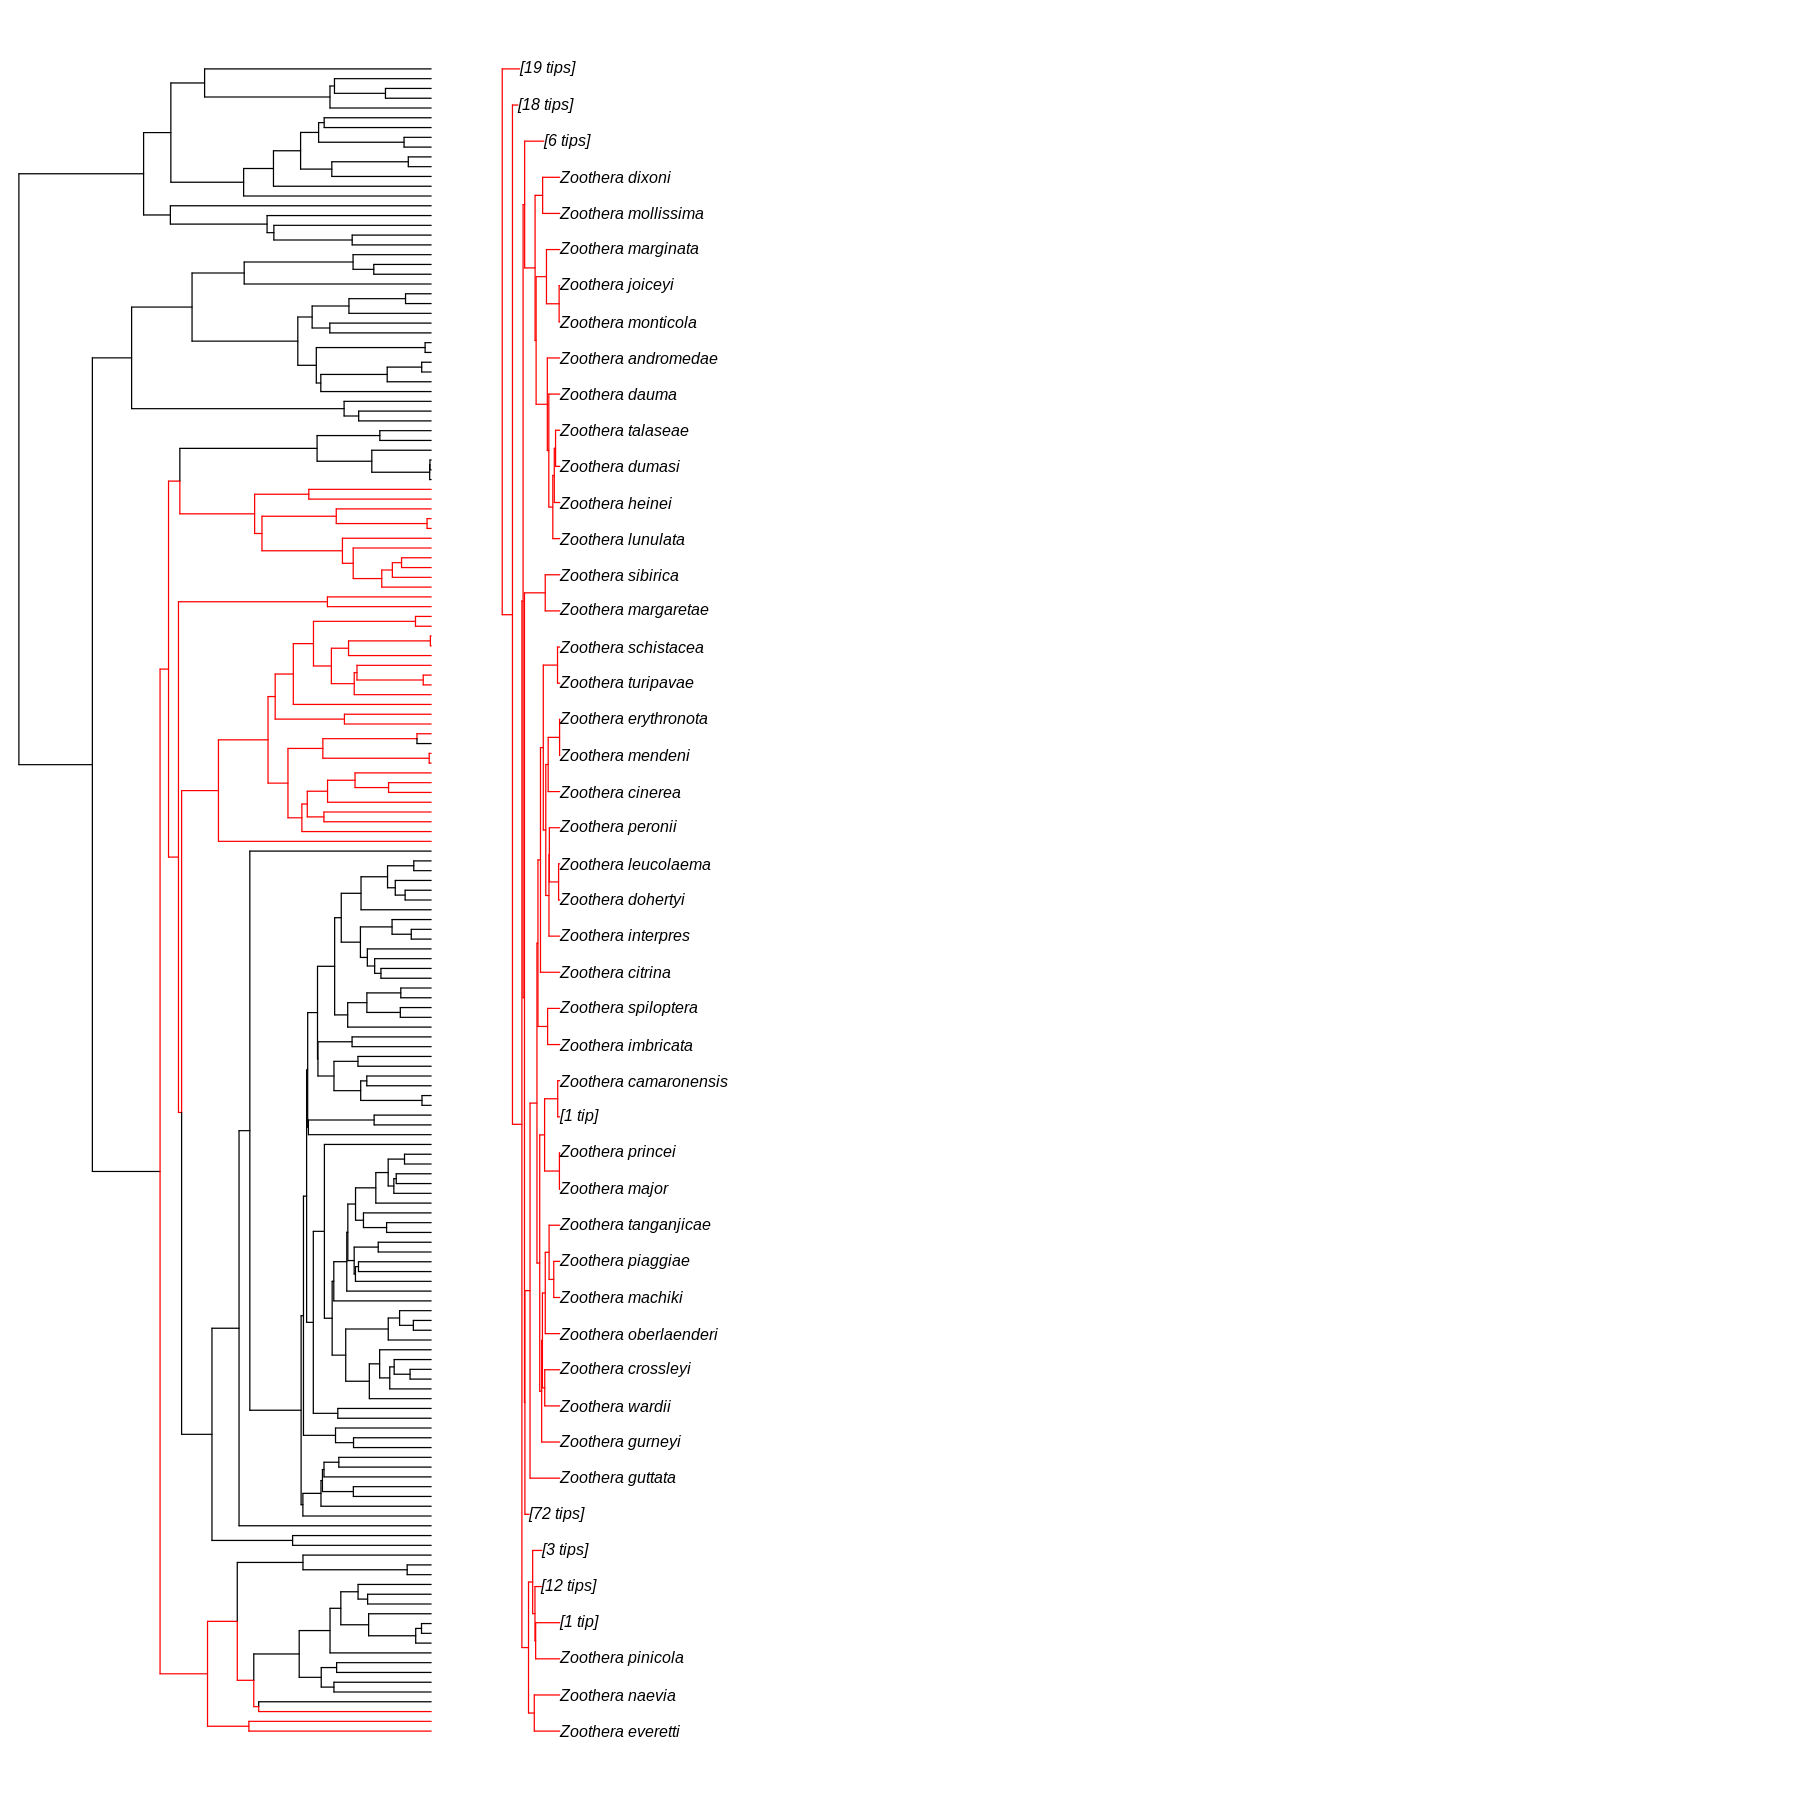

In [79]:
plotTree(Ran_Turdidae_tree,fsize=0.2,lwd=0.2,ftype="i")
zoom(Ran_Turdidae_tree, grep("Zoothera", Ran_Turdidae_tree$tip.label), subtree = TRUE, cex = 0.8)

This means that when collapsing a phylogenetic tree you run the risk of miss representing the relationship between the different genera. The only way to get round this is by:

a) making sure check to see how paraphyletic your tree is at the start; this can be done more easily by uploading and viewing your tree file @ https://itol.embl.de/. 
b) Renaming your conflicting paraphyletic clades within your phylogeny, by altering the individual species names.


In [80]:
Ran_Turdidae_tree$tip.label[Ran_Turdidae_tree$tip.label=="Turdus_philomelos"]<-"Turdus1_philomelos"

### 6. Adding trait data to trees in `R`

Often basic tree plots in R are all you need for exploring data and your analysis. However, for publications and presentations it may be useful to plot trees with associated trait data. We will try plotting data with a tree, using the package `ggtree`, and extension of `ggplot2`.

For this exercise we will use the Turdidae tree (Thrushes) with some data on different habitat types.
Load in the data:

In [95]:
turdidae_data <- read.csv("Turdidae_data.csv")
str(turdidae_data)

'data.frame':	173 obs. of  3 variables:
 $ Jetz_Name: chr  "Alethe choloensis" "Alethe diademata" "Alethe fuelleborni" "Alethe poliocephala" ...
 $ Habitat  : chr  "Dense" "Dense" "Dense" "Dense" ...
 $ Body.Mass: num  41.3 31.5 52 32.4 35.2 ...


We first need to match our data to the tip labels. First we need to put an underscore in the names, and then match them to see if there's any name differences or missing species. In your coursework you will find that occasionally because of taxonomic disagreements, you might be missing species. The easiset way to solve this is by manually checking tips that don't match.

In [96]:
# Replace the blank space with an underscore
turdidae_data$Jetz_Name <- turdidae_data$Jetz_Name %>% str_replace(" ", "_")
head(turdidae_data)

,Jetz_Name,Habitat,Body.Mass
,<chr>,<chr>,<dbl>
1,Alethe_choloensis,Dense,41.30
2,Alethe_diademata,Dense,31.54
3,Alethe_fuelleborni,Dense,52.00
4,Alethe_poliocephala,Dense,32.37
5,Alethe_poliophrys,Dense,35.20
6,Brachypteryx_hyperythra,Semi-Open,78.00


We'll use the `%in%` operator, which is useful checking if our species are in the tip labels

In [97]:
turdidae_data$Jetz_Name %in% Ran_Turdidae_tree$tip.label

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE
 [25]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [37]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [49]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [61]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [73]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [85]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [97]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[109]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[121]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[133]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[145]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[157]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[169]  TRUE  TRUE  TRUE  TRUE  TRUE

We can save the results, and use this to select the rows we need from turdidae_data. We'll use the `!` operator, which means NOT. So in this case it's the species that are not in the tip labels. This can also work for lots of other functions as well so try experimenting!

In [98]:
index <- !(turdidae_data$Jetz_Name %in% Ran_Turdidae_tree$tip.label)
turdidae_data[index,]

,Jetz_Name,Habitat,Body.Mass
,<chr>,<chr>,<dbl>
23,Chaetops_aurantius,Open,41.1
24,Chaetops_frenatus,Open,45.6


One of them we renamed so we'll change that back for our plots. The others aren't in our taxonomy. This is because they've been moved to Chaetopidae, a new family of just rockjumpers. This often happens as there are three main bird taxonomies: Jetz, Birdlife, and American Ornithological Society. We'll just remove them from our dataset.

In [99]:
# Change the name back
Ran_Turdidae_tree$tip.label[Ran_Turdidae_tree$tip.label=="Turdus1_philomelos"]<-"Turdus_philomelos"
# Get the species that ARE in the tips
index <- turdidae_data$Jetz_Name %in% Ran_Turdidae_tree$tip.label
# Select only these species
turdidae_data <- turdidae_data[index,]

Now we can drop the tips that don't match and get plotting!

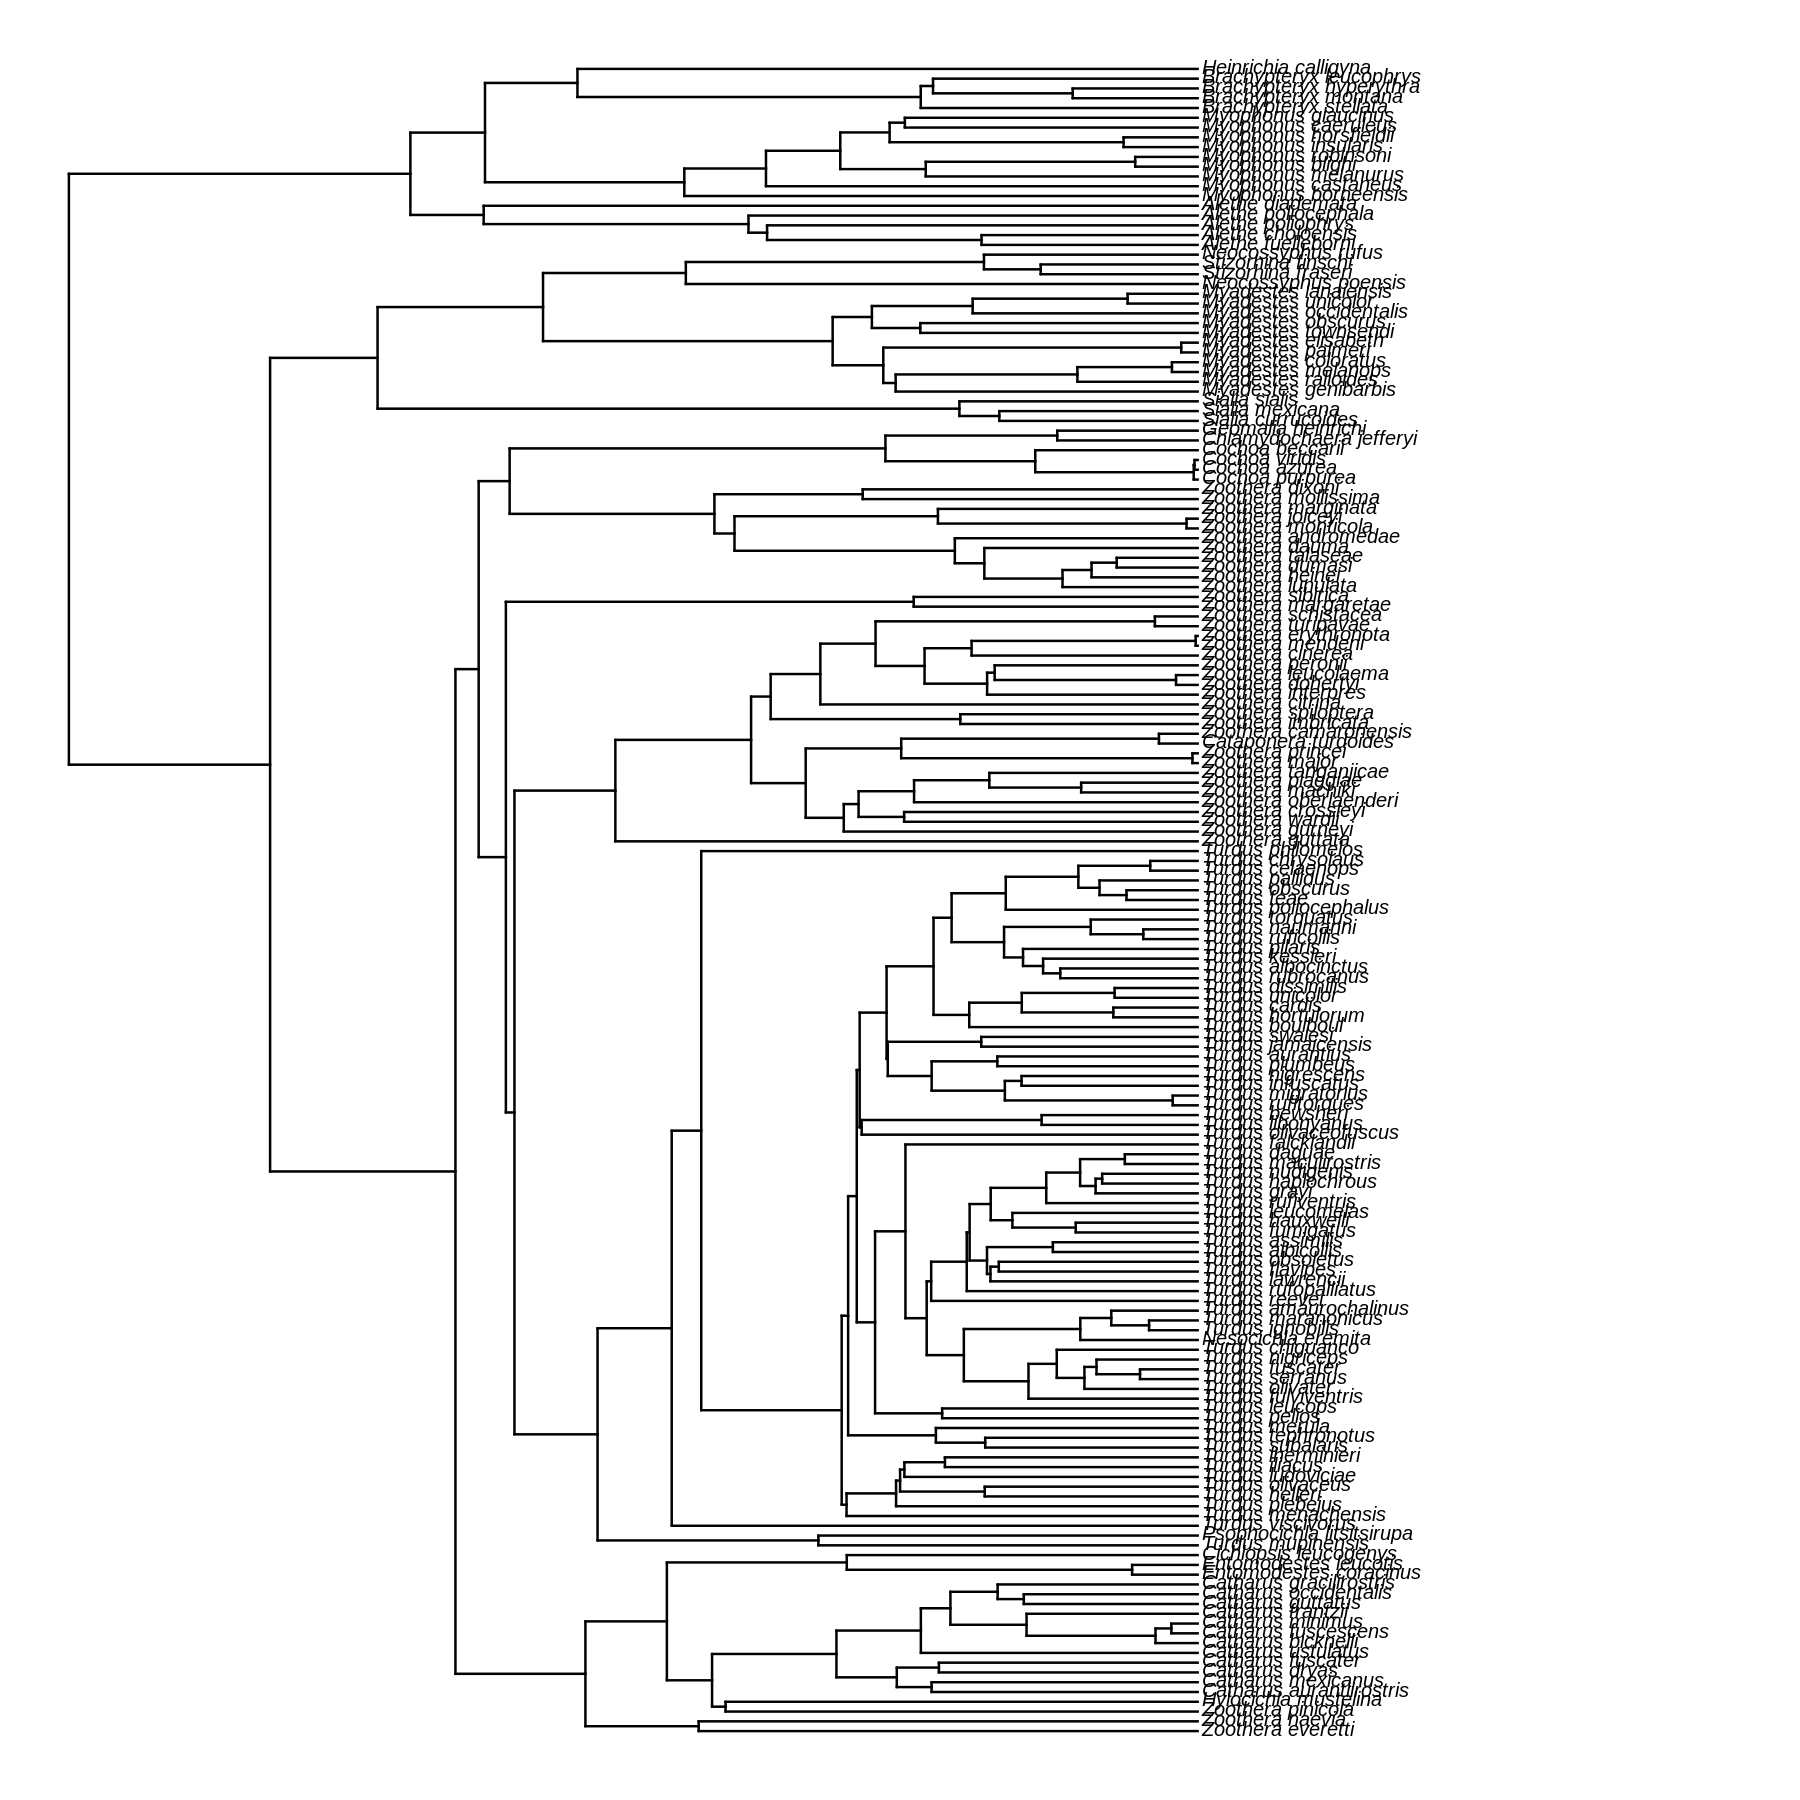

In [100]:
drop.tips <- setdiff(Ran_Turdidae_tree$tip.label, turdidae_data$Jetz_Name)

# Remove all the species except one per genus
turdi_tree <-drop.tip(Ran_Turdidae_tree, drop.tips)
plotTree(turdi_tree,ftype="i")

Now lets try using ggtree to plot our data with our phylogeny. First we need to install `ggtree`. This package was intentionally left out of the 'install.R' script. Because not all packages are available from `CRAN` directly through `R`, we'll install `BiocManager`. `devtools` is another great package for installing packages from github.

In [101]:
install.packages("BiocManager")
BiocManager::install("ggtree")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'ggtree'

Old packages: 'lubridate', 'magrittr', 'rprojroot', 'rstudioapi', 'vctrs',
  'foreign'



In [102]:
library(ggtree)
library(ggplot2)

`ggtree` is a bit more complicated than just normal tree plots, but you can also do a lot more. We'll create a basic tree plot structure first and then add tip labels and traits after. We'll also make the plotting window bigger.

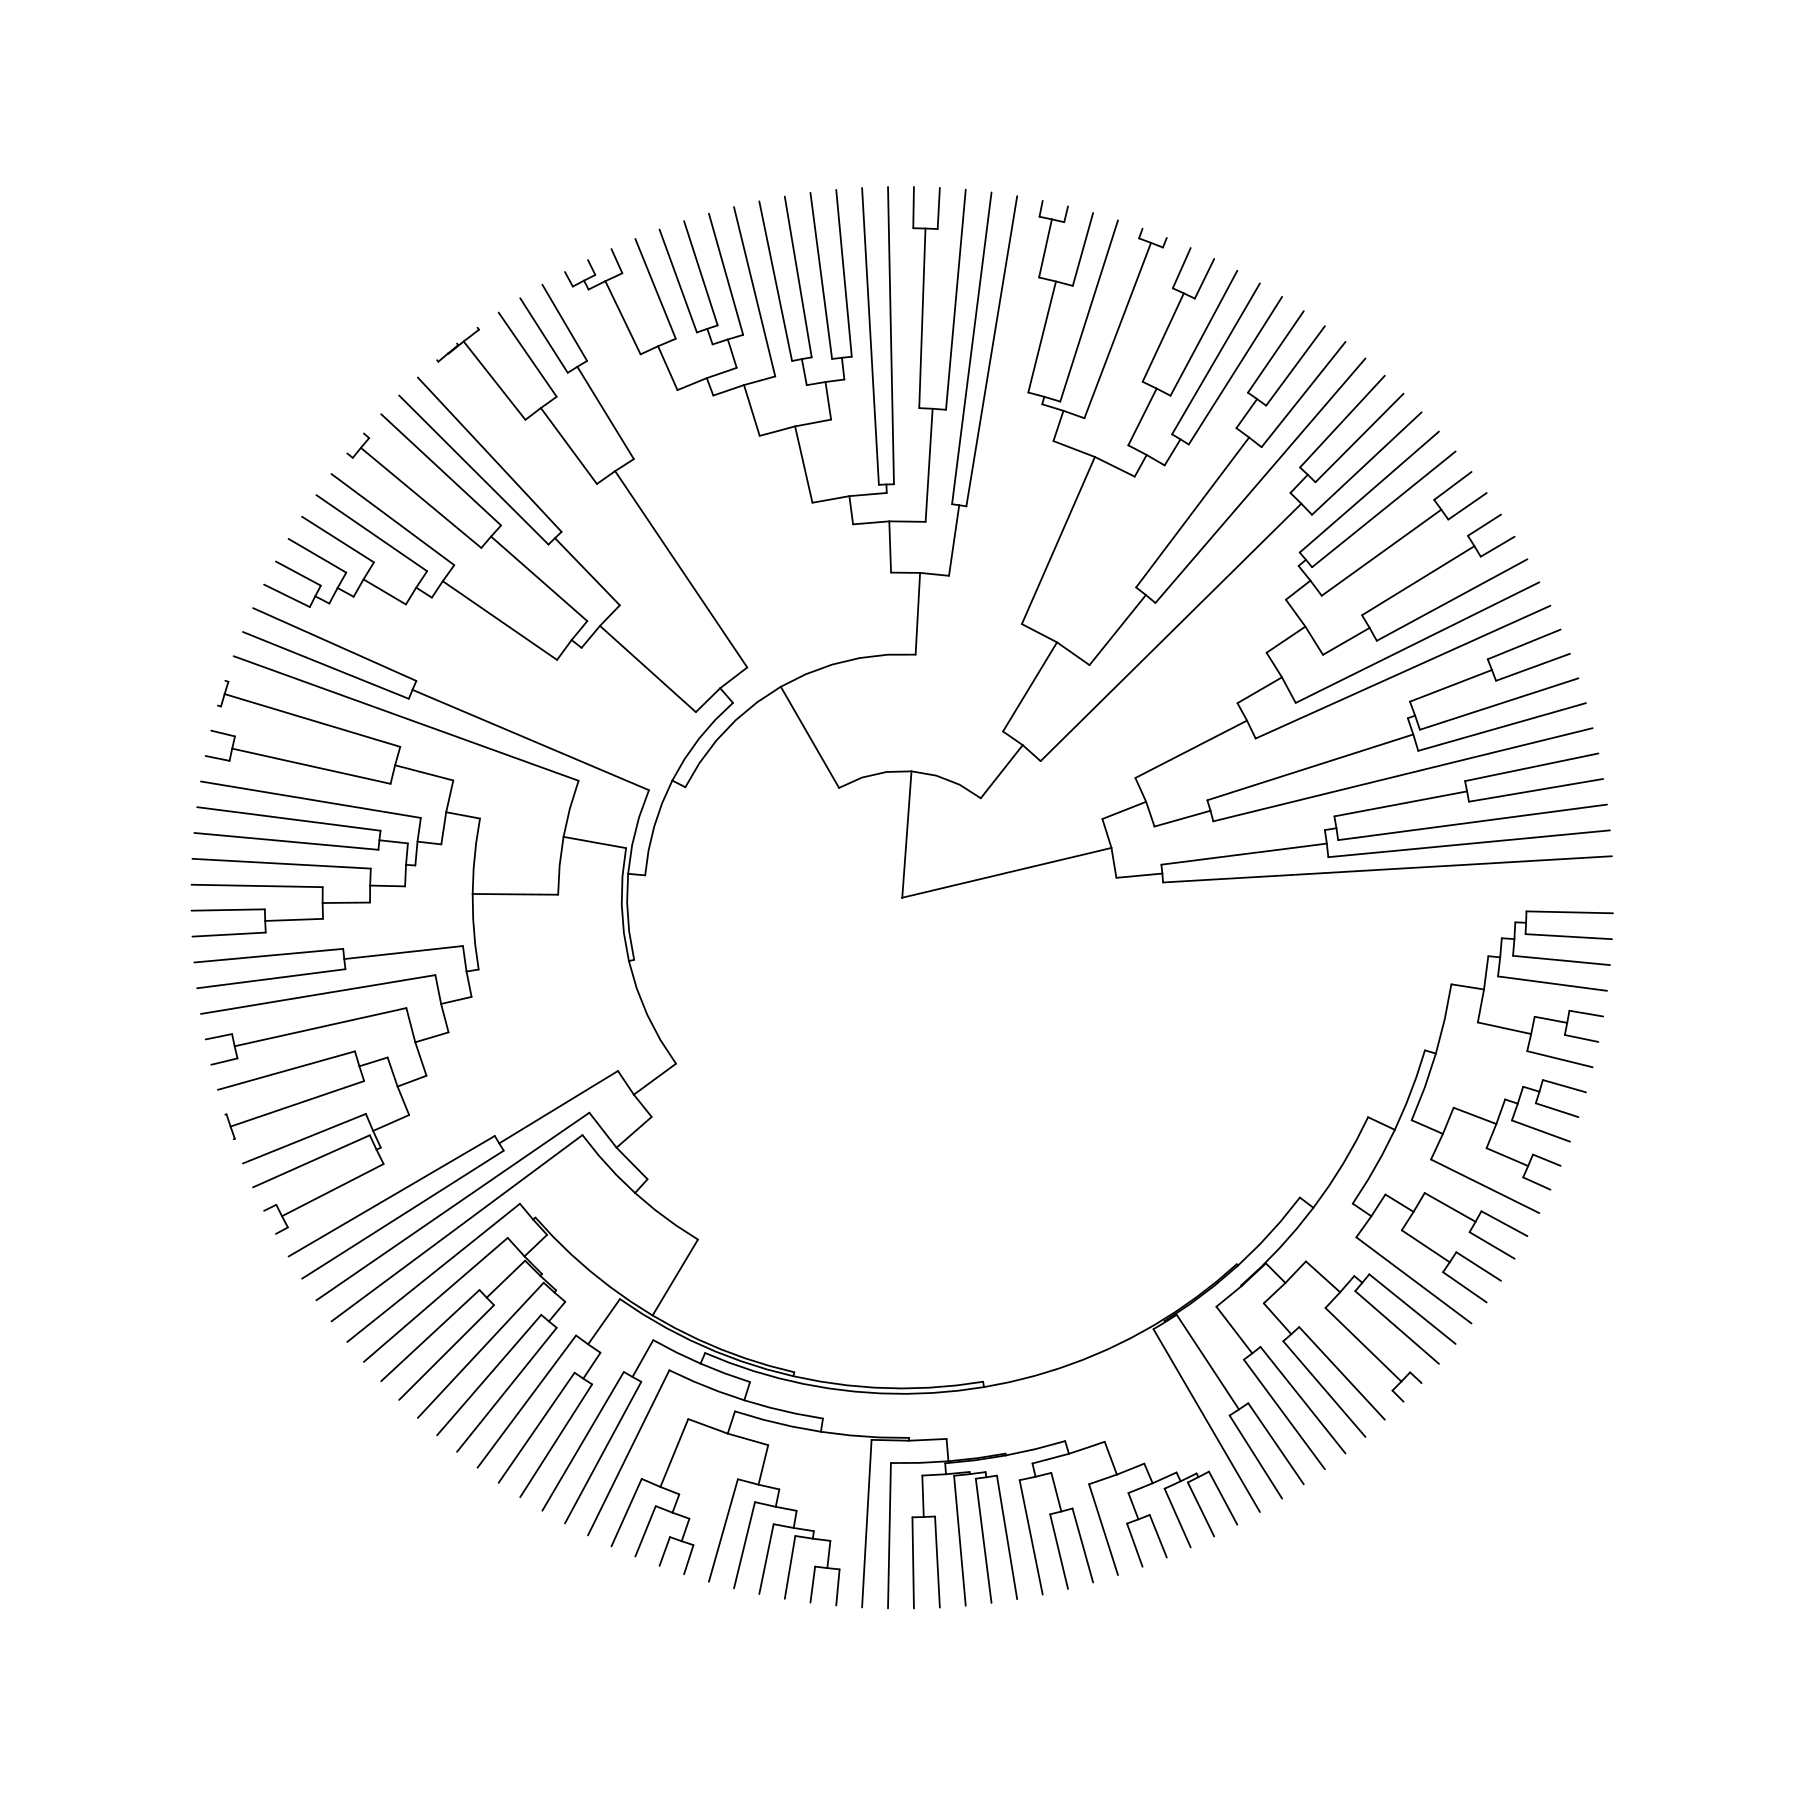

In [103]:
# This resizes the plot windows if you use an online notebook. In RStudio you can do this when you export plots using jpeg() etc.
options(repr.plot.width=15, repr.plot.height=15)
turdidae_plot <- ggtree(turdi_tree, layout = "circular")
turdidae_plot

Now we'll create a simple one column dataframe with just the habitat data to plot and the species names as row names.

In [104]:
habitat_data <- as.data.frame(turdidae_data[,2])
rownames(habitat_data) <- turdidae_data$Jetz_Name
colnames(habitat_data) <- "Habitat"

Now we can make our plot!

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



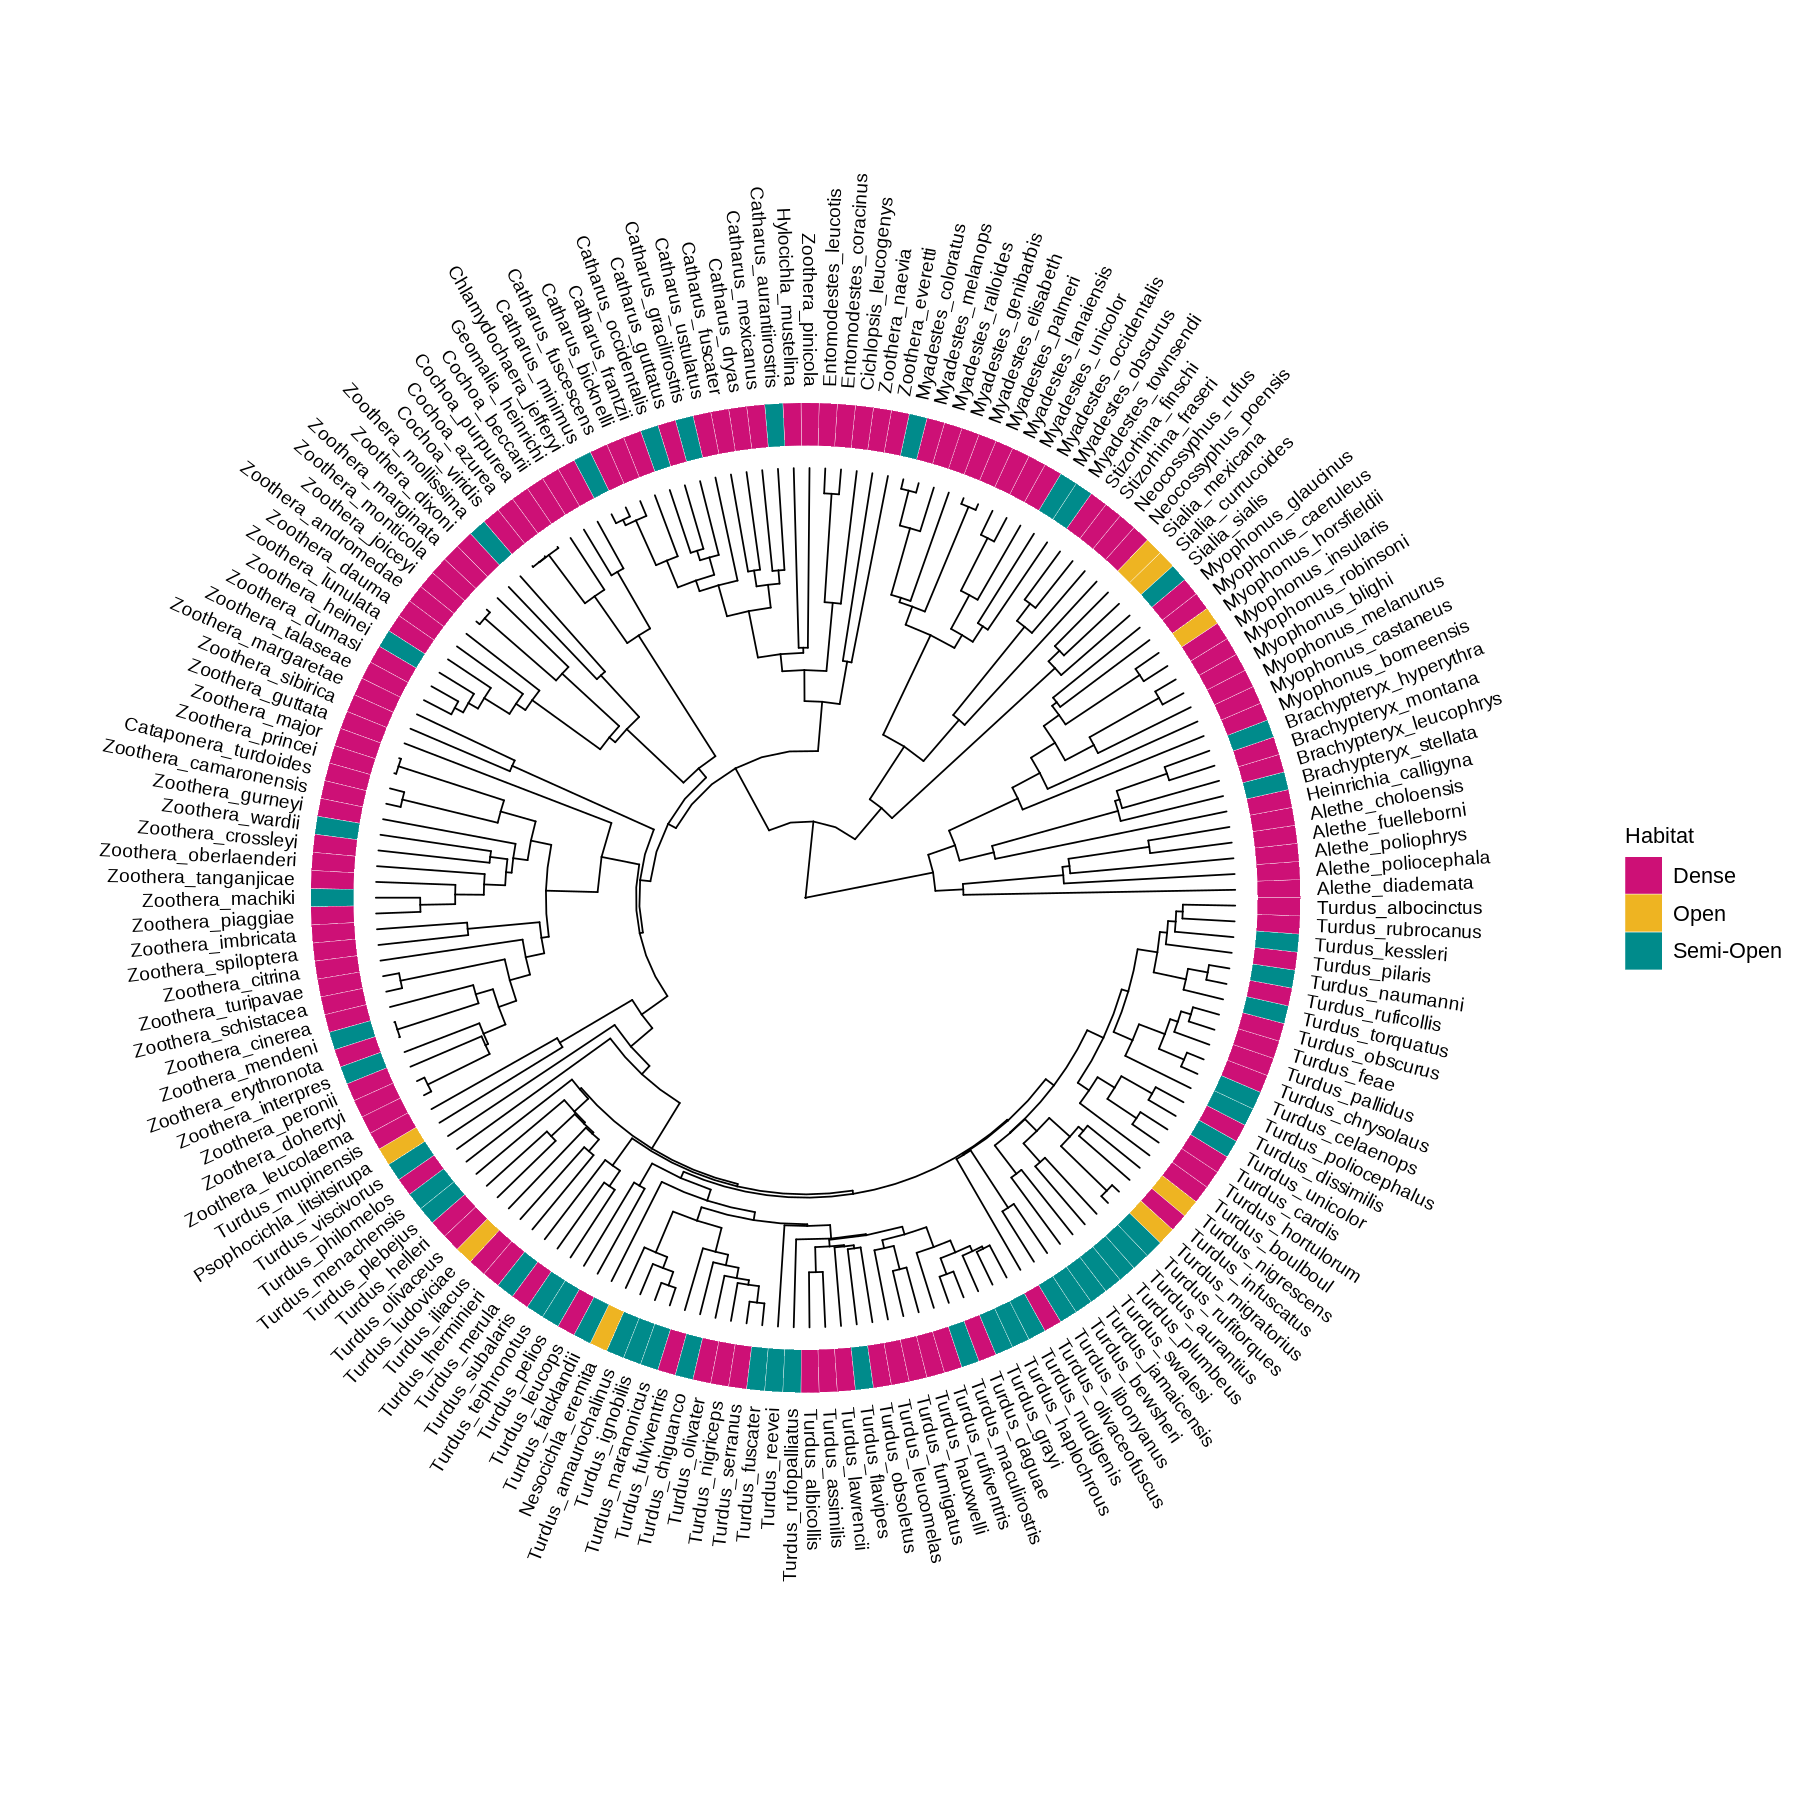

In [105]:
# Create the heat map using habitat data. Offset tells us how far from the tips to plot the data and width is how wide the bars are.
gheat <- gheatmap(p=turdidae_plot, data=habitat_data, offset = 0.05, width=0.1, colnames = FALSE) + 
# Scale fill manual is a ggplot function. It lets the plot know what to 'fill' and what colours to use.
scale_fill_manual(name = 'Habitat', values=c("deeppink3", "goldenrod2", "cyan4")) + 
# Add the tip labels and offset them further from the bars
geom_tiplab(offset = 5, cex=4) + 
# We're adding tip labels on top of an existing plot, so we need to make the axes bigger so our labels don't fall off the edge.
xlim(0, 40) +
# This resizes the legend and makes the text bigger than the default. Try changing the numbers!
theme(legend.key.width = unit(0.8, "cm"), legend.key.height = unit(0.8, "cm"), legend.text = element_text(size = 13), legend.title = element_text(size = 13))

# Lastly plot the data!
plot(gheat)

And now we have a plot where we can see the spread of habitat types in Thrushes. Try experimenting with different colours and sizes to create some beautiful trees that put this one to shame! There's also lots of other ways you can label trees. For more info this guide is a great place to start: 
https://4va.github.io/biodatasci/r-ggtree.html#the_ggtree_package



> Extra task: Can you make another plot for continuous body mass data? Think about how you'd show this with colour. Can you change the key to better display the change in body mass? Is body mass more clumped in the tree than habitat? 